# Ross Sea synthetic gravity inversion

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import pickle
import string

import numpy as np
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

import RIS_gravity_inversion.plotting as RIS_plotting
import RIS_gravity_inversion.synthetic as RIS_synth

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, regional, uncertainty, utils

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km


INFO:root:returning grid with new region and/or registration, same spacing


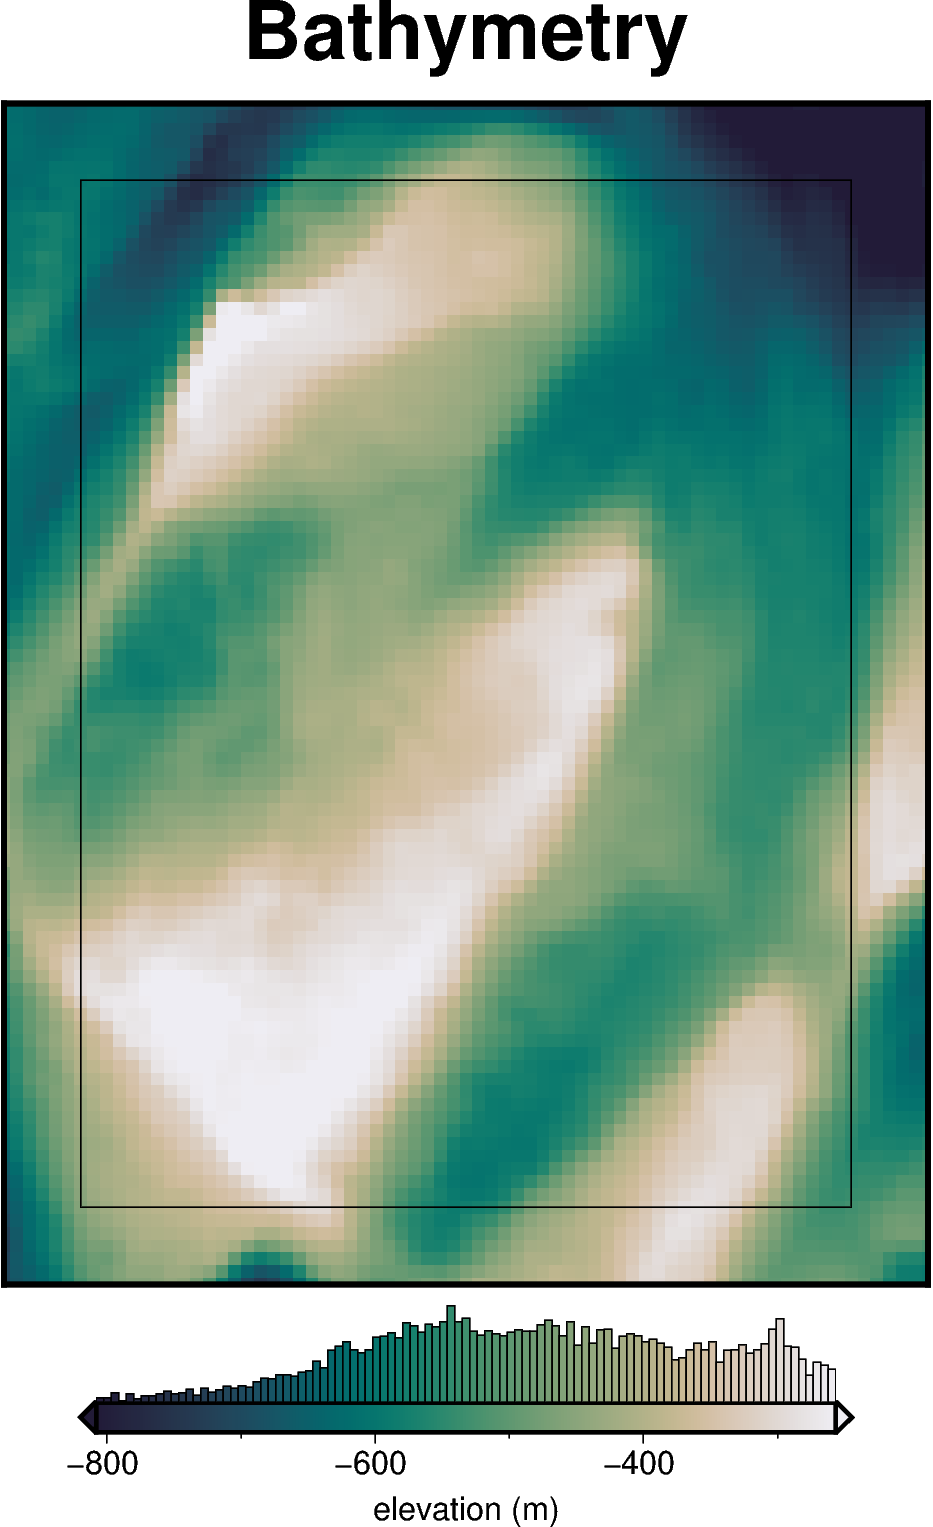

  0%|          | 0/4941 [00:00<?, ?it/s]

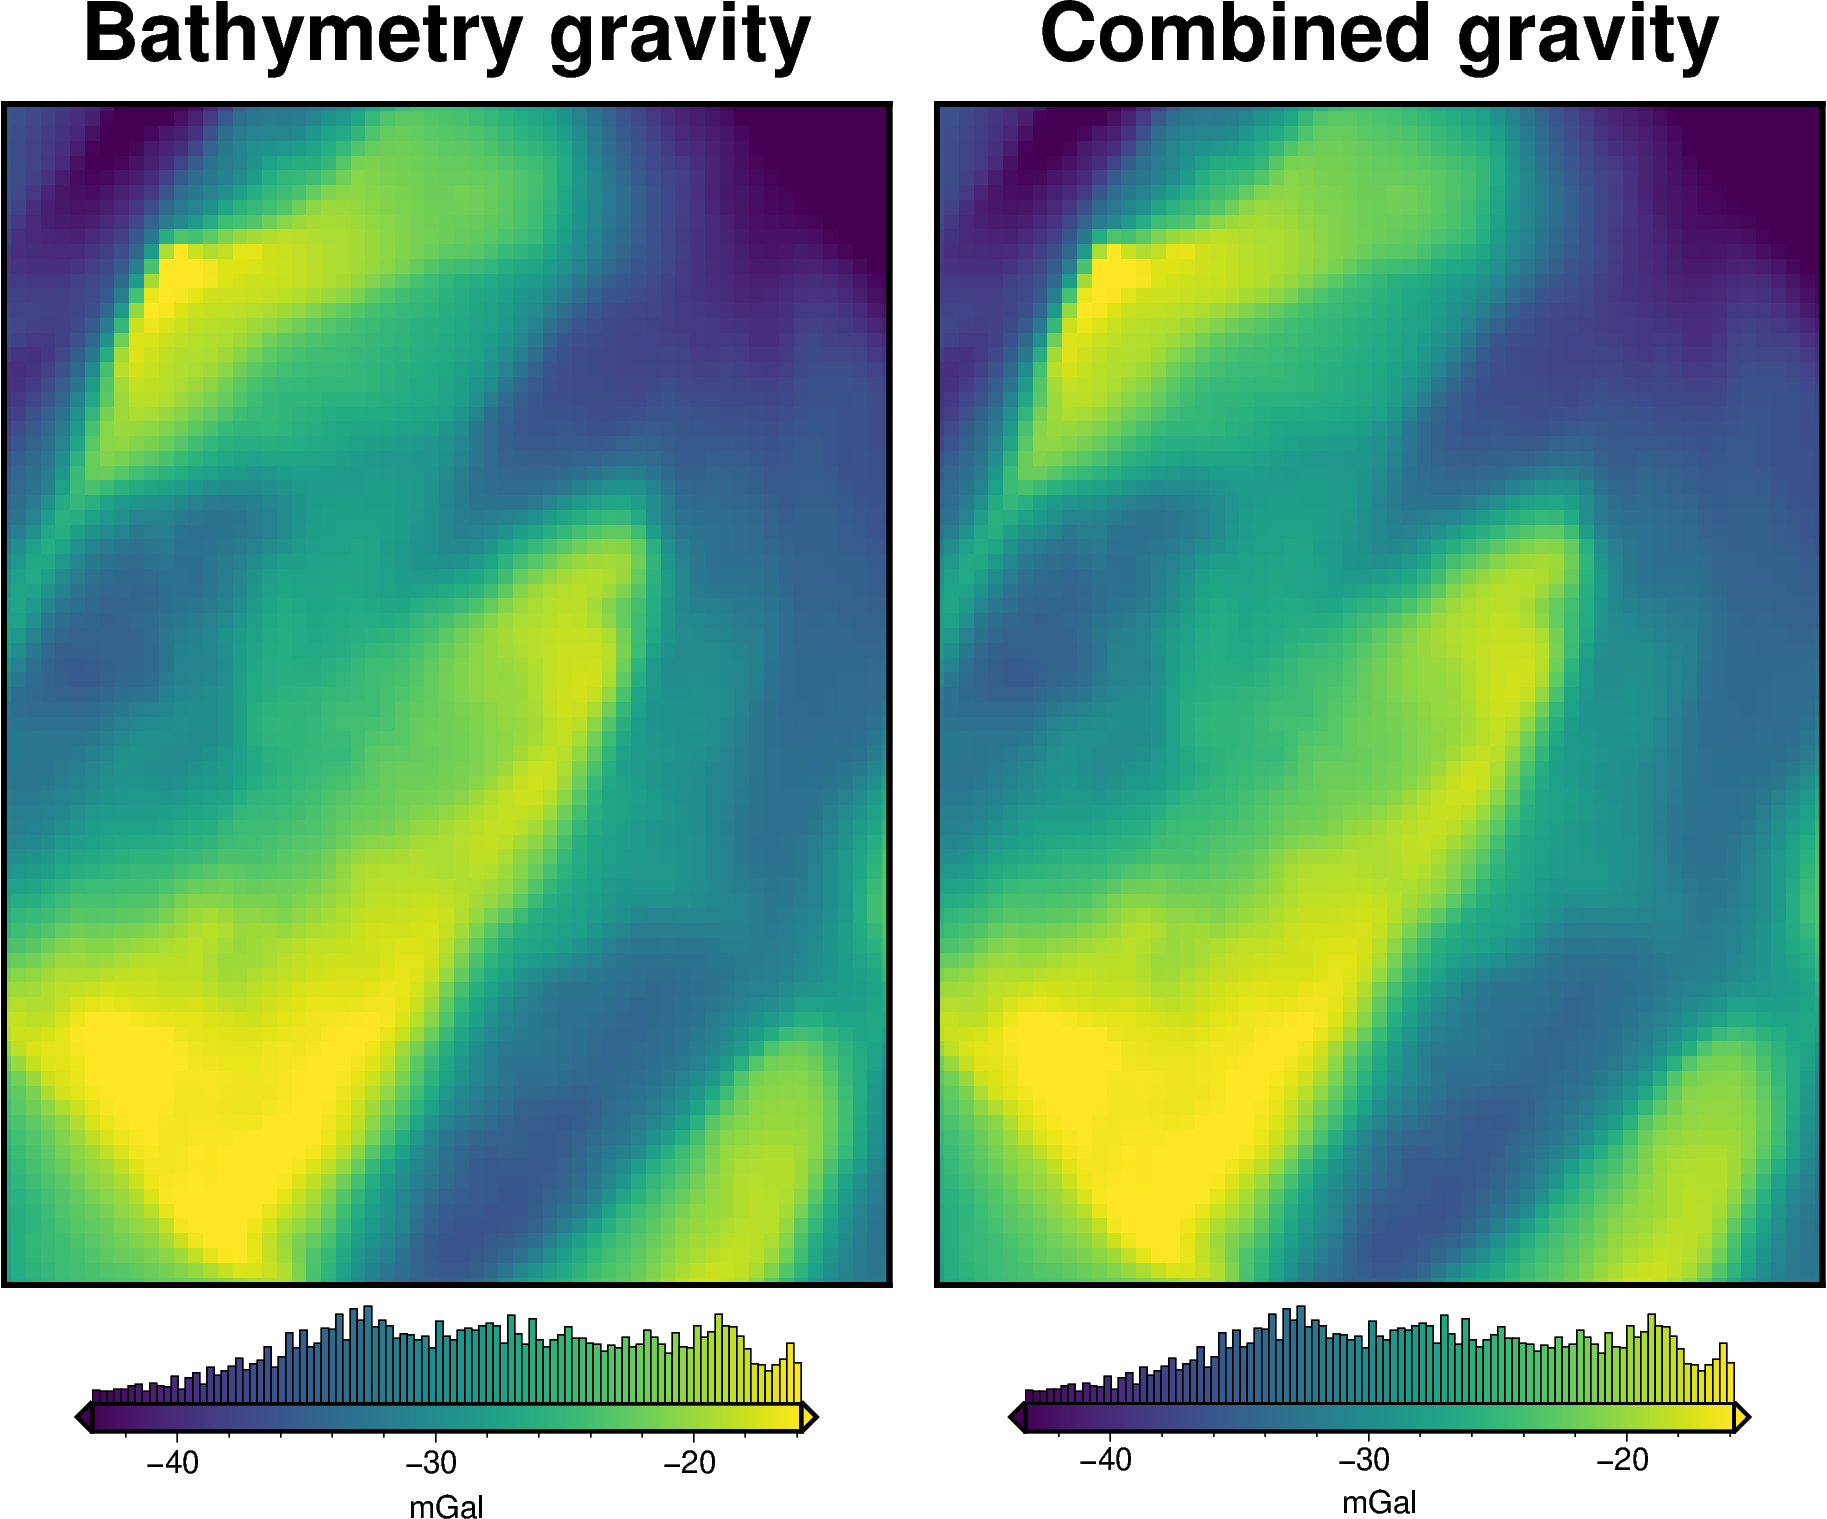

In [2]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing * 6,
    # gravity_noise=0,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [3]:
grav_df.head()

northing  easting  upward  bathymetry_grav  basement_grav  disturbance  \
0 -1800000.0 -40000.0  1000.0       -28.046289              0   -28.046289   
1 -1800000.0 -35000.0  1000.0       -26.714502              0   -26.714502   
2 -1800000.0 -30000.0  1000.0       -25.919276              0   -25.919276   
3 -1800000.0 -25000.0  1000.0       -25.236960              0   -25.236960   
4 -1800000.0 -20000.0  1000.0       -24.610928              0   -24.610928   

   gravity_anomaly  
0       -28.046289  
1       -26.714502  
2       -25.919276  
3       -25.236960  
4       -24.610928

# Make starting bathymetry model

In [4]:
# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    shape=(4, 5),
    region=inversion_region,
    padding=-spacing,
)

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "true_upward",
    coord_names=("easting", "northing"),
)
constraint_points["upward"] = constraint_points.true_upward
constraint_points.head()

northing   easting  true_upward      upward
0 -1756000.0    1250.0  -277.117397 -277.117397
1 -1756000.0   73750.0  -292.754172 -292.754172
2 -1756000.0  146250.0  -587.490438 -587.490438
3 -1756000.0  218750.0  -303.910608 -303.910608
4 -1678000.0    1250.0  -356.930926 -356.930926

In [5]:
# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 5% of depth
uncert = np.abs(0.05 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "true_uncert"] = uncert

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="true_uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.true_uncert**2)

constraint_points.head()

northing   easting  true_upward      upward  true_uncert    weight
0 -1756000.0    1250.0  -277.117397 -275.375295    13.855870  0.005209
1 -1756000.0   73750.0  -292.754172 -294.687884    14.637709  0.004667
2 -1756000.0  146250.0  -587.490438 -568.678329    29.374522  0.001159
3 -1756000.0  218750.0  -303.910608 -302.316595    15.195530  0.004331
4 -1678000.0    1250.0  -356.930926 -366.490774    17.846546  0.003140

In [6]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,
)
starting_bathymetry = utils.create_topography(**starting_topography_kwargs)

starting_bathymetry

<xarray.DataArray 'scalars' (northing: 93, easting: 73)> Size: 54kB
array([[-303.24475574, -298.17670114, -293.309081  , ..., -141.38005887,
        -137.601561  , -134.26376675],
       [-306.36095693, -301.17407494, -296.18418998, ..., -146.10221978,
        -142.49600468, -139.33518106],
       [-309.55275108, -304.24244944, -299.12514901, ..., -150.95475306,
        -147.54398876, -144.57979728],
       ...,
       [-926.46439054, -915.53324124, -904.29780712, ..., -760.25661438,
        -766.95359347, -773.34054824],
       [-933.74127475, -922.61035891, -911.16790173, ..., -762.49954932,
        -769.32269313, -775.84002087],
       [-940.91296772, -929.59751638, -917.96743203, ..., -764.95391321,
        -771.88330366, -778.51304949]])
Coordinates:
  * easting   (easting) float64 584B -7e+04 -6.5e+04 -6e+04 ... 2.85e+05 2.9e+05
  * northing  (northing) float64 744B -1.83e+06 -1.825e+06 ... -1.37e+06
Attributes:
    metadata:  Generated by SplineCV(cv=KFold(n_splits=5, random_state=0, shu...
    damping:   None

In [7]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_bathymetry,
    "starting_bathymetry",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.starting_bathymetry)
print(f"RMSE: {rmse:.2f} m")

RMSE: 20.25 m


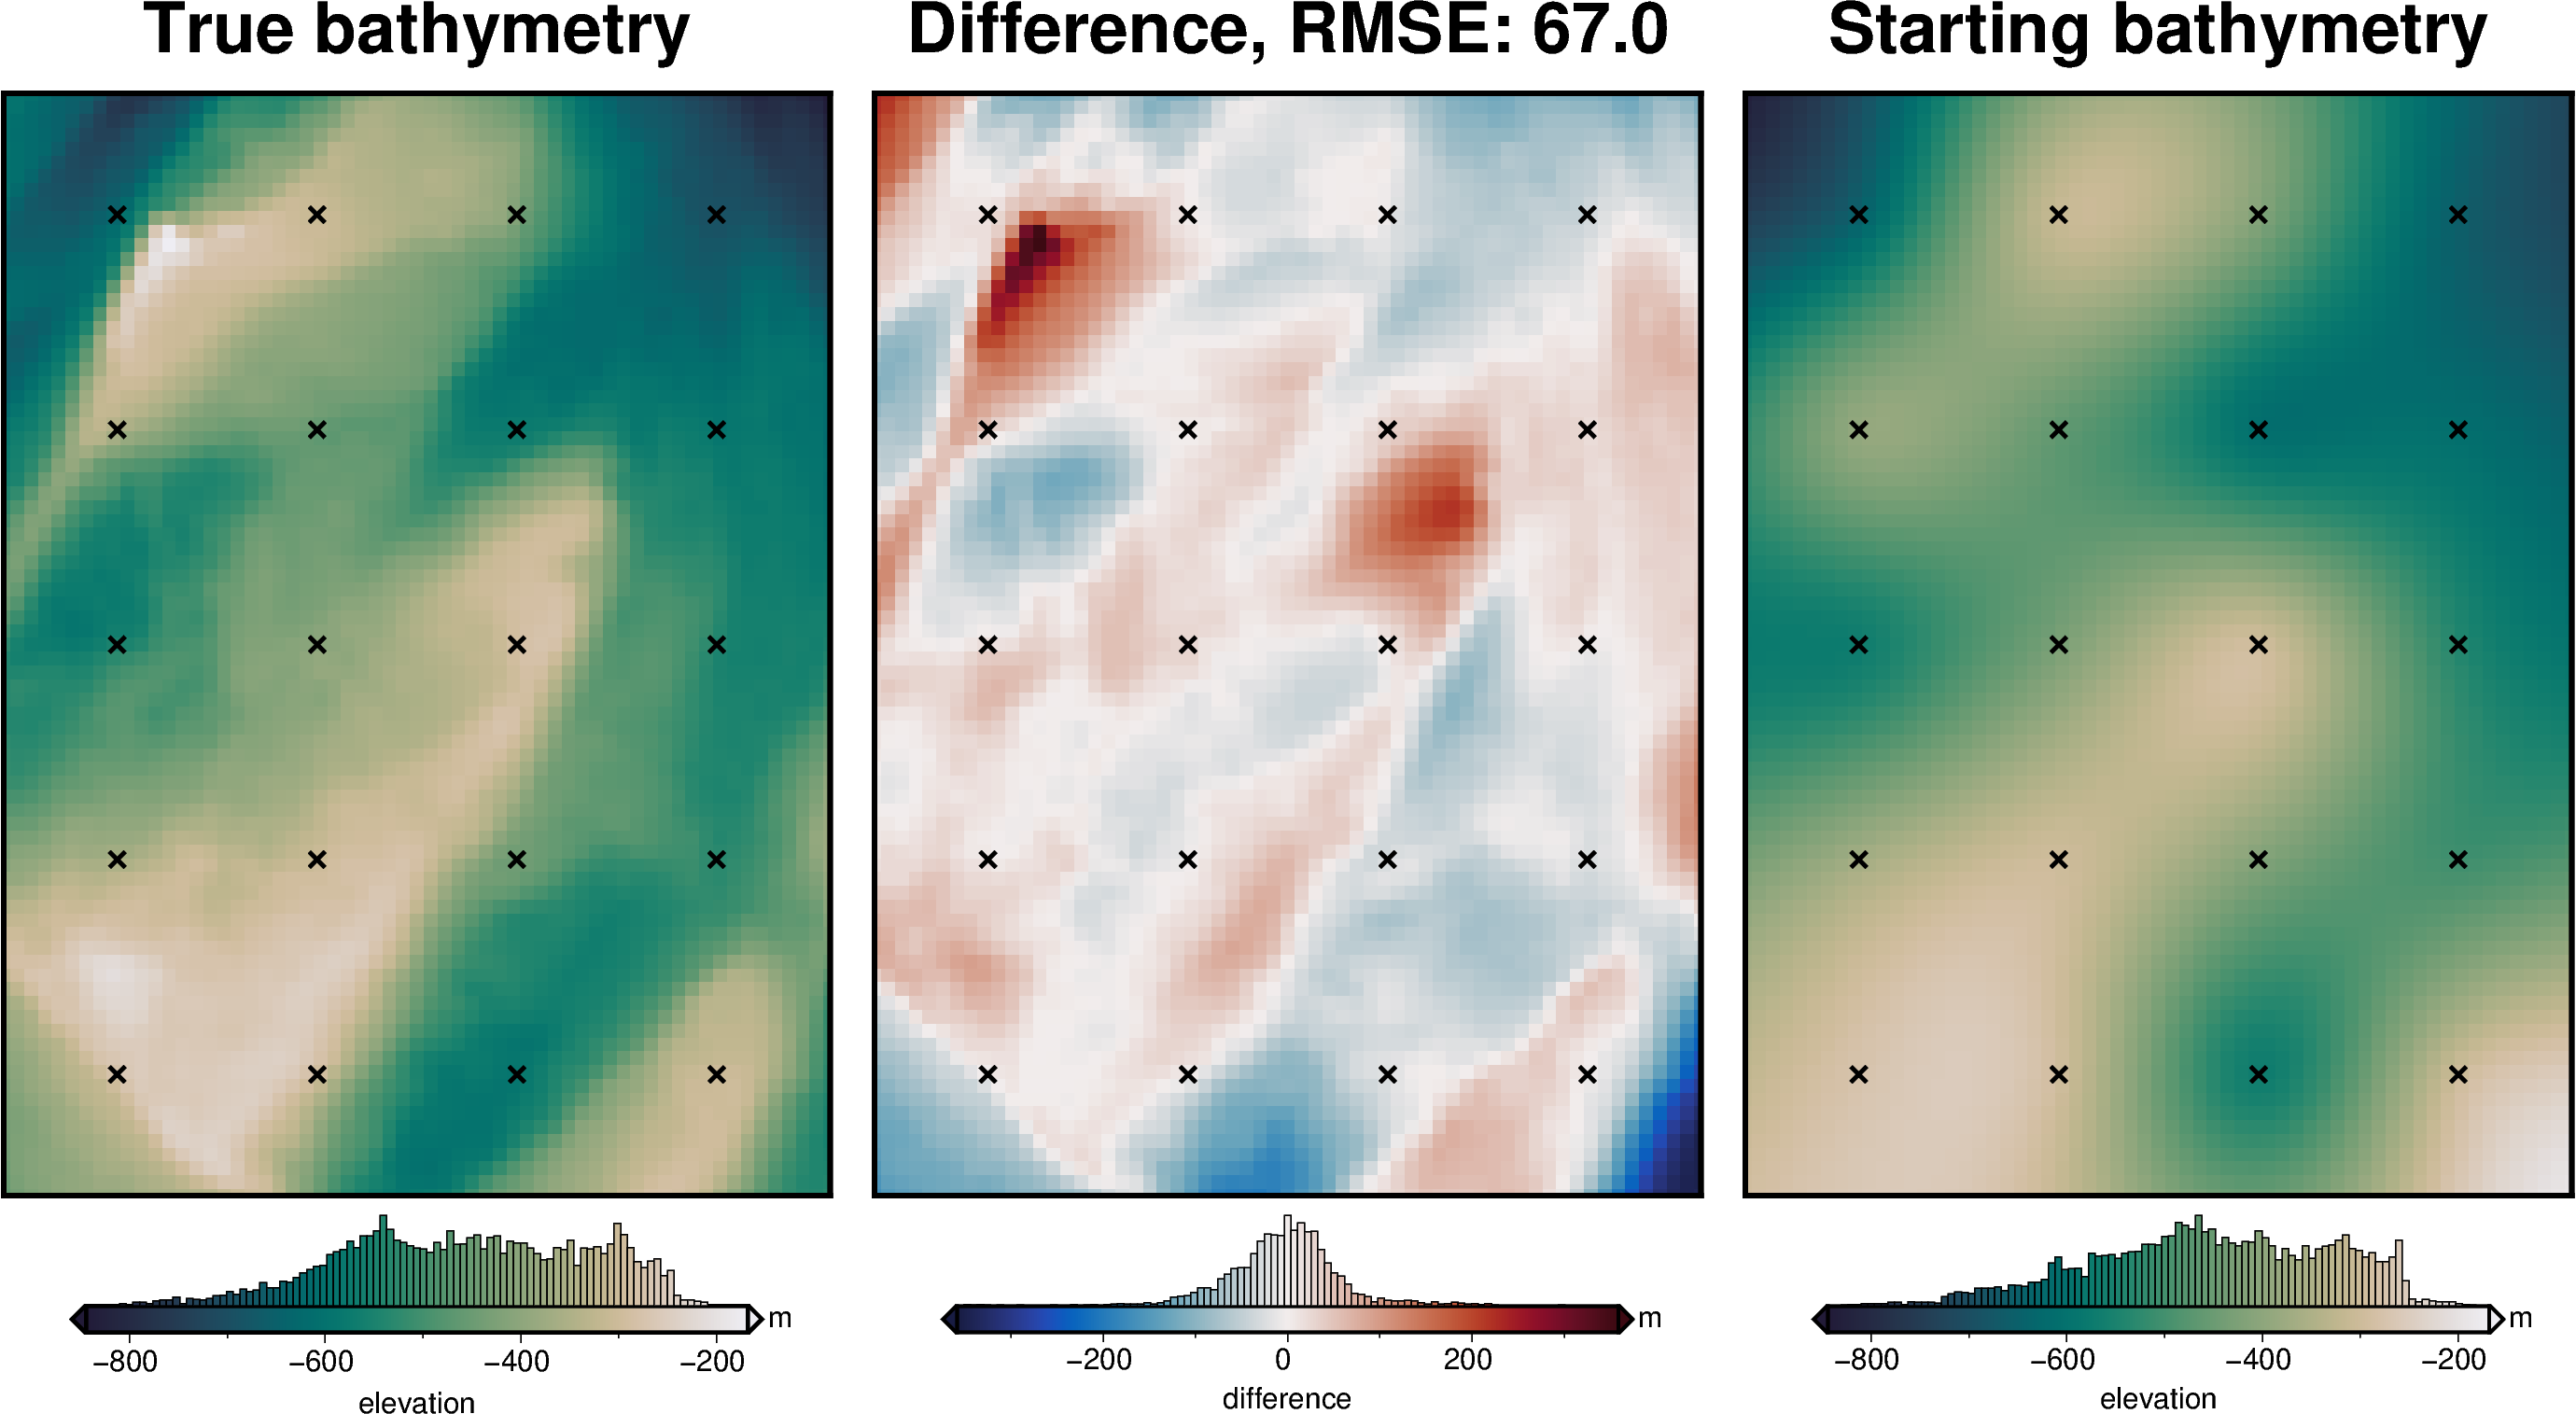

In [8]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [8]:
# the true density contrast is 1476 kg/m3
density_contrast = 1350

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >= zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1800000.0  -40000.0  1000.0       -28.046289              0   
1    -1800000.0  -35000.0  1000.0       -26.714502              0   
2    -1800000.0  -30000.0  1000.0       -25.919276              0   
3    -1800000.0  -25000.0  1000.0       -25.236960              0   
4    -1800000.0  -20000.0  1000.0       -24.610928              0   
...         ...       ...     ...              ...            ...   
4936 -1400000.0  240000.0  1000.0       -48.323584              0   
4937 -1400000.0  245000.0  1000.0       -48.356131              0   
4938 -1400000.0  250000.0  1000.0       -49.079005              0   
4939 -1400000.0  255000.0  1000.0       -49.877171              0   
4940 -1400000.0  260000.0  1000.0       -50.834525              0   

      disturbance  gravity_anomaly  starting_gravity  
0      -28.046289       -28.046289        -16.181583  
1      -26.714502       -26.714502        -15.952084  
2      -25.919276       -25.919276        -15.730103  
3      -25.236960       -25.236960        -15.518741  
4      -24.610928       -24.610928        -15.320371  
...           ...              ...               ...  
4936   -48.323584       -48.323584        -38.225484  
4937   -48.356131       -48.356131        -38.727682  
4938   -49.079005       -49.079005        -39.189167  
4939   -49.877171       -49.877171        -39.608807  
4940   -50.834525       -50.834525        -39.983239  

[4941 rows x 8 columns]

In [9]:
regional_grav_kwargs = dict(
    grav_df=grav_df,
    method="constant",
    constant=0,
)
grav_df = regional.regional_separation(**regional_grav_kwargs)

grav_df

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1800000.0  -40000.0  1000.0       -28.046289              0   
1    -1800000.0  -35000.0  1000.0       -26.714502              0   
2    -1800000.0  -30000.0  1000.0       -25.919276              0   
3    -1800000.0  -25000.0  1000.0       -25.236960              0   
4    -1800000.0  -20000.0  1000.0       -24.610928              0   
...         ...       ...     ...              ...            ...   
4936 -1400000.0  240000.0  1000.0       -48.323584              0   
4937 -1400000.0  245000.0  1000.0       -48.356131              0   
4938 -1400000.0  250000.0  1000.0       -49.079005              0   
4939 -1400000.0  255000.0  1000.0       -49.877171              0   
4940 -1400000.0  260000.0  1000.0       -50.834525              0   

      disturbance  gravity_anomaly  starting_gravity     misfit  reg  \
0      -28.046289       -28.046289        -16.181583 -11.864706    0   
1      -26.714502       -26.714502        -15.952084 -10.762418    0   
2      -25.919276       -25.919276        -15.730103 -10.189173    0   
3      -25.236960       -25.236960        -15.518741  -9.718220    0   
4      -24.610928       -24.610928        -15.320371  -9.290557    0   
...           ...              ...               ...        ...  ...   
4936   -48.323584       -48.323584        -38.225484 -10.098100    0   
4937   -48.356131       -48.356131        -38.727682  -9.628450    0   
4938   -49.079005       -49.079005        -39.189167  -9.889838    0   
4939   -49.877171       -49.877171        -39.608807 -10.268365    0   
4940   -50.834525       -50.834525        -39.983239 -10.851286    0   

            res  
0    -11.864706  
1    -10.762418  
2    -10.189173  
3     -9.718220  
4     -9.290557  
...         ...  
4936 -10.098100  
4937  -9.628450  
4938  -9.889838  
4939 -10.268365  
4940 -10.851286  

[4941 rows x 11 columns]

makecpt [ERROR]: Option T: min >= max


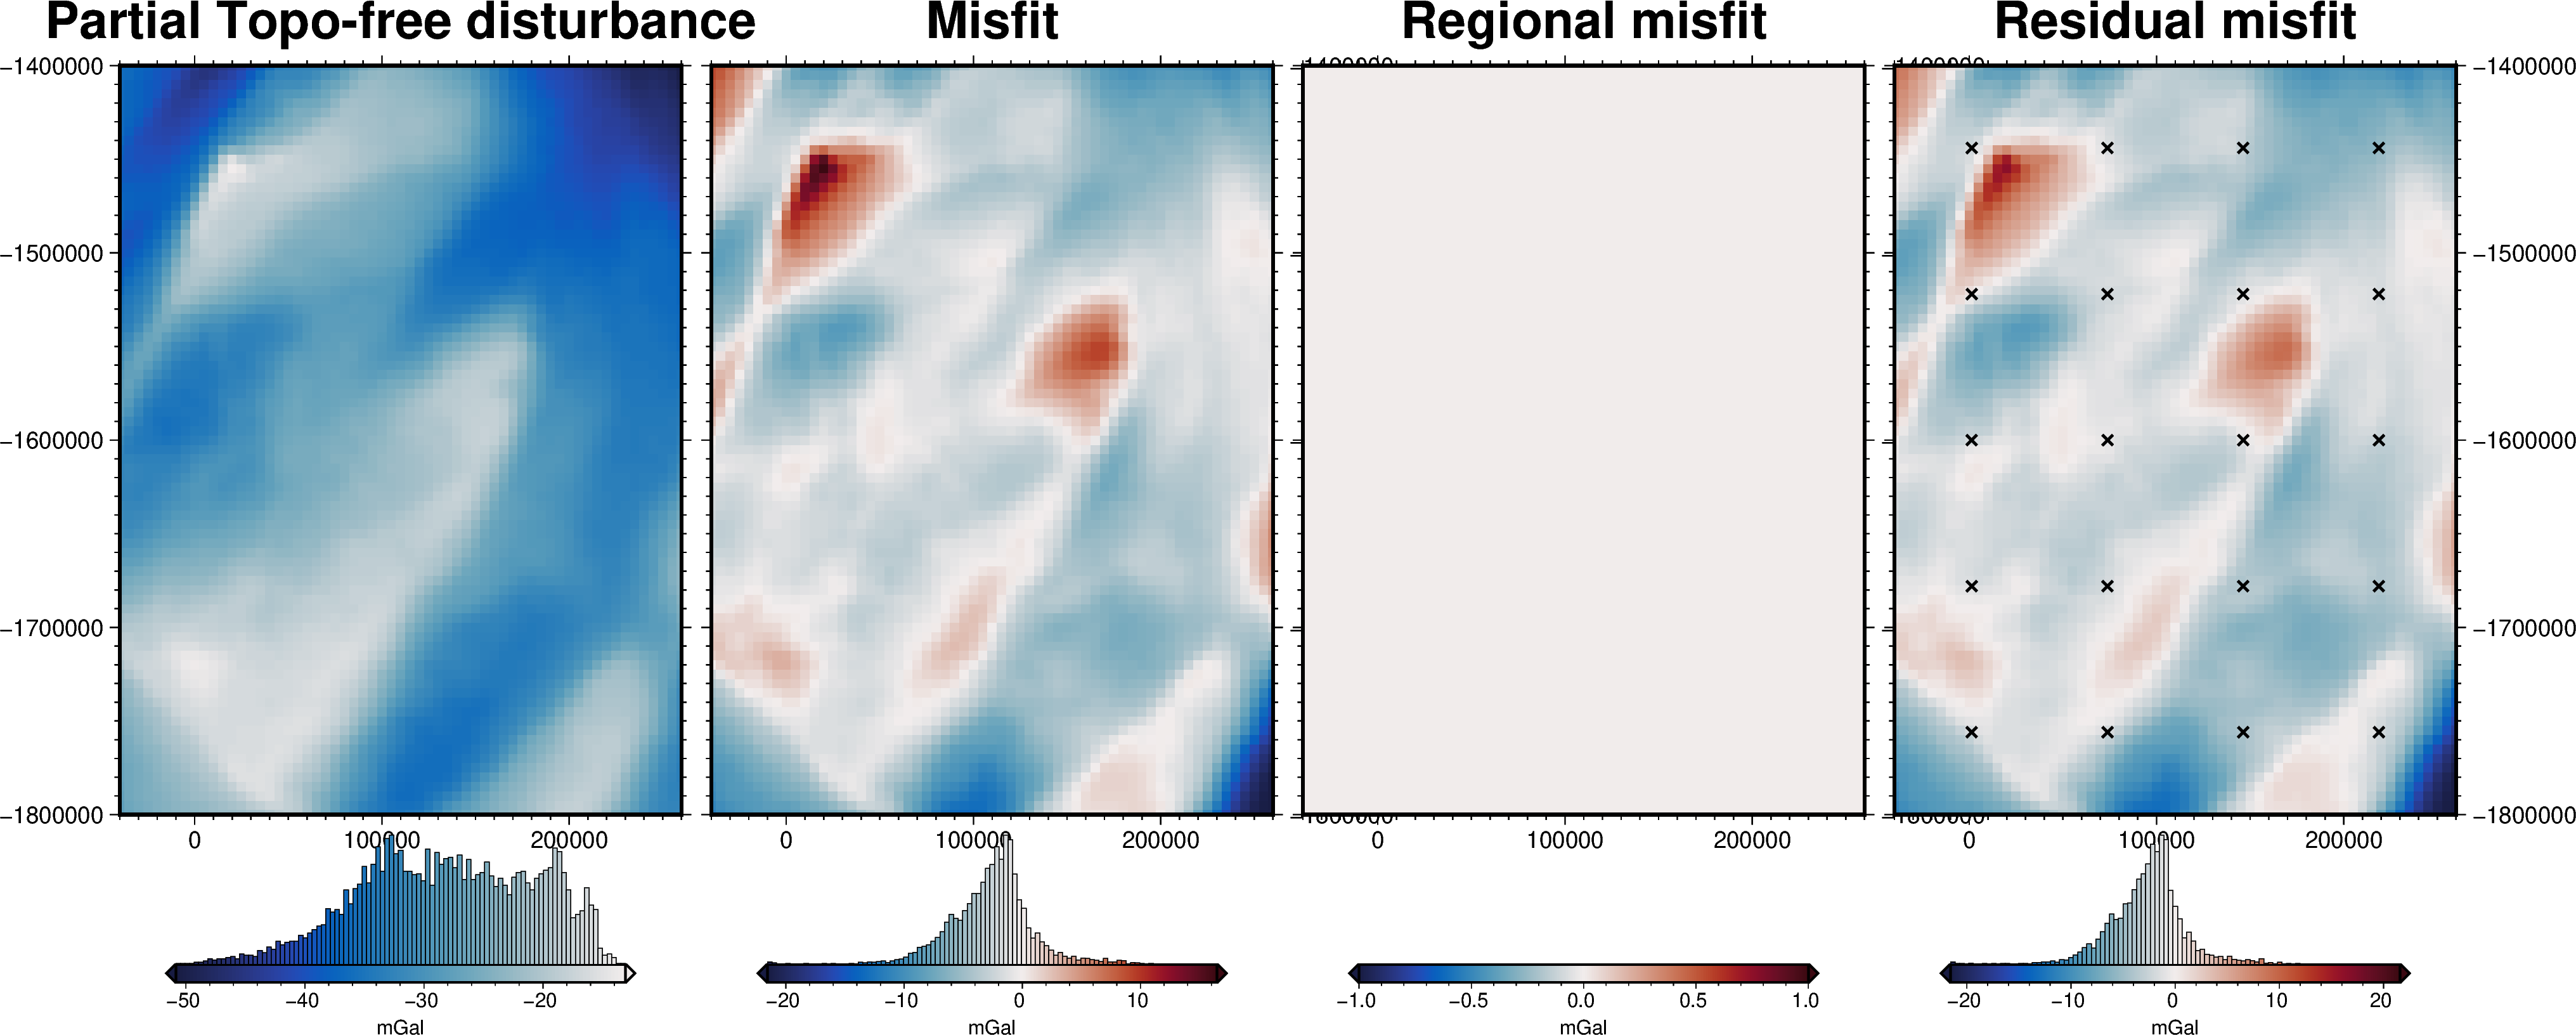

In [11]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)
fig.show()

In [10]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.2**0.5,  # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}

# Damping Cross Validation

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_02a_damping_cv'
INFO:invert4geom:running damping cross validation


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.02457795972125576}
INFO:invert4geom:	scores: [0.07733920264393157]
INFO:invert4geom:results saved to ../../results/Ross_Sea_02a_damping_cv_results.pickle.pickle


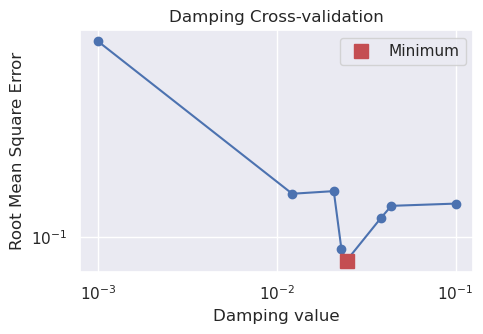

In [60]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    # for creating test/train splits
    grav_spacing=spacing,
    inversion_region=inversion_region,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    plot_cv=True,
    fname="../../results/Ross_Sea_03_damping_cv",
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [11]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_03_damping_cv_results.pickle").open(
    "rb"
) as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/Ross_Sea_03_damping_cv_damping_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [12]:
best_damping = parameters.get("Solver damping")
best_damping

0.02457795972125576

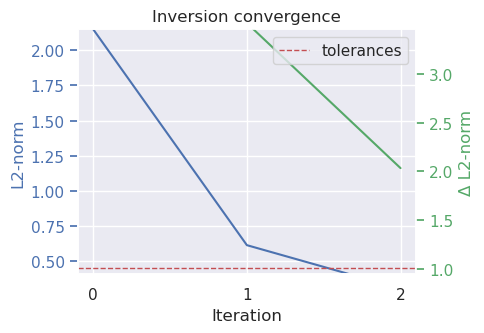

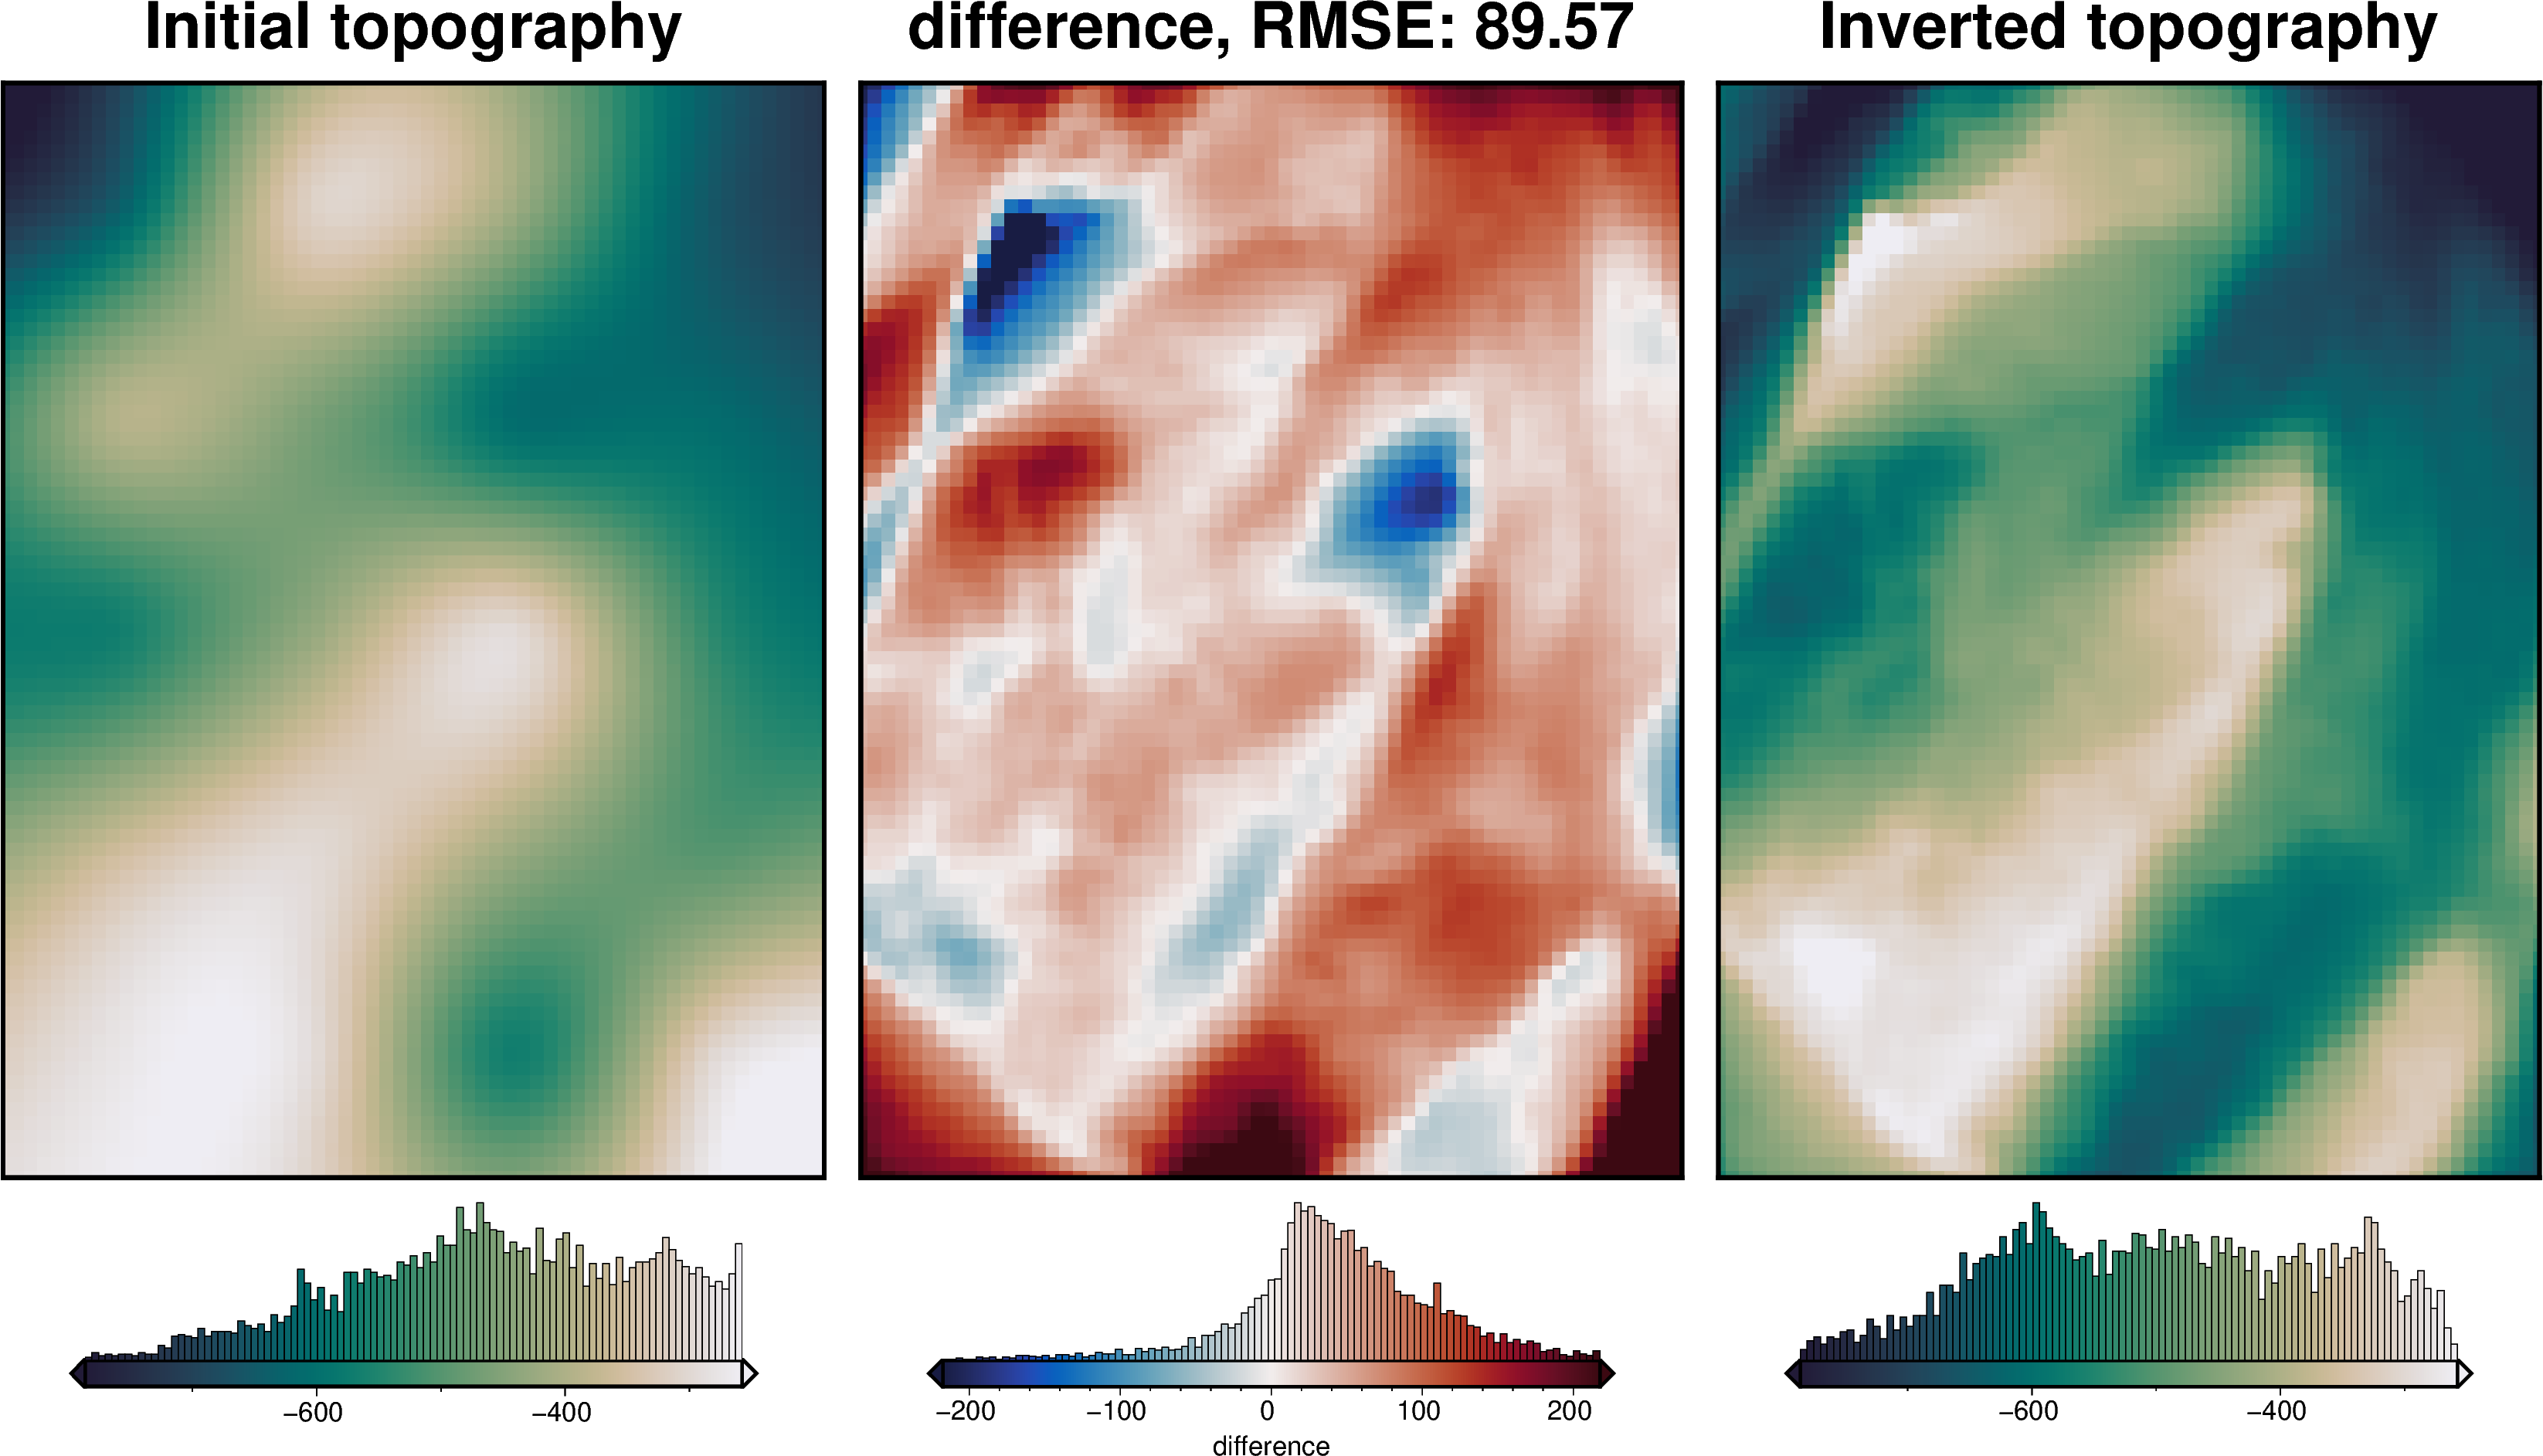

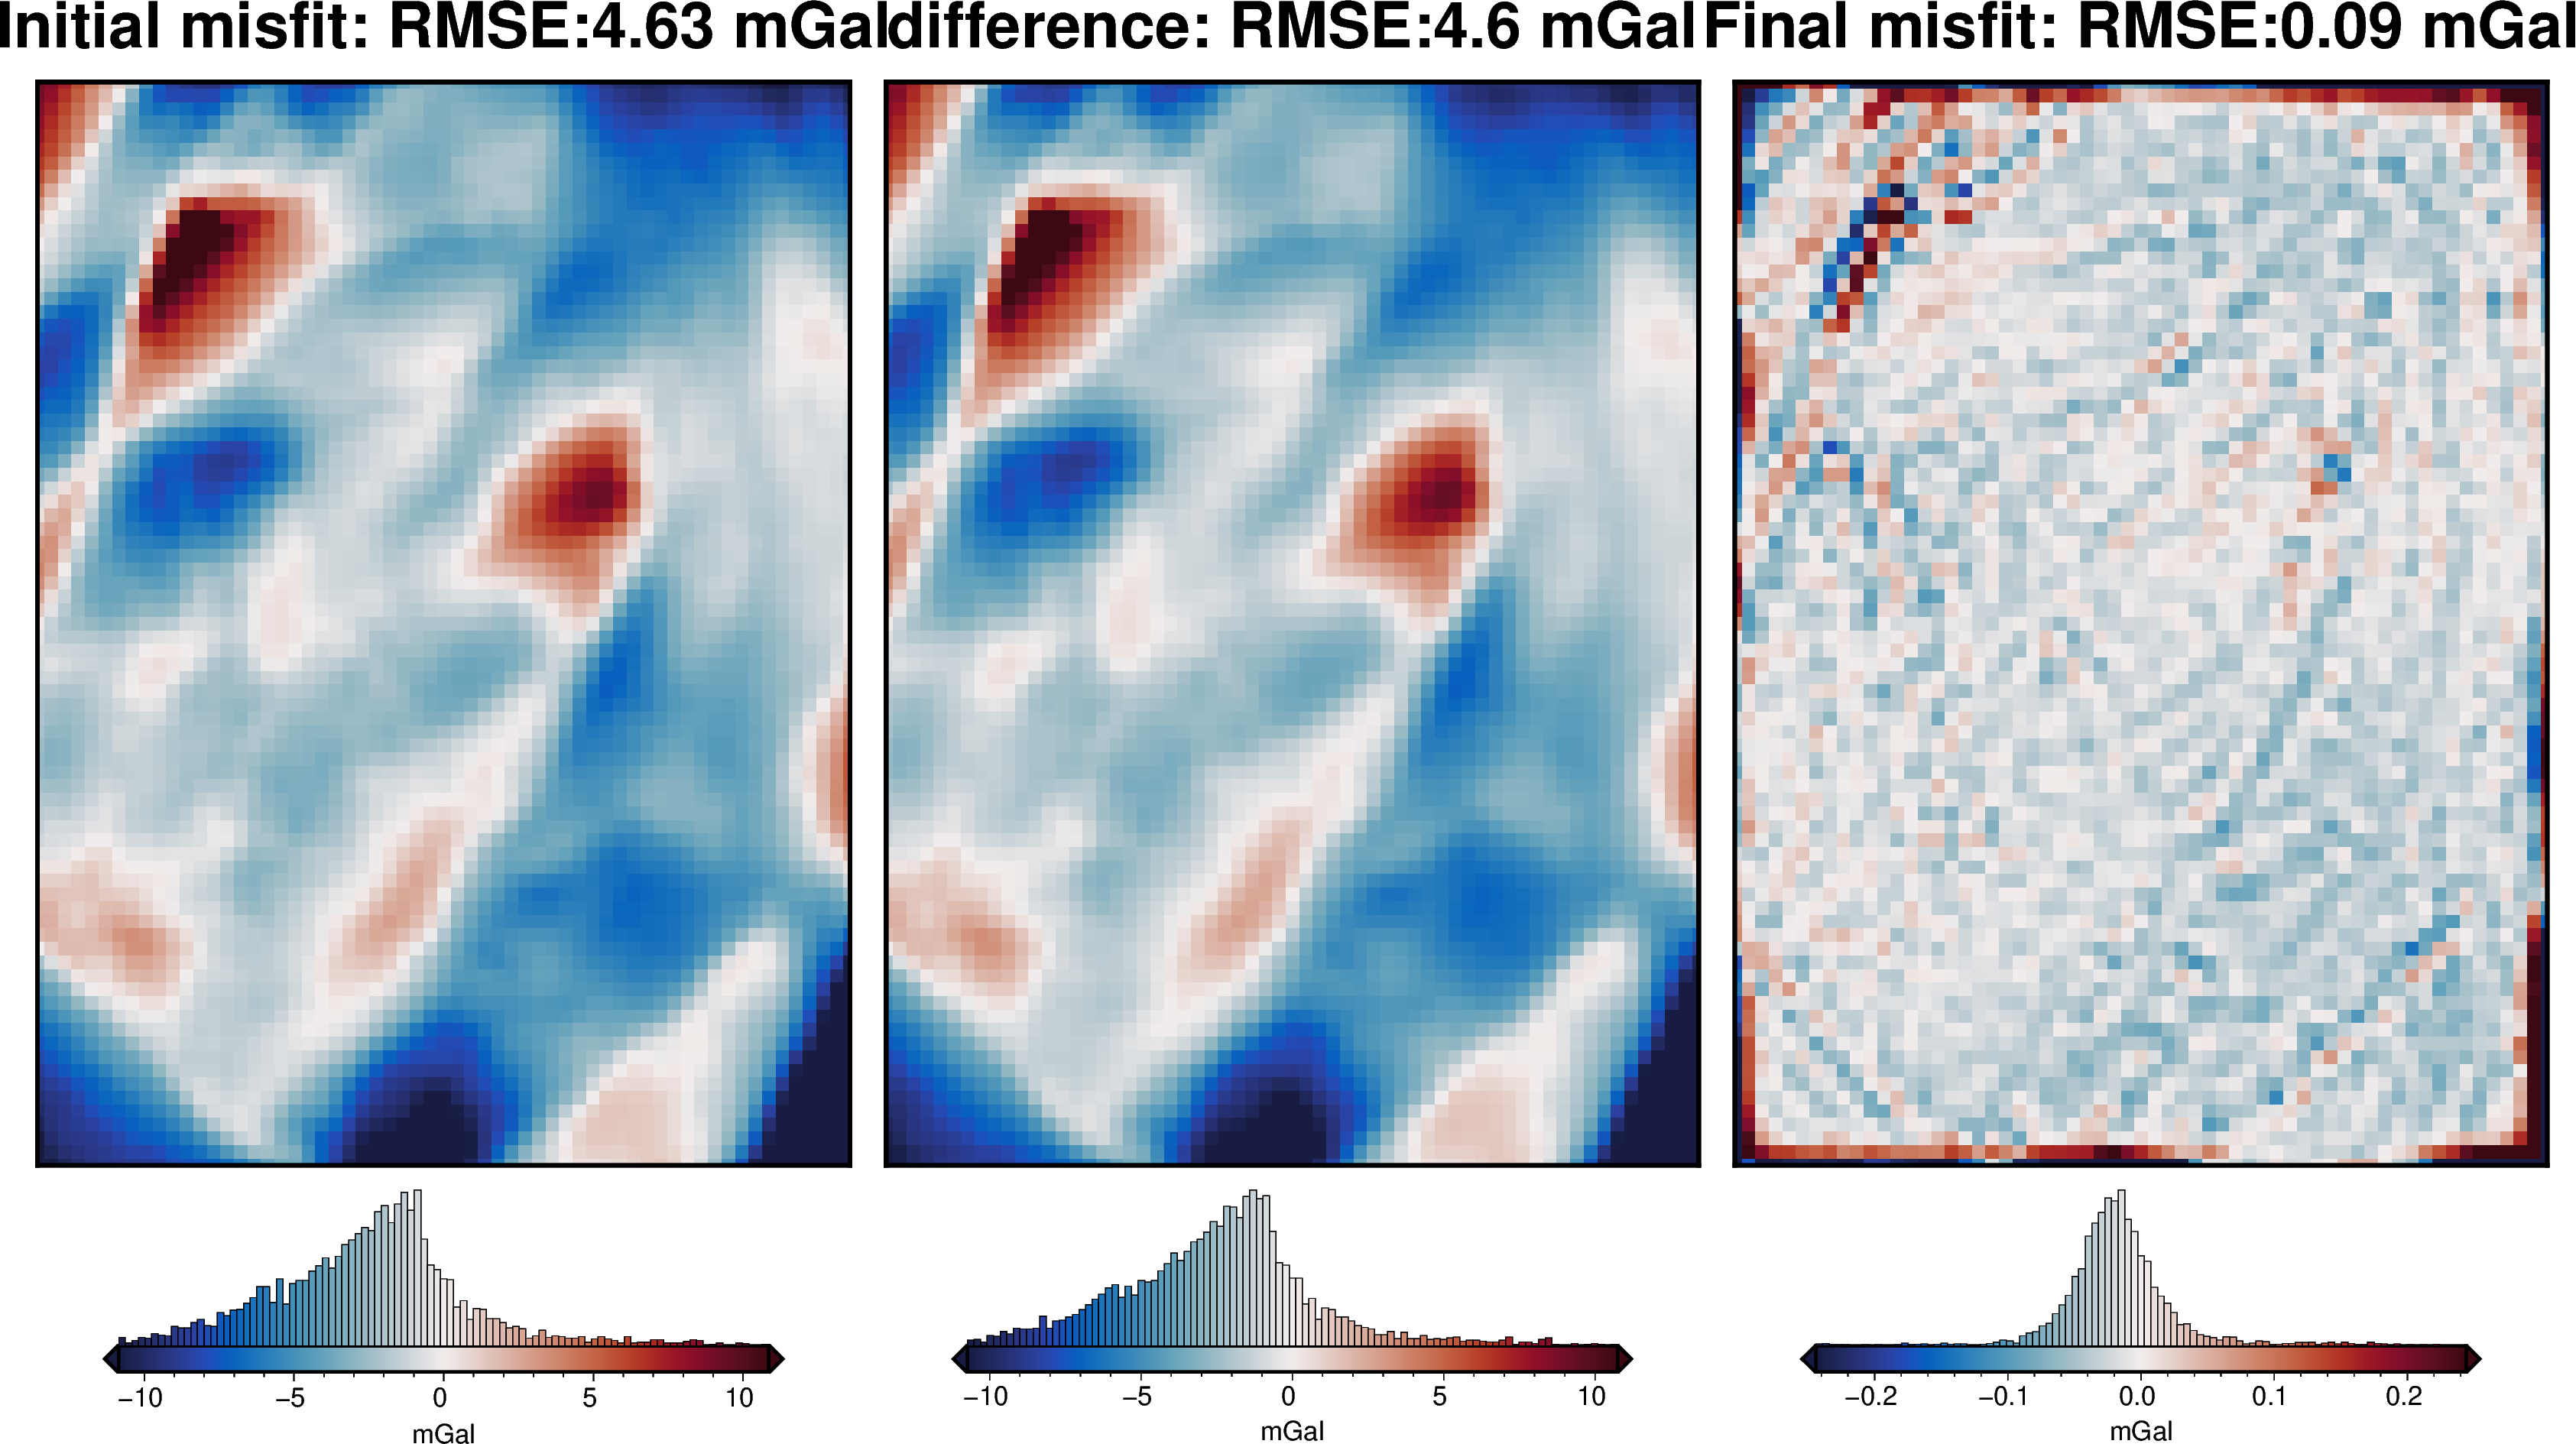

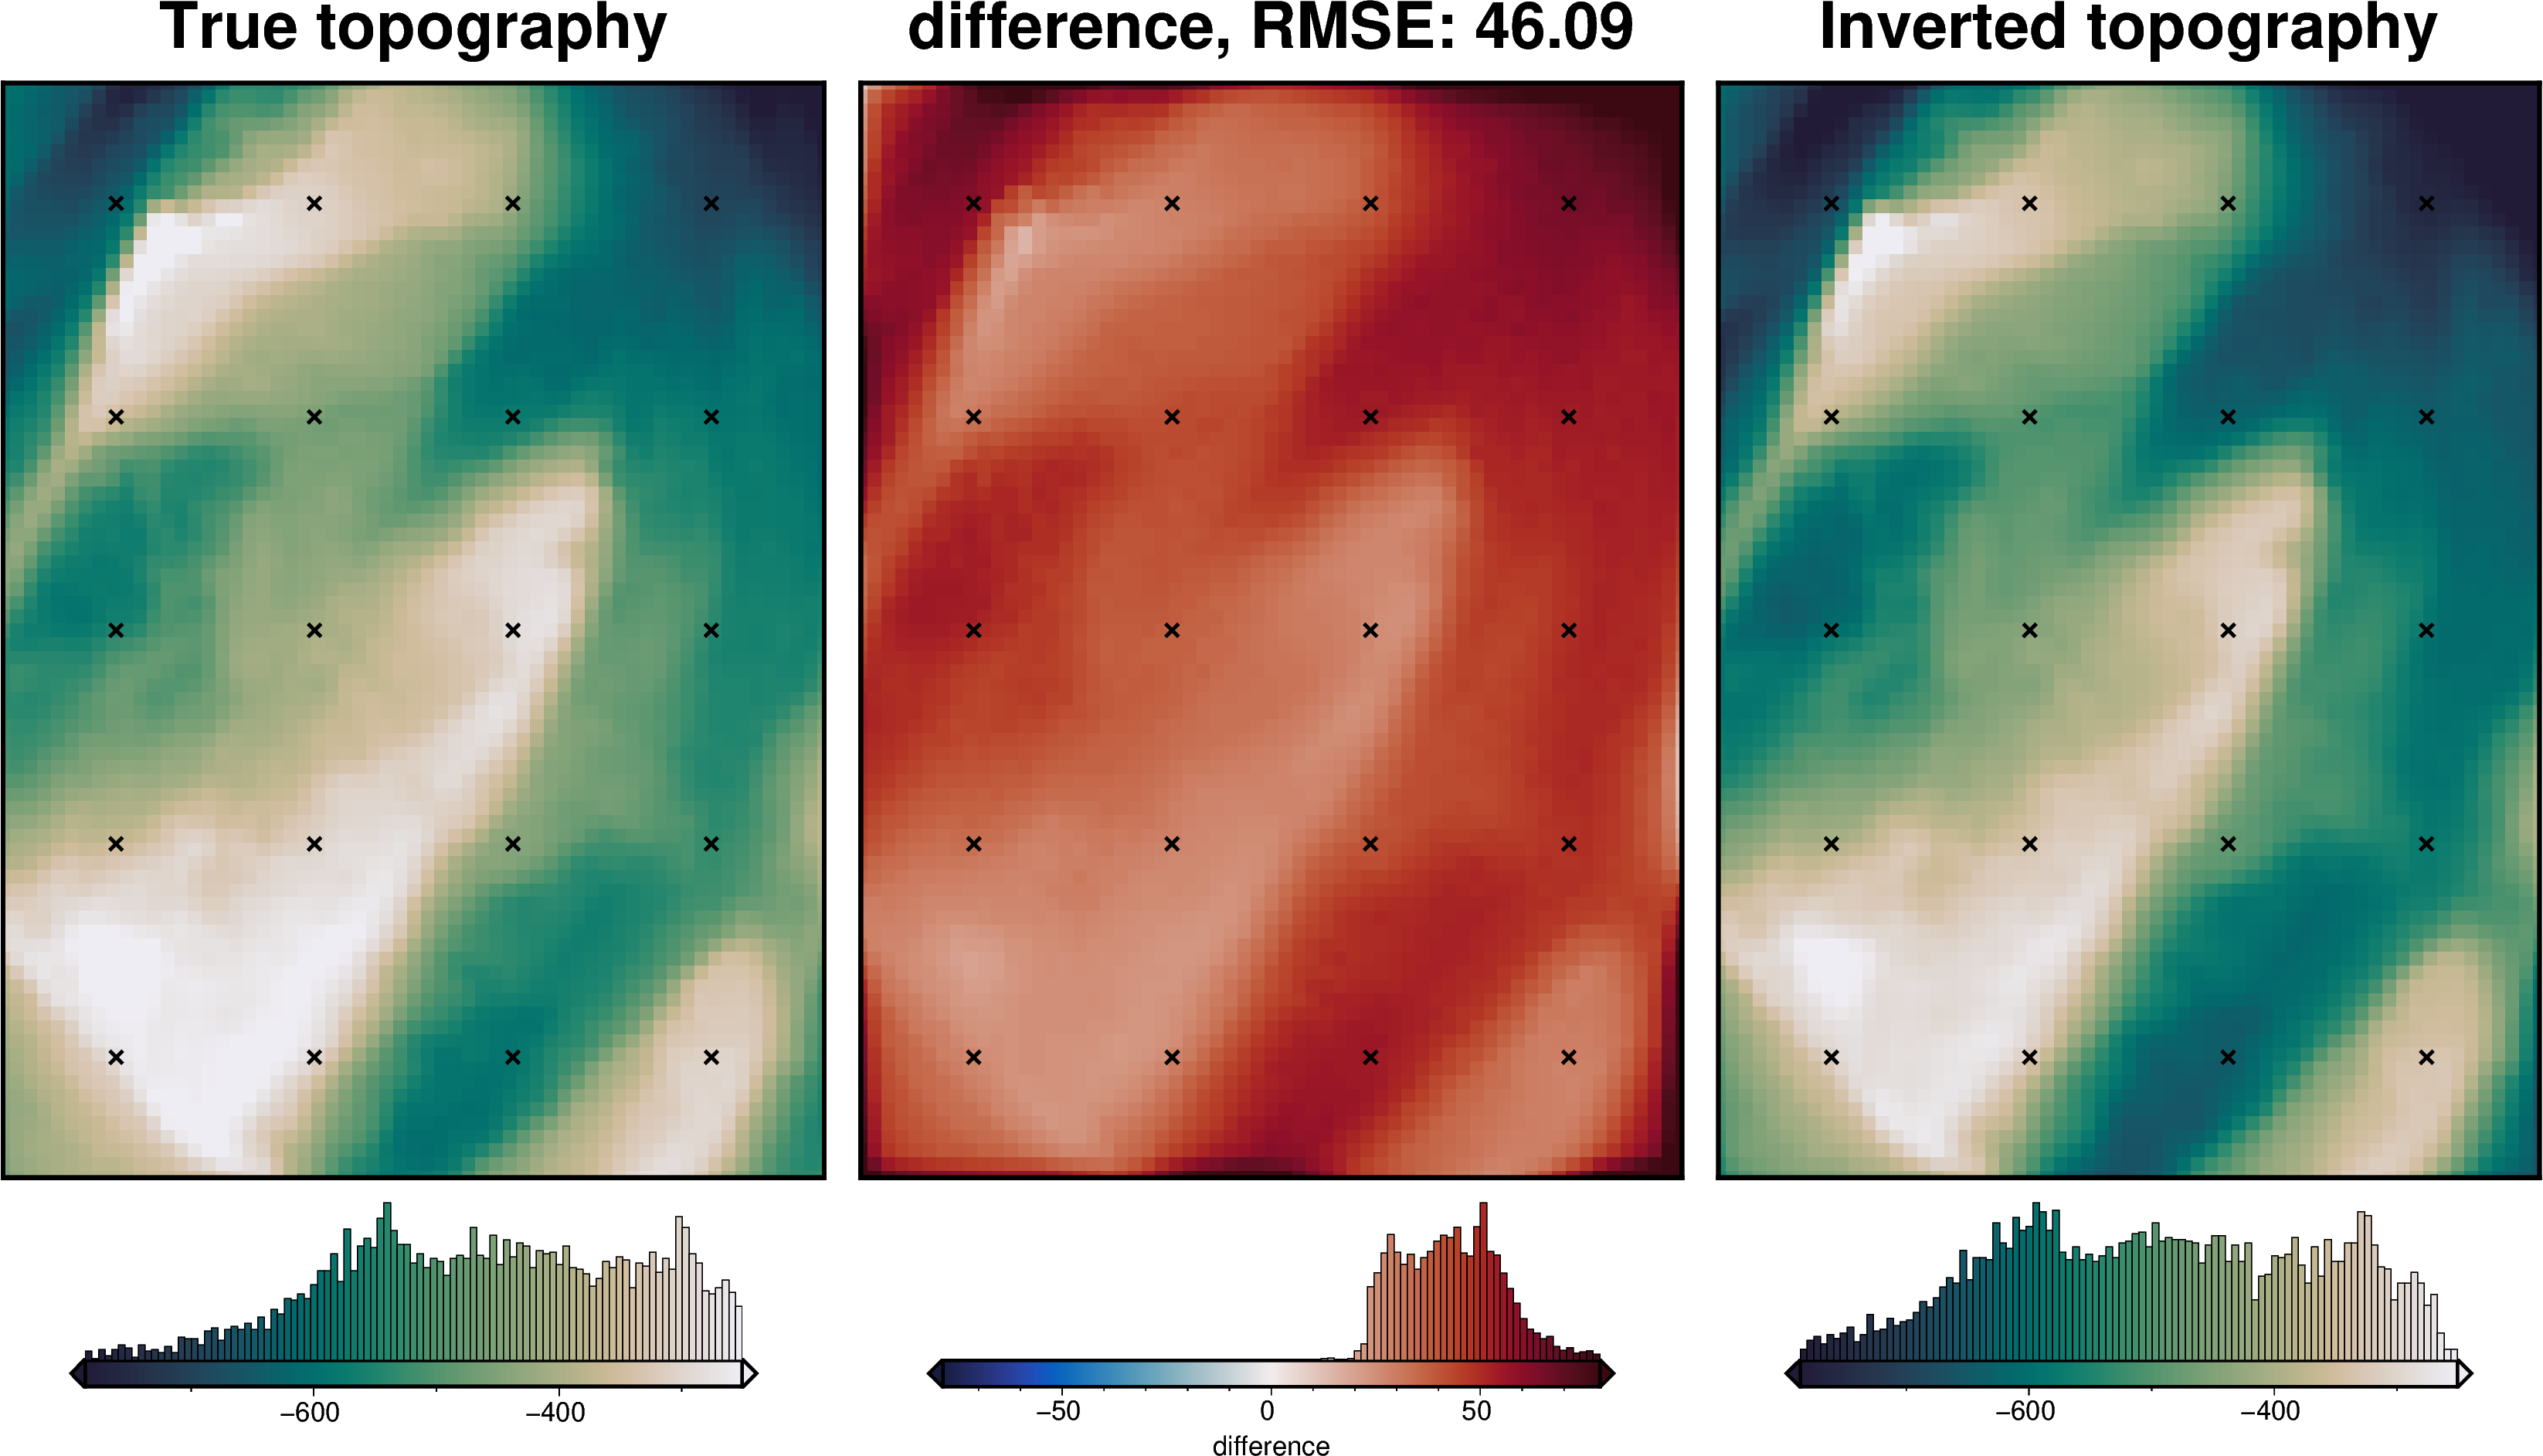

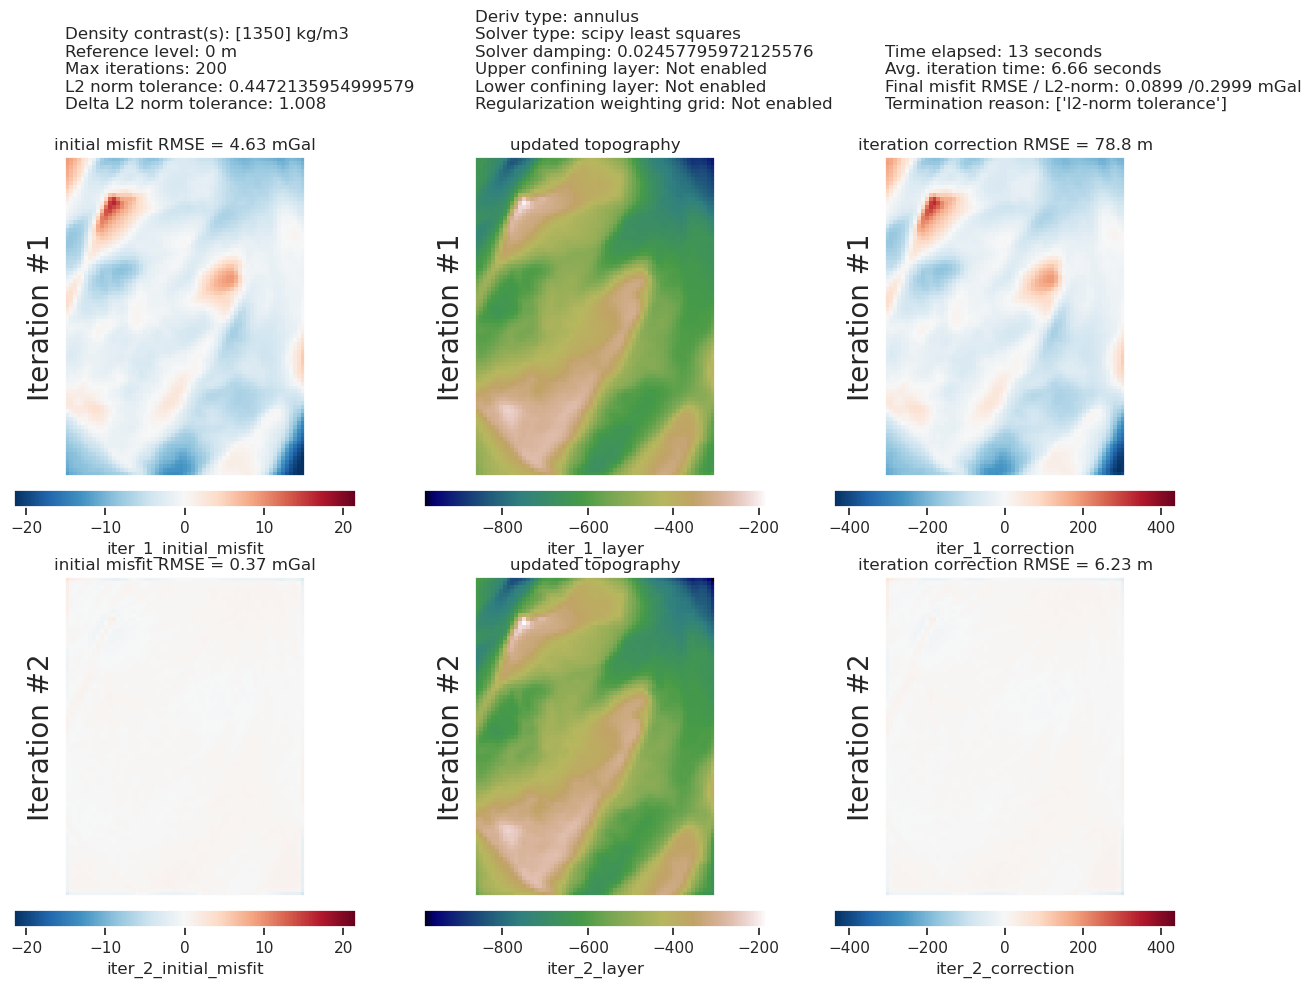

In [13]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [14]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 43.31 m


# Density CV

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_02a_density_cv'
INFO:invert4geom:running zref and/or density contrast cross validation


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 8
INFO:invert4geom:	parameter: {'density_contrast': 1470.1164840004974}
INFO:invert4geom:	scores: [19.80742644623075]
INFO:invert4geom:results saved to ../../results/Ross_Sea_02a_density_cv_results.pickle


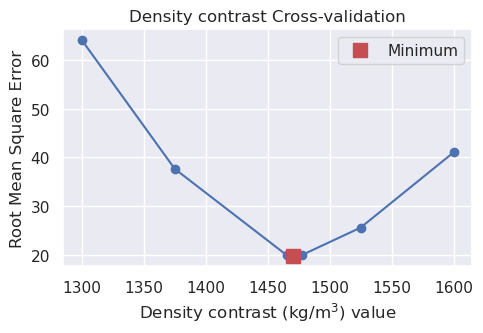

In [65]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    solver_damping=best_damping,
    starting_topography=starting_bathymetry,
    starting_prisms=starting_prisms,
    zref=0,
    calculate_regional_misfit=True,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    run_zref_or_density_cv=True,
    constraints_df=constraint_points,
    density_contrast_limits=(1300, 1600),
    zref_density_cv_trials=10,
    plot_cv=True,
    fname="../../results/Ross_Sea_03_density_cv",
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [16]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_03_density_cv_results.pickle").open(
    "rb"
) as f:
    results = pickle.load(f)

# load study
with pathlib.Path(
    "../../results/Ross_Sea_03_density_cv_zref_density_cv_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [17]:
best_density_contrast = study.best_params["density_contrast"]
print("optimal determined density contrast", best_density_contrast)
print("real density contrast", true_density_contrast)

optimal determined density contrast 1470.1164840004974
real density contrast 1476


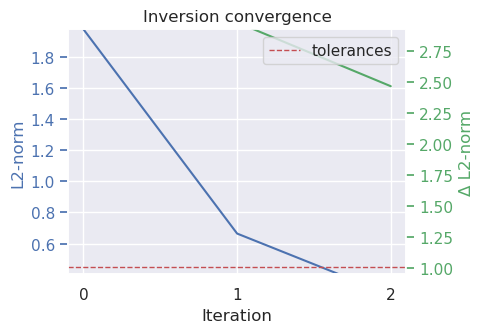

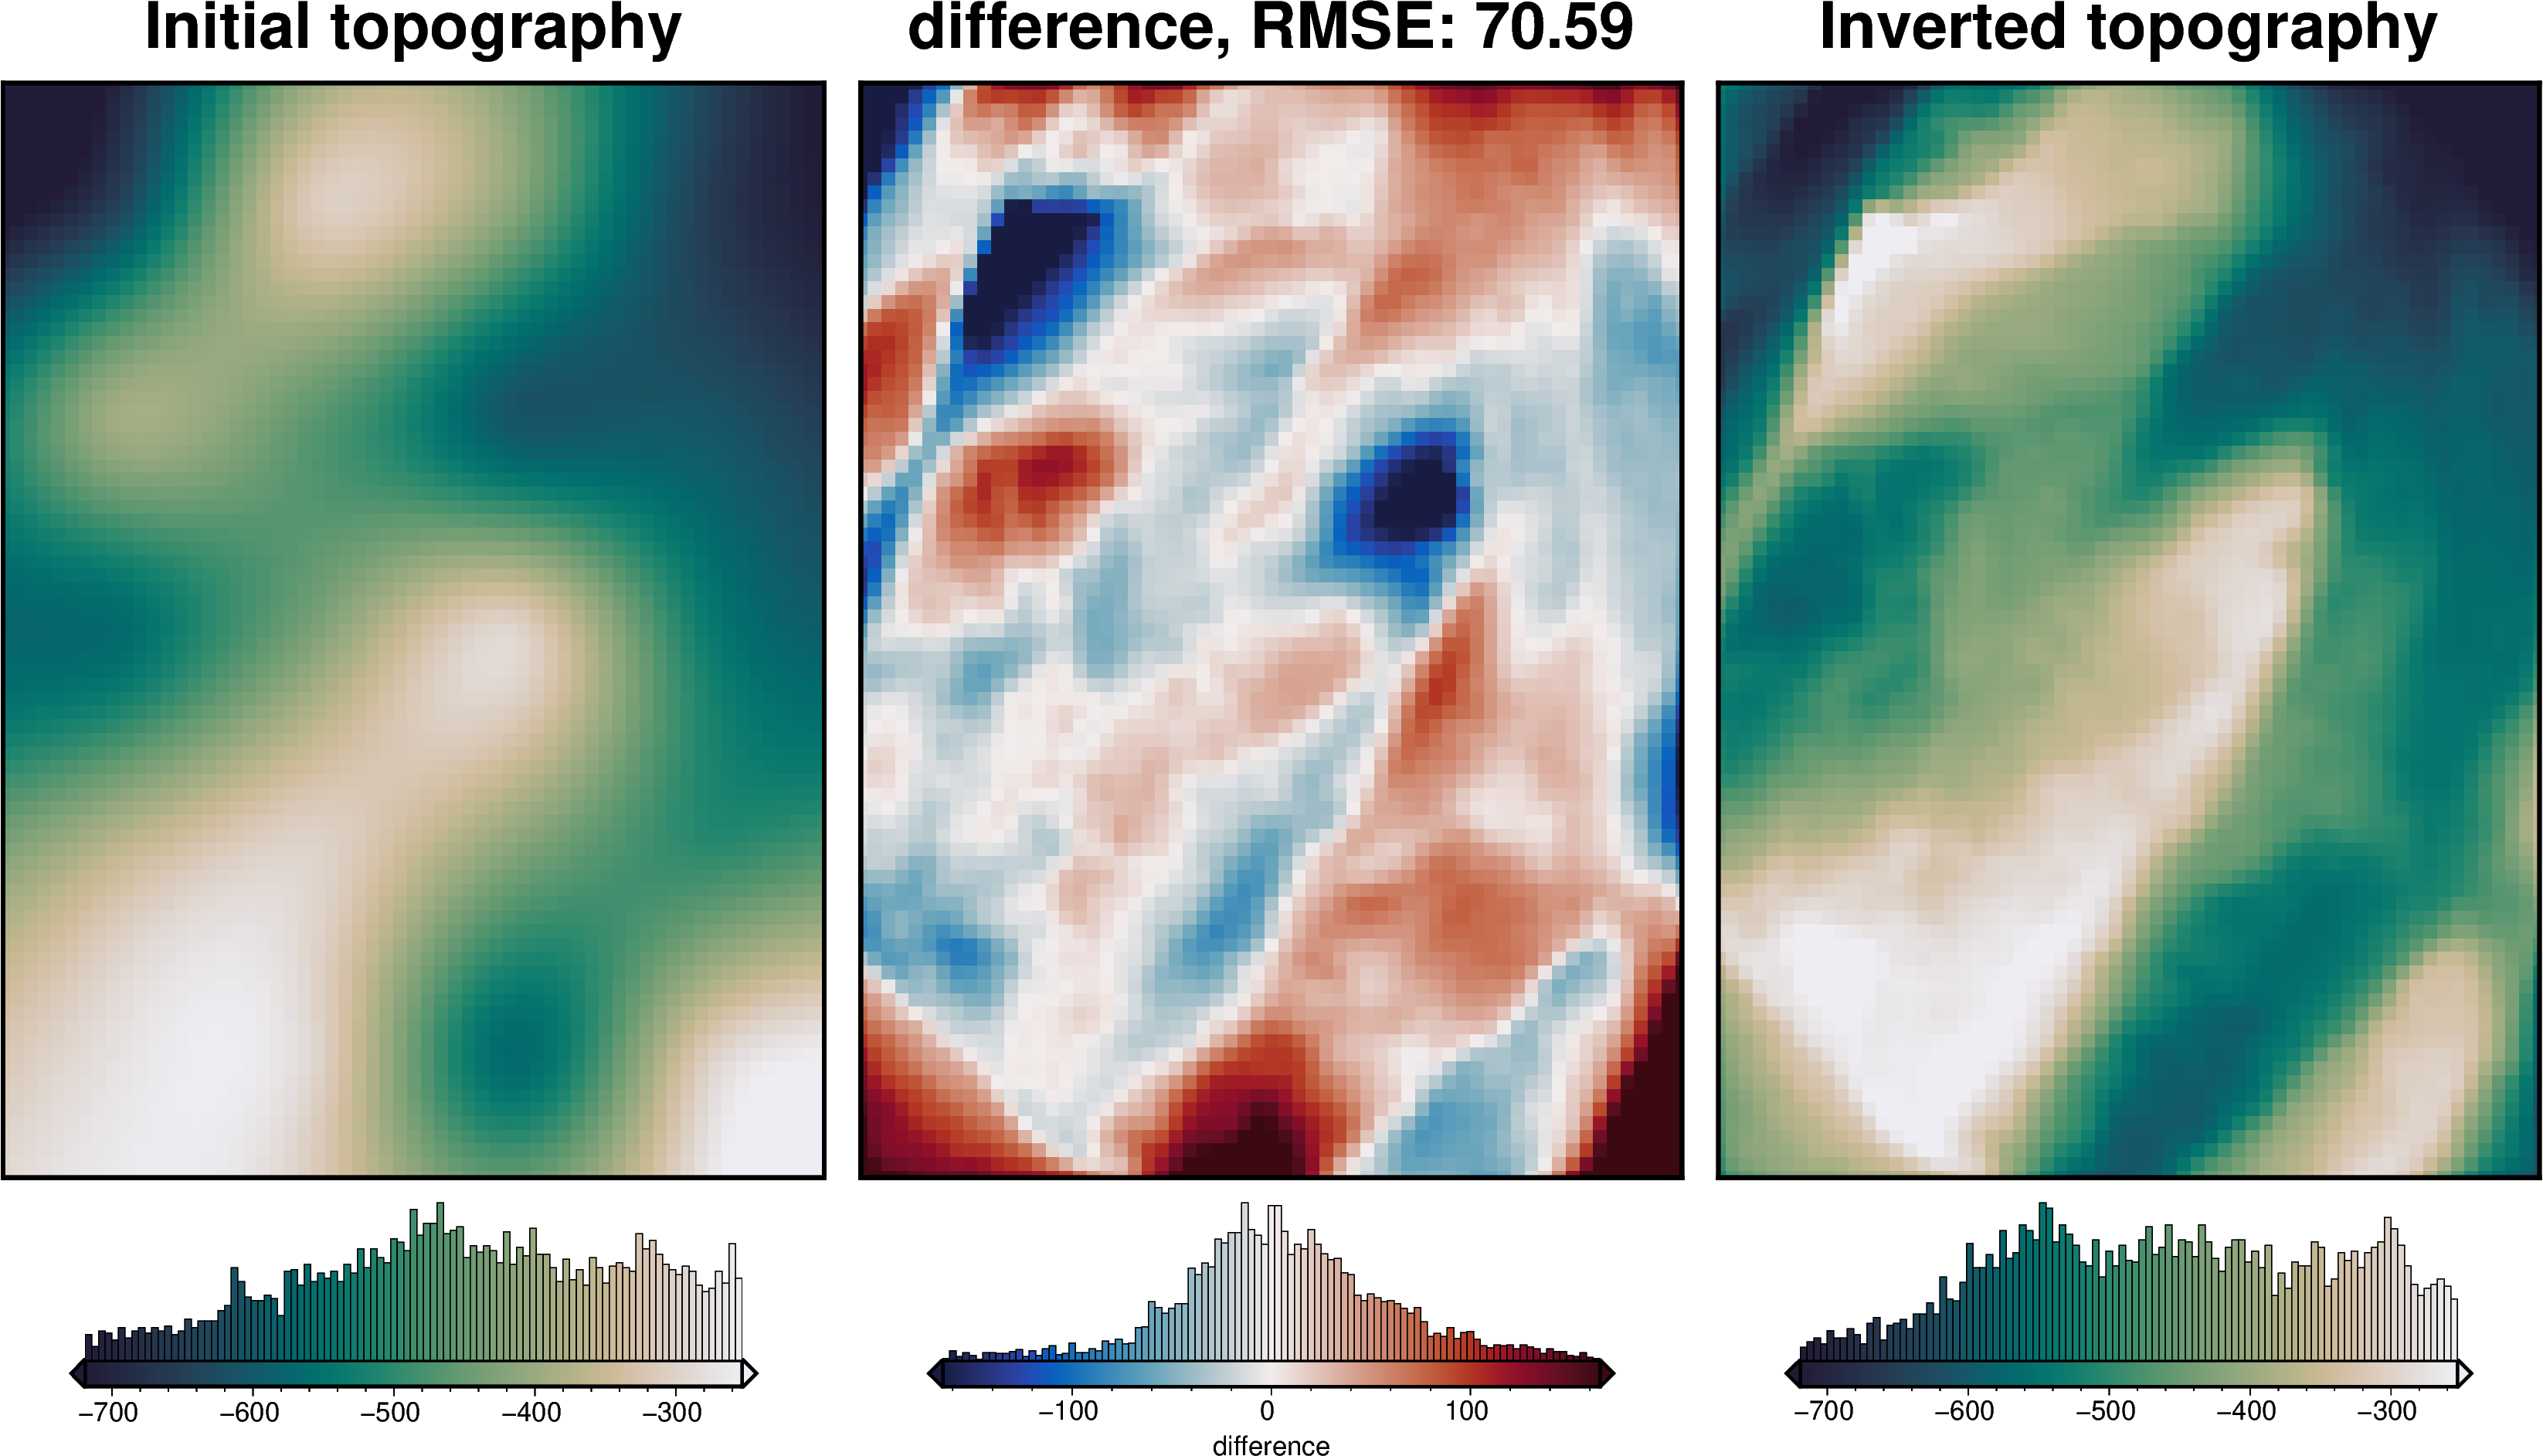

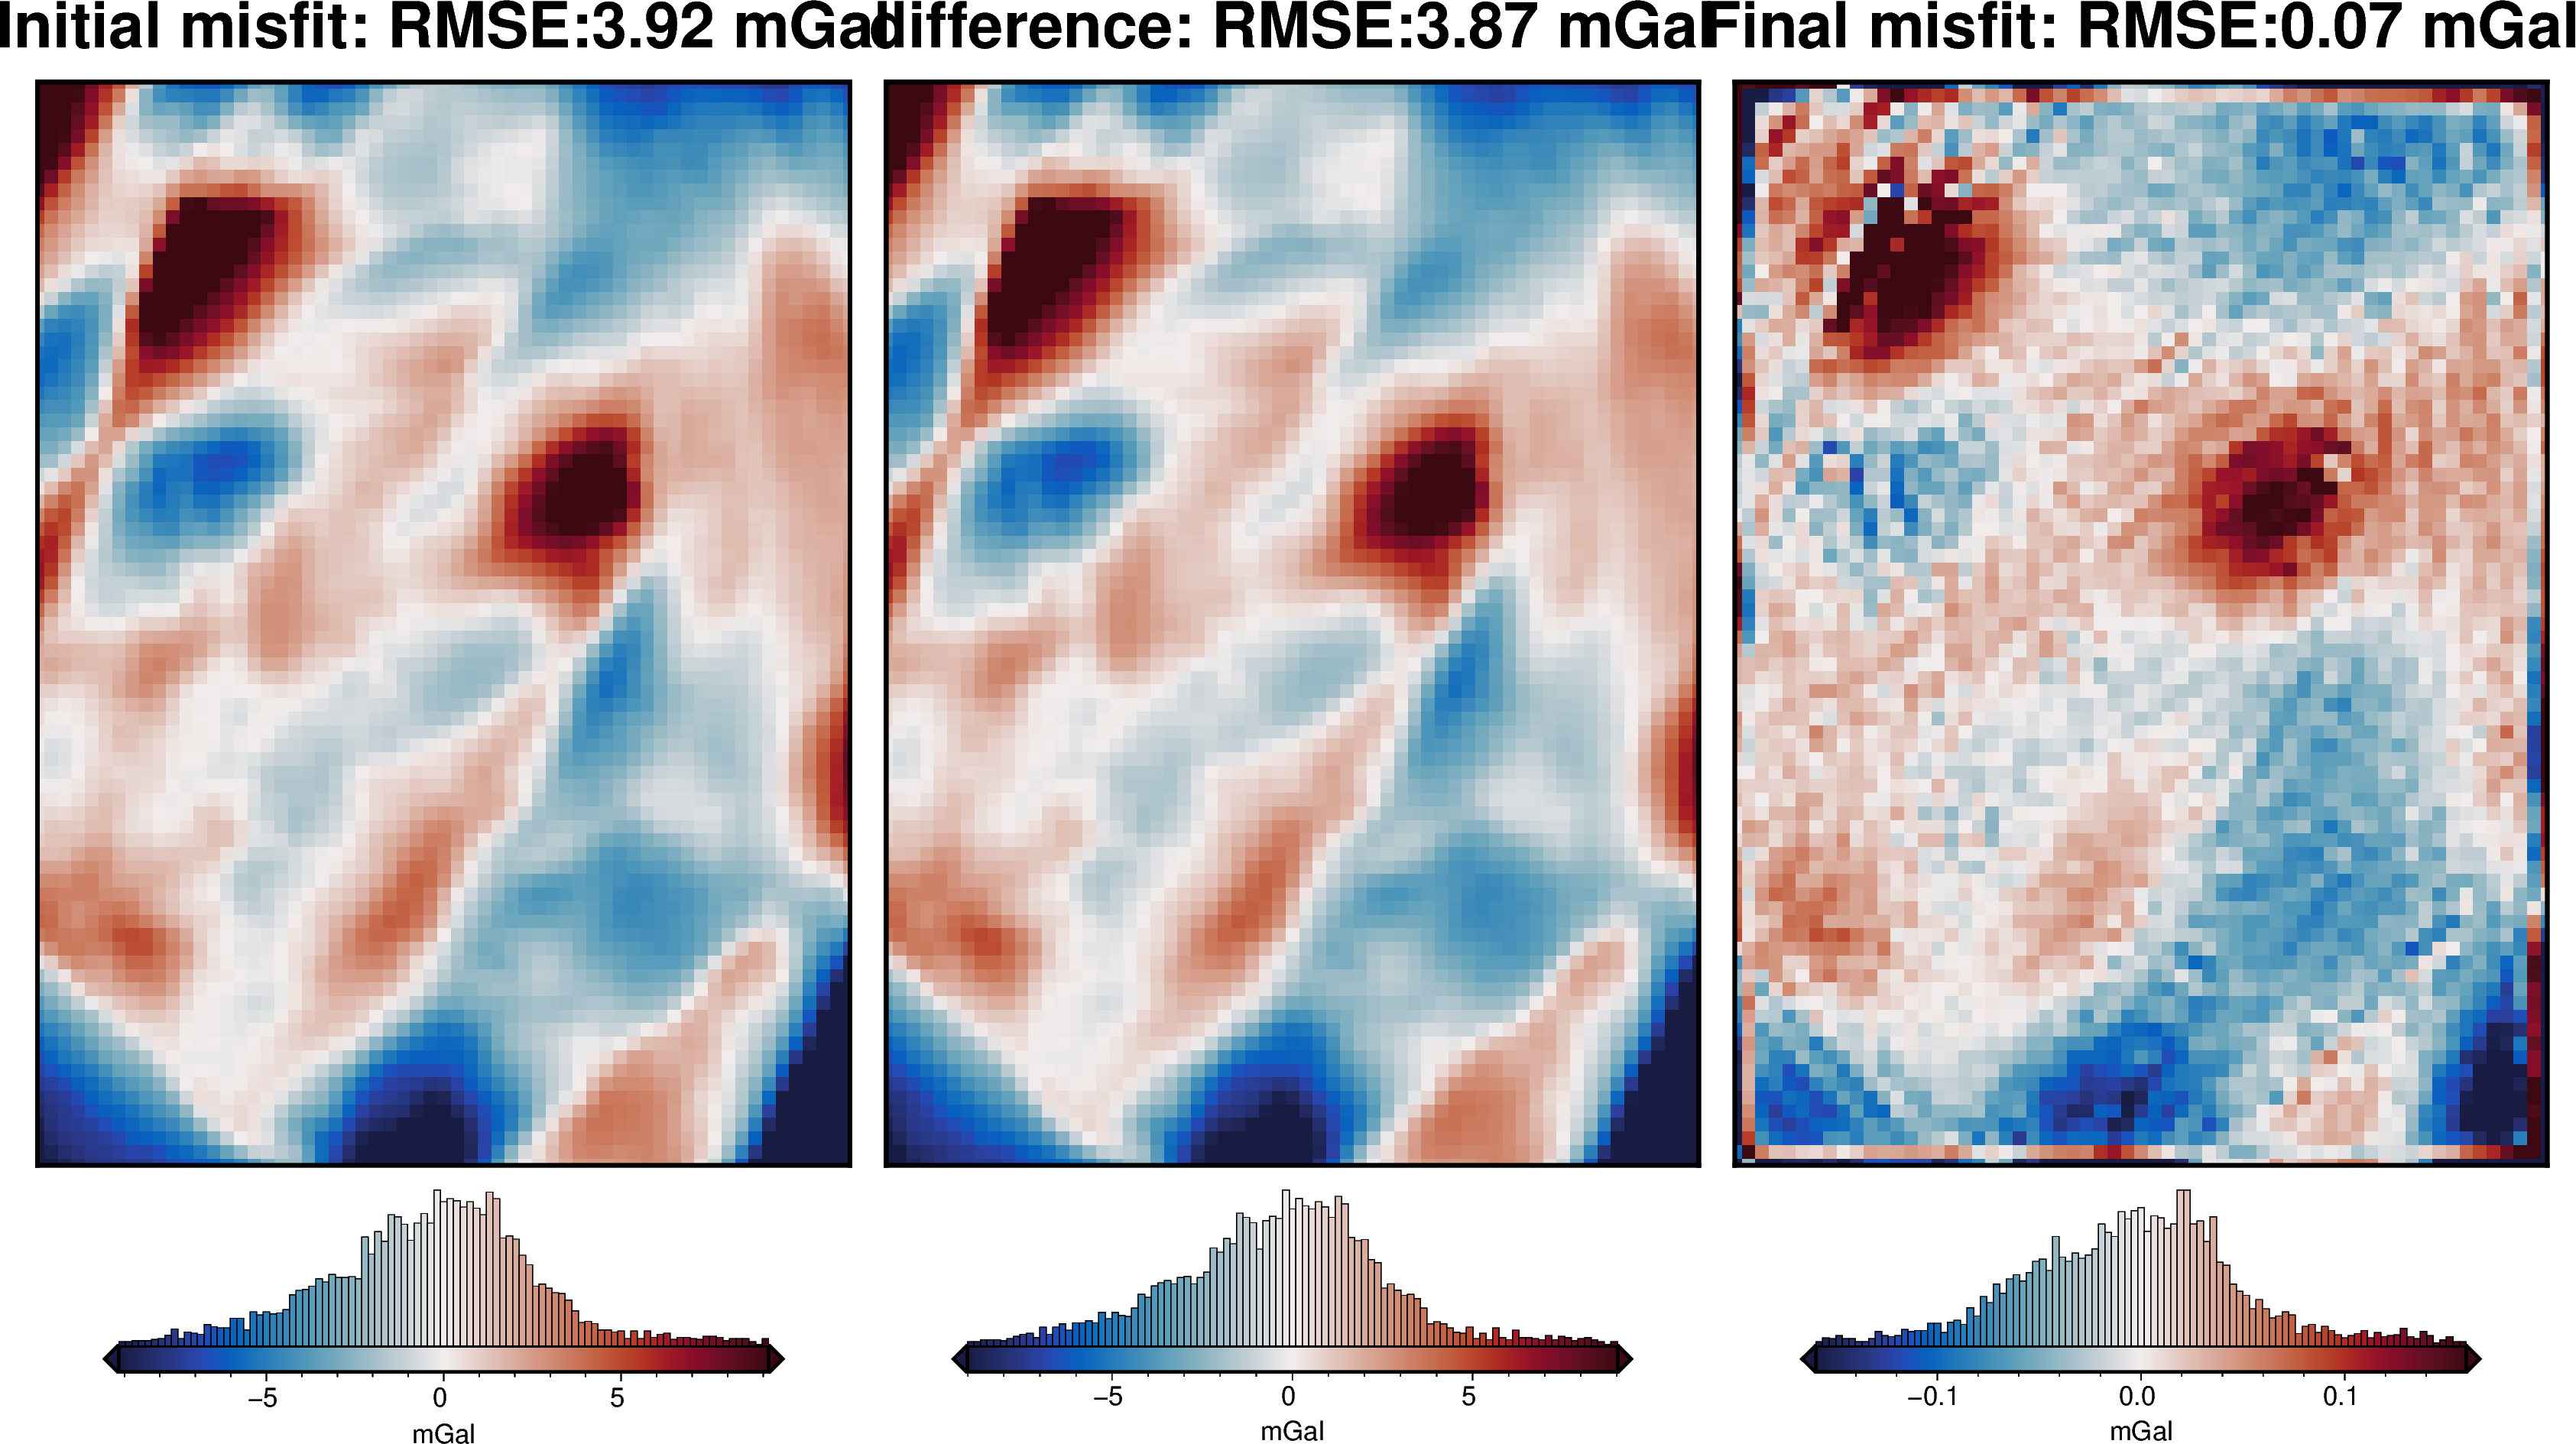

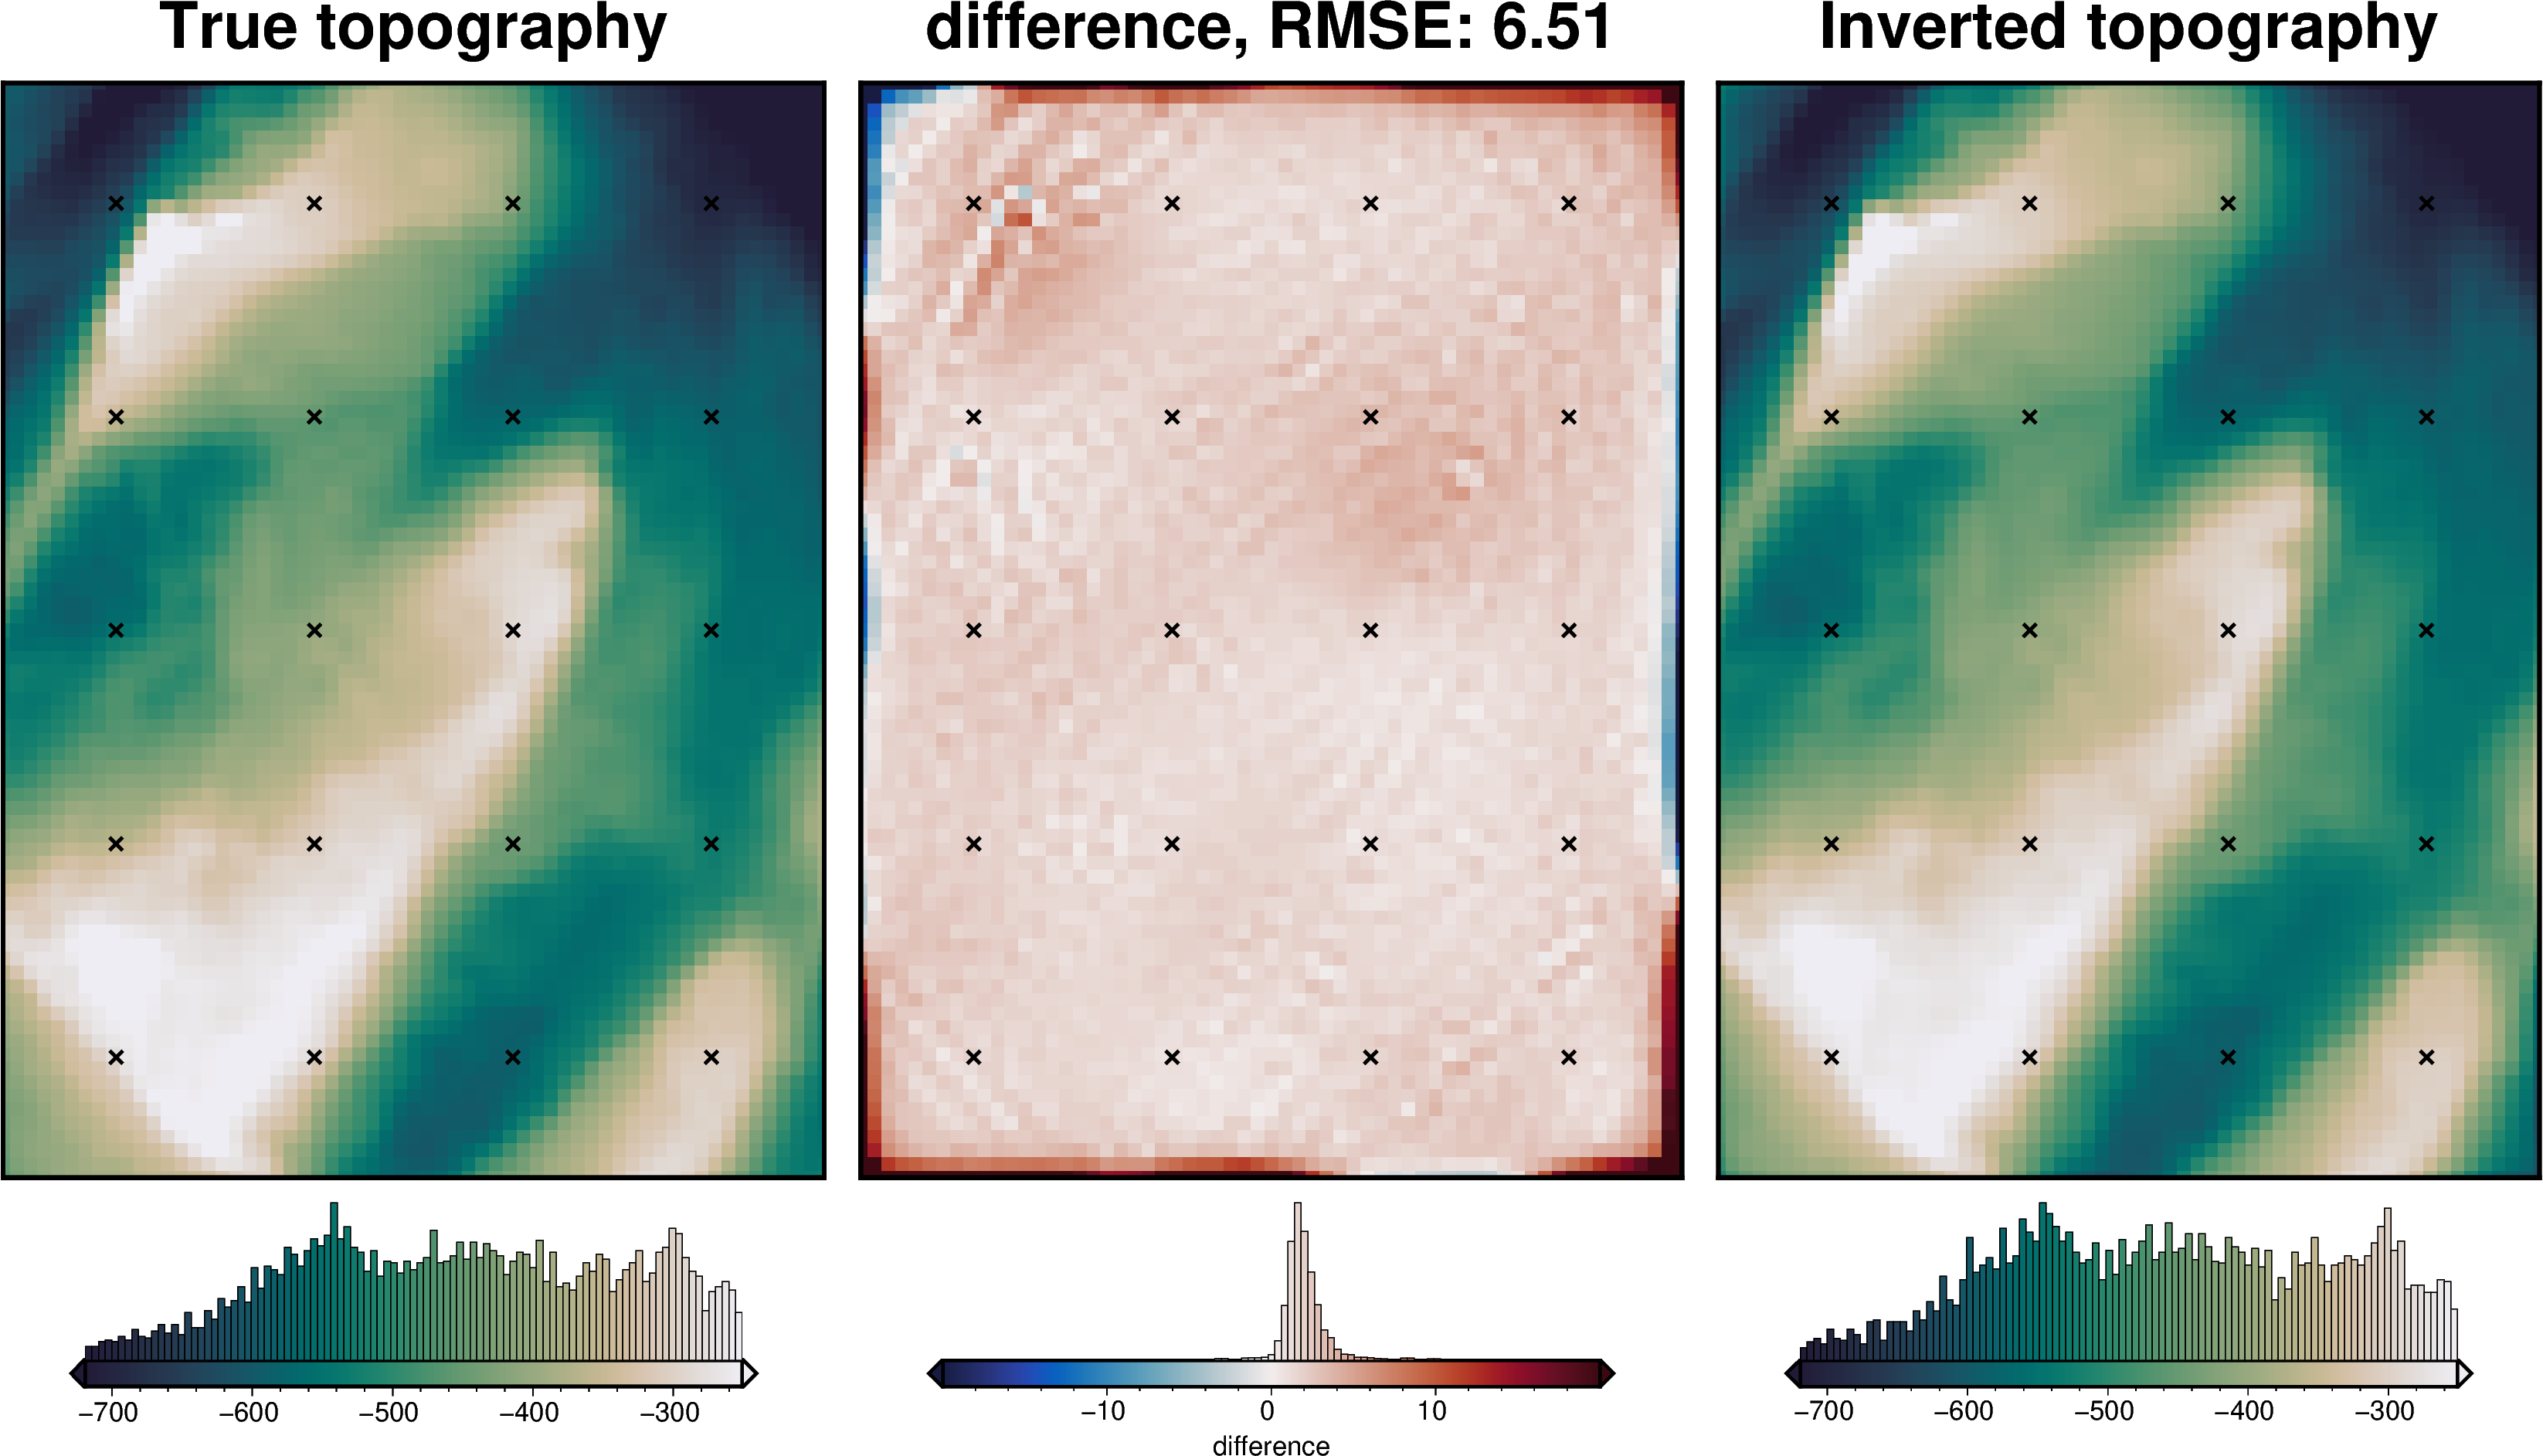

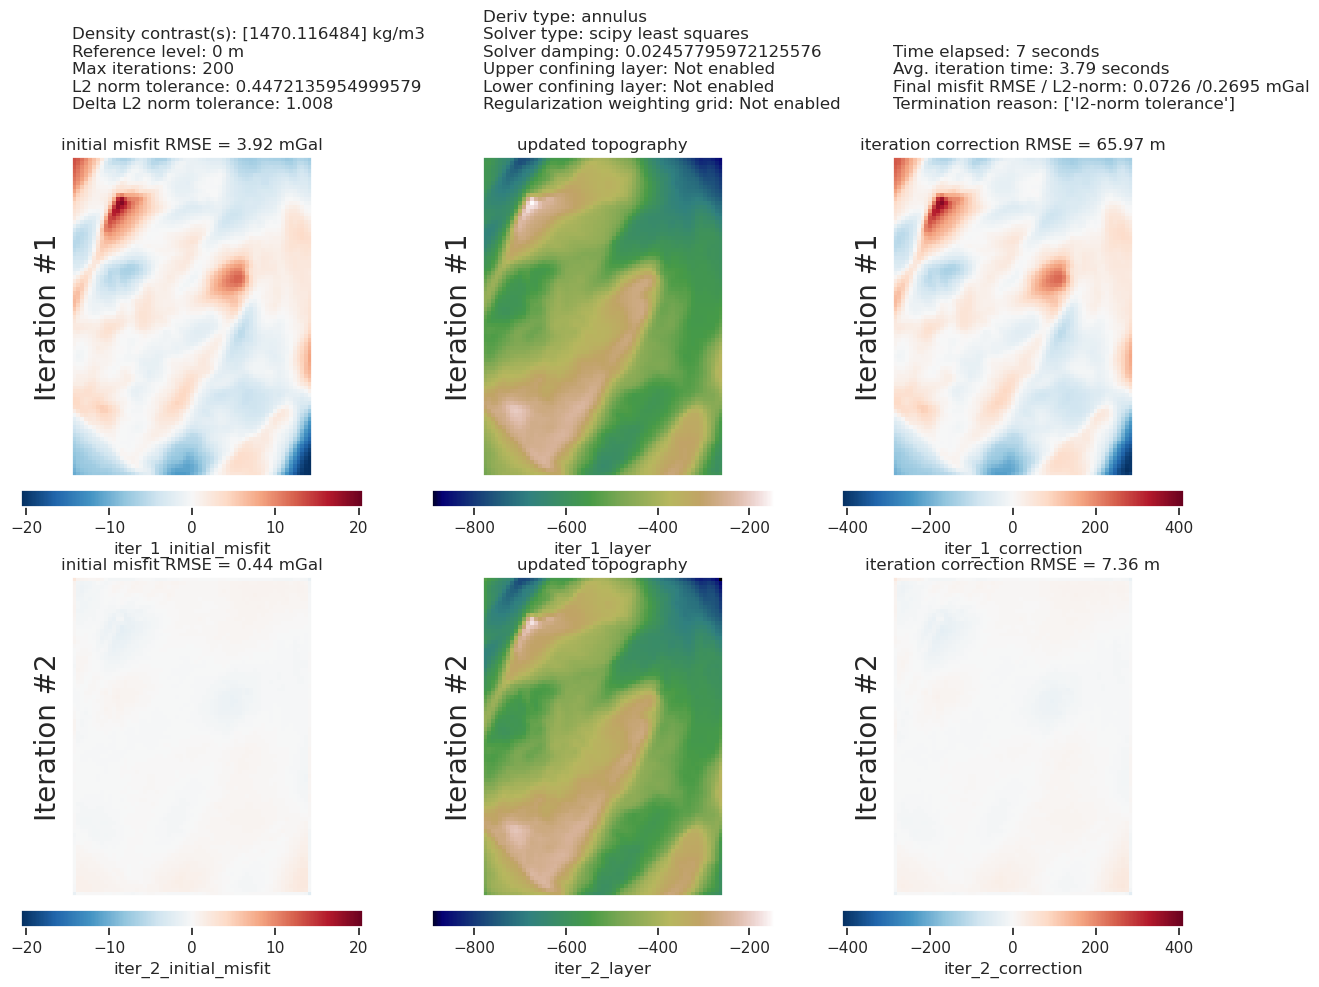

In [18]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [19]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 2.09 m


In [20]:
# save to csv
constraint_points.to_csv("../../results/Ross_Sea_03_constraint_points.csv", index=False)

# Uncertainty analysis

## Inversion error

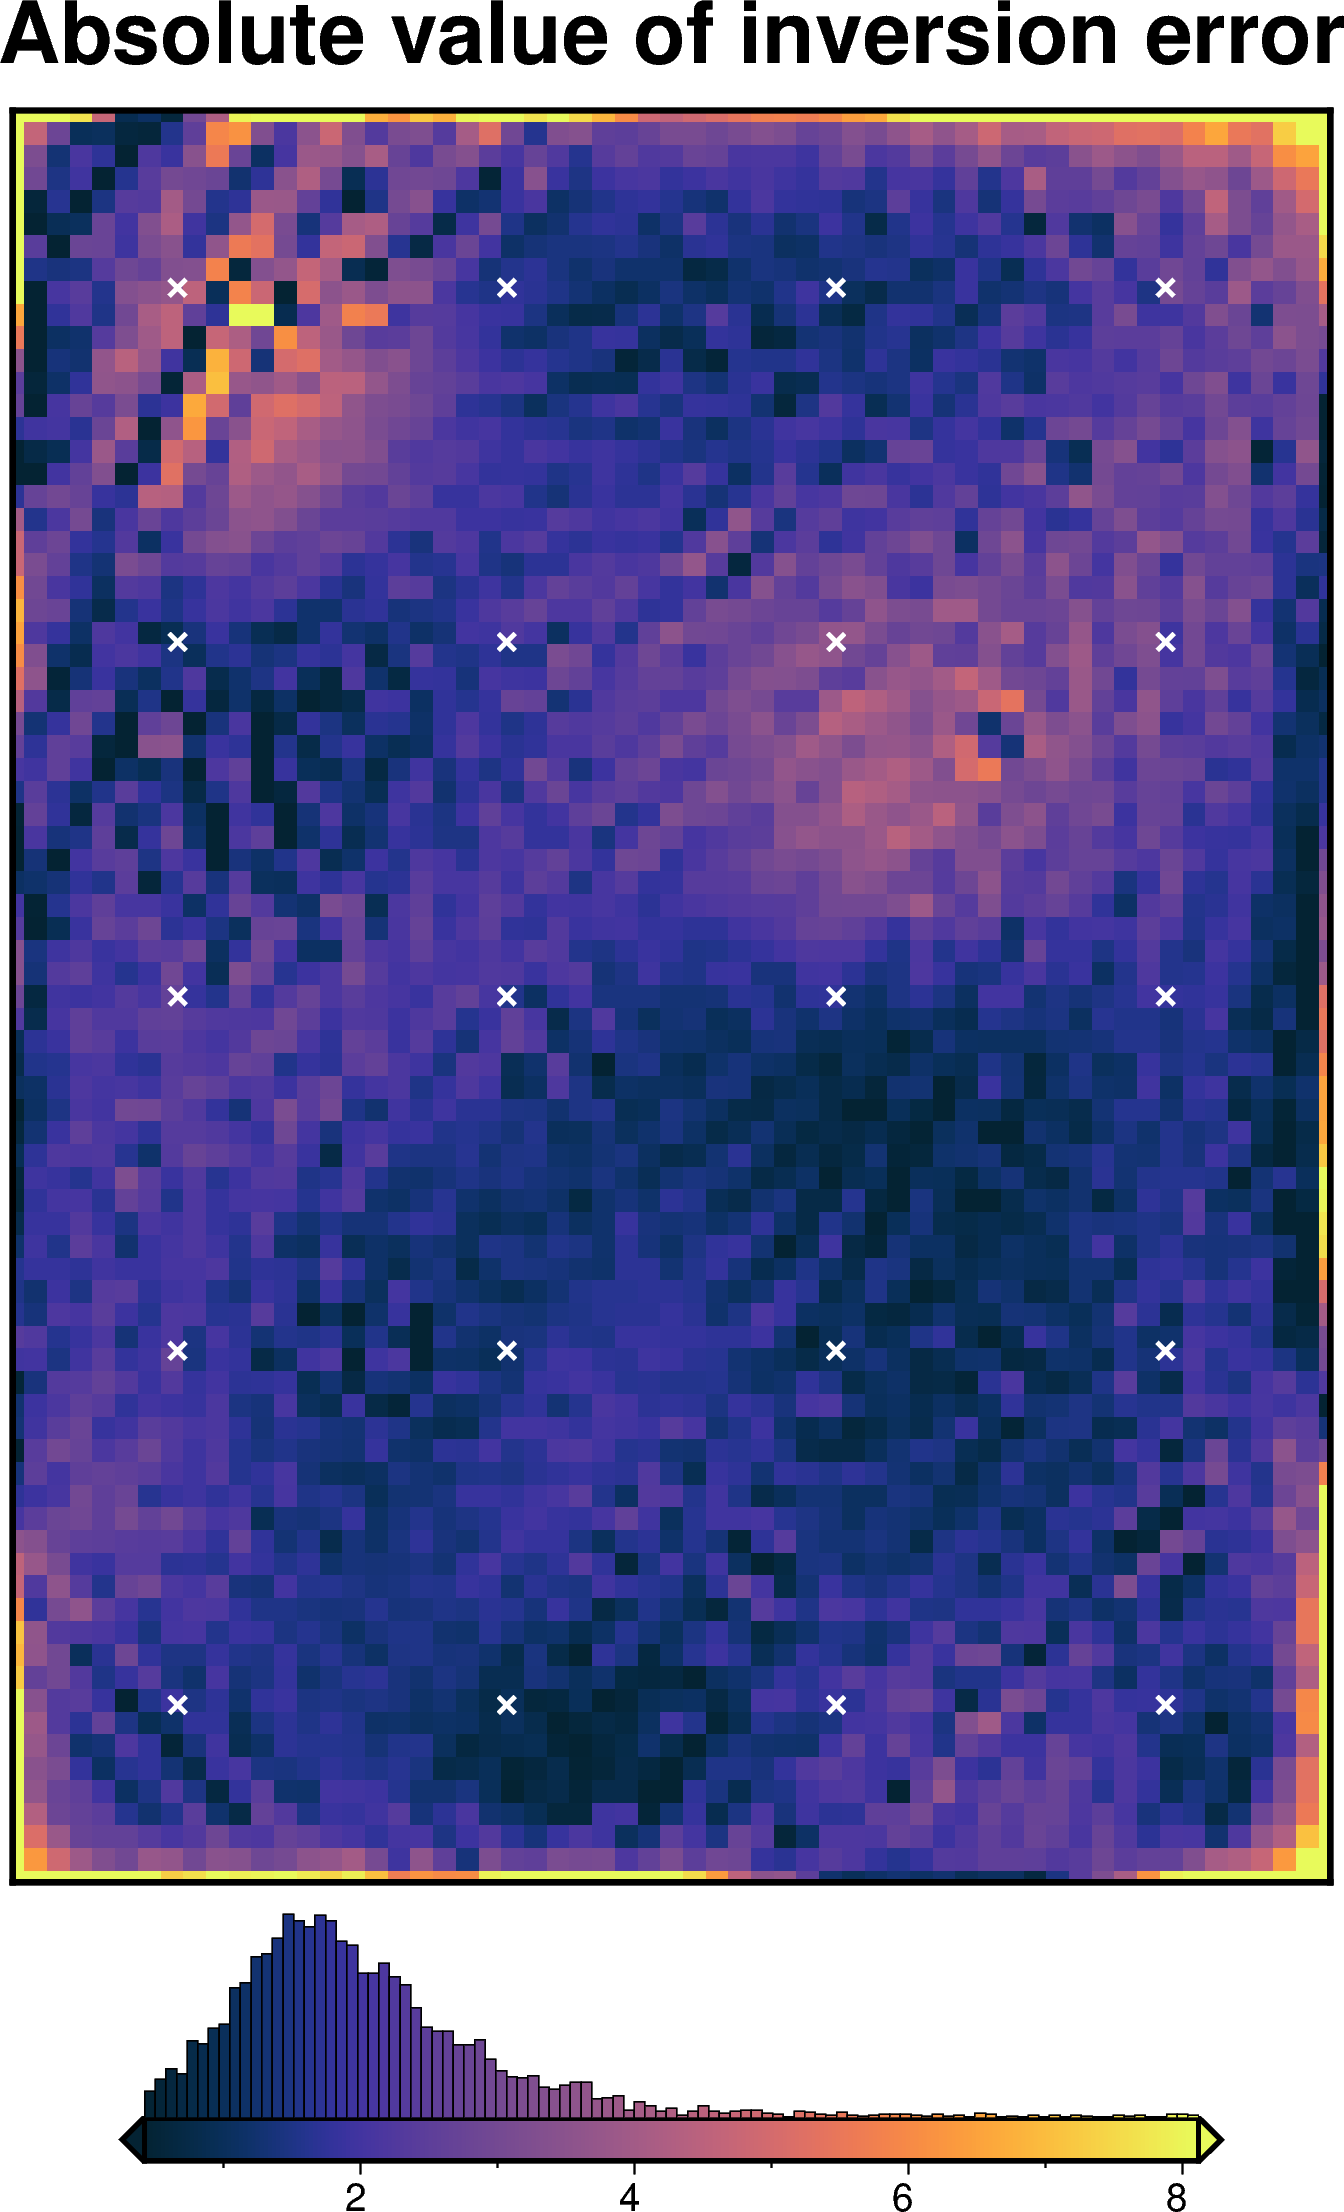

In [21]:
inversion_error = np.abs(bathymetry - final_topography)

fig = maps.plot_grd(
    inversion_error,
    region=vd.pad_region(inversion_region, -spacing),
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points,
    points_style="x.2c",
    points_fill="white",
)
fig.show()

## Redo starting gravity and regional separation
use the optimal determined density contrast

In [22]:
# set the reference level from the prisms to 0
zref = 0
density_grid = xr.where(
    starting_bathymetry >= zref,
    best_density_contrast,
    -best_density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
regional_grav_kwargs = dict(
    grav_df=grav_df,
    method="constant",
    constant=0,
)
grav_df = regional.regional_separation(**regional_grav_kwargs)

  0%|          | 0/4941 [00:00<?, ?it/s]

In [23]:
# add best damping parameter to kwargs
kwargs["solver_damping"] = best_damping

# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=best_density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_bathymetry,
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

## Solver damping component

In [ ]:
# load study
with pathlib.Path("../../results/Ross_Sea_03_damping_cv_damping_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
stdev = 0.05
print(f"using stdev: {stdev}")

calculated stdev: 0.2914168799106041
using stdev: 0.05


best: 0.02457795972125576 
std: 0.05 
+1std: 0.02757692437633931 
-1std: 0.021905129658982607


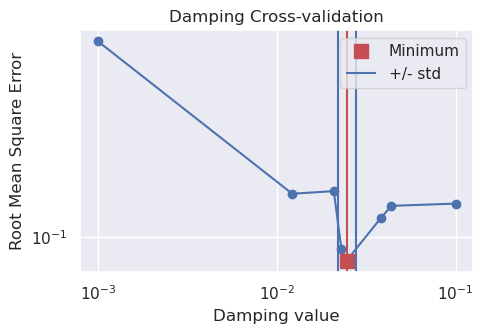

In [25]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.024721579411000148, min: 0.020337761347181217, max: 0.029702192574080664
INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

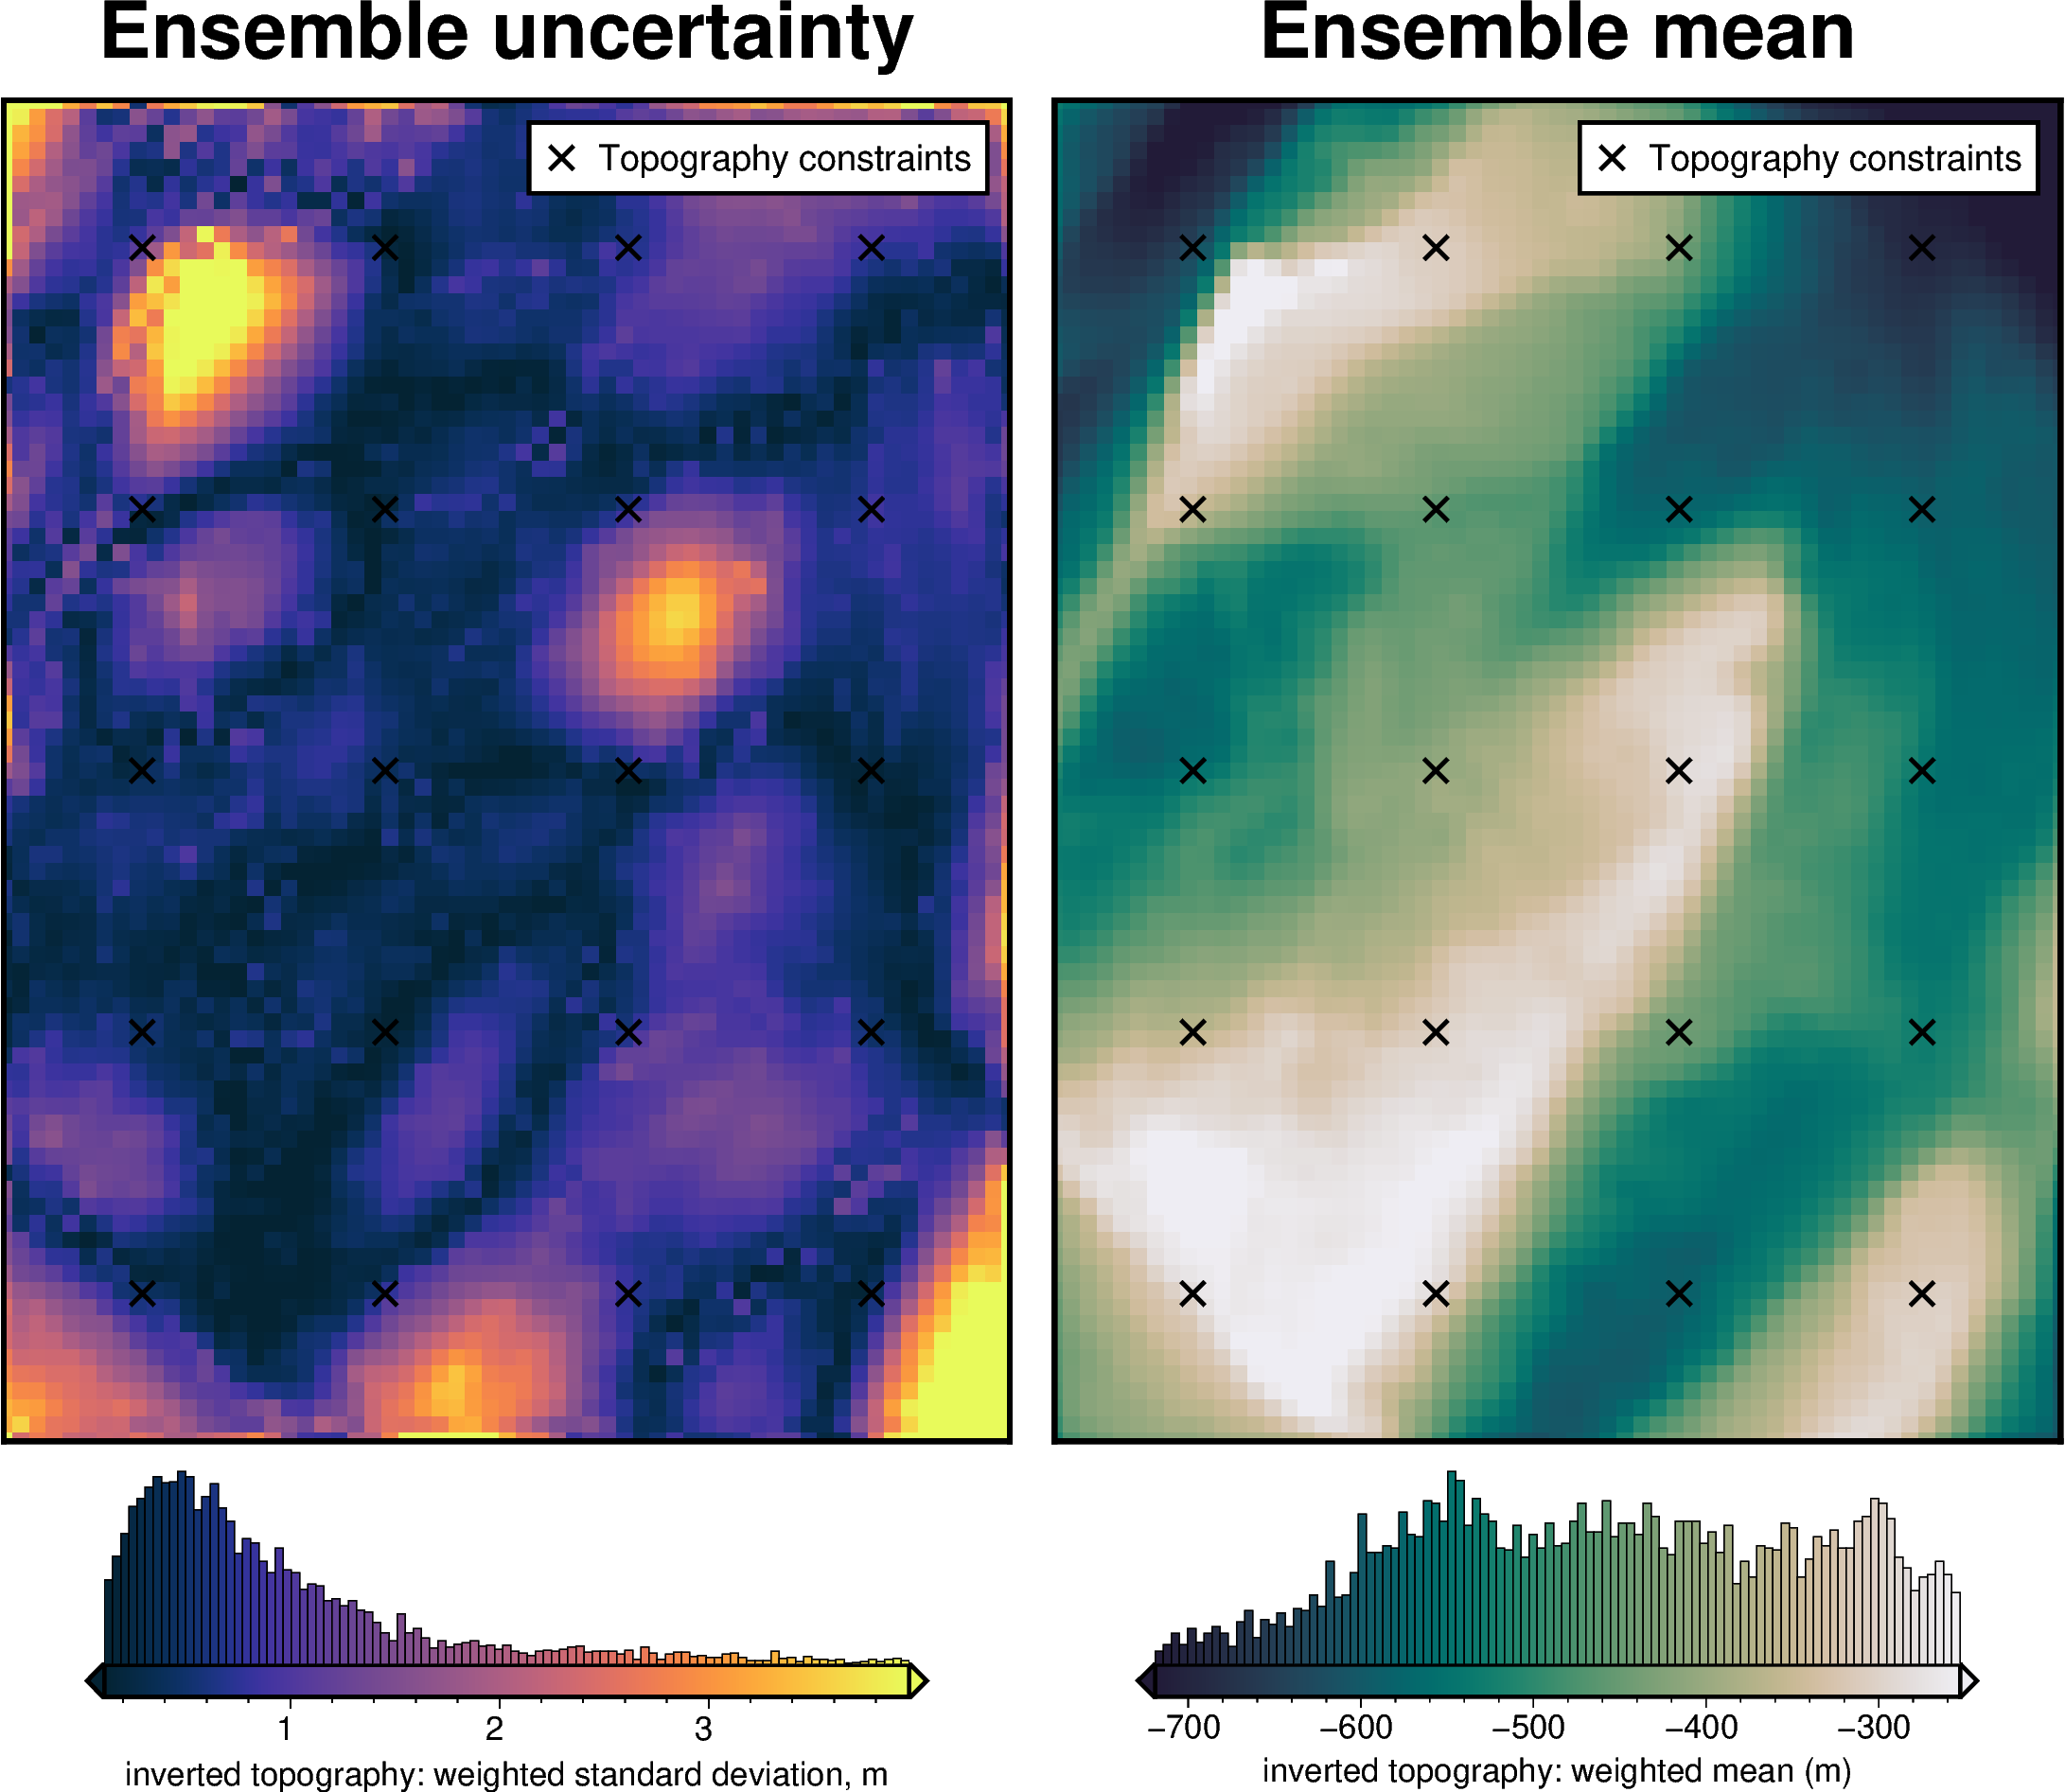

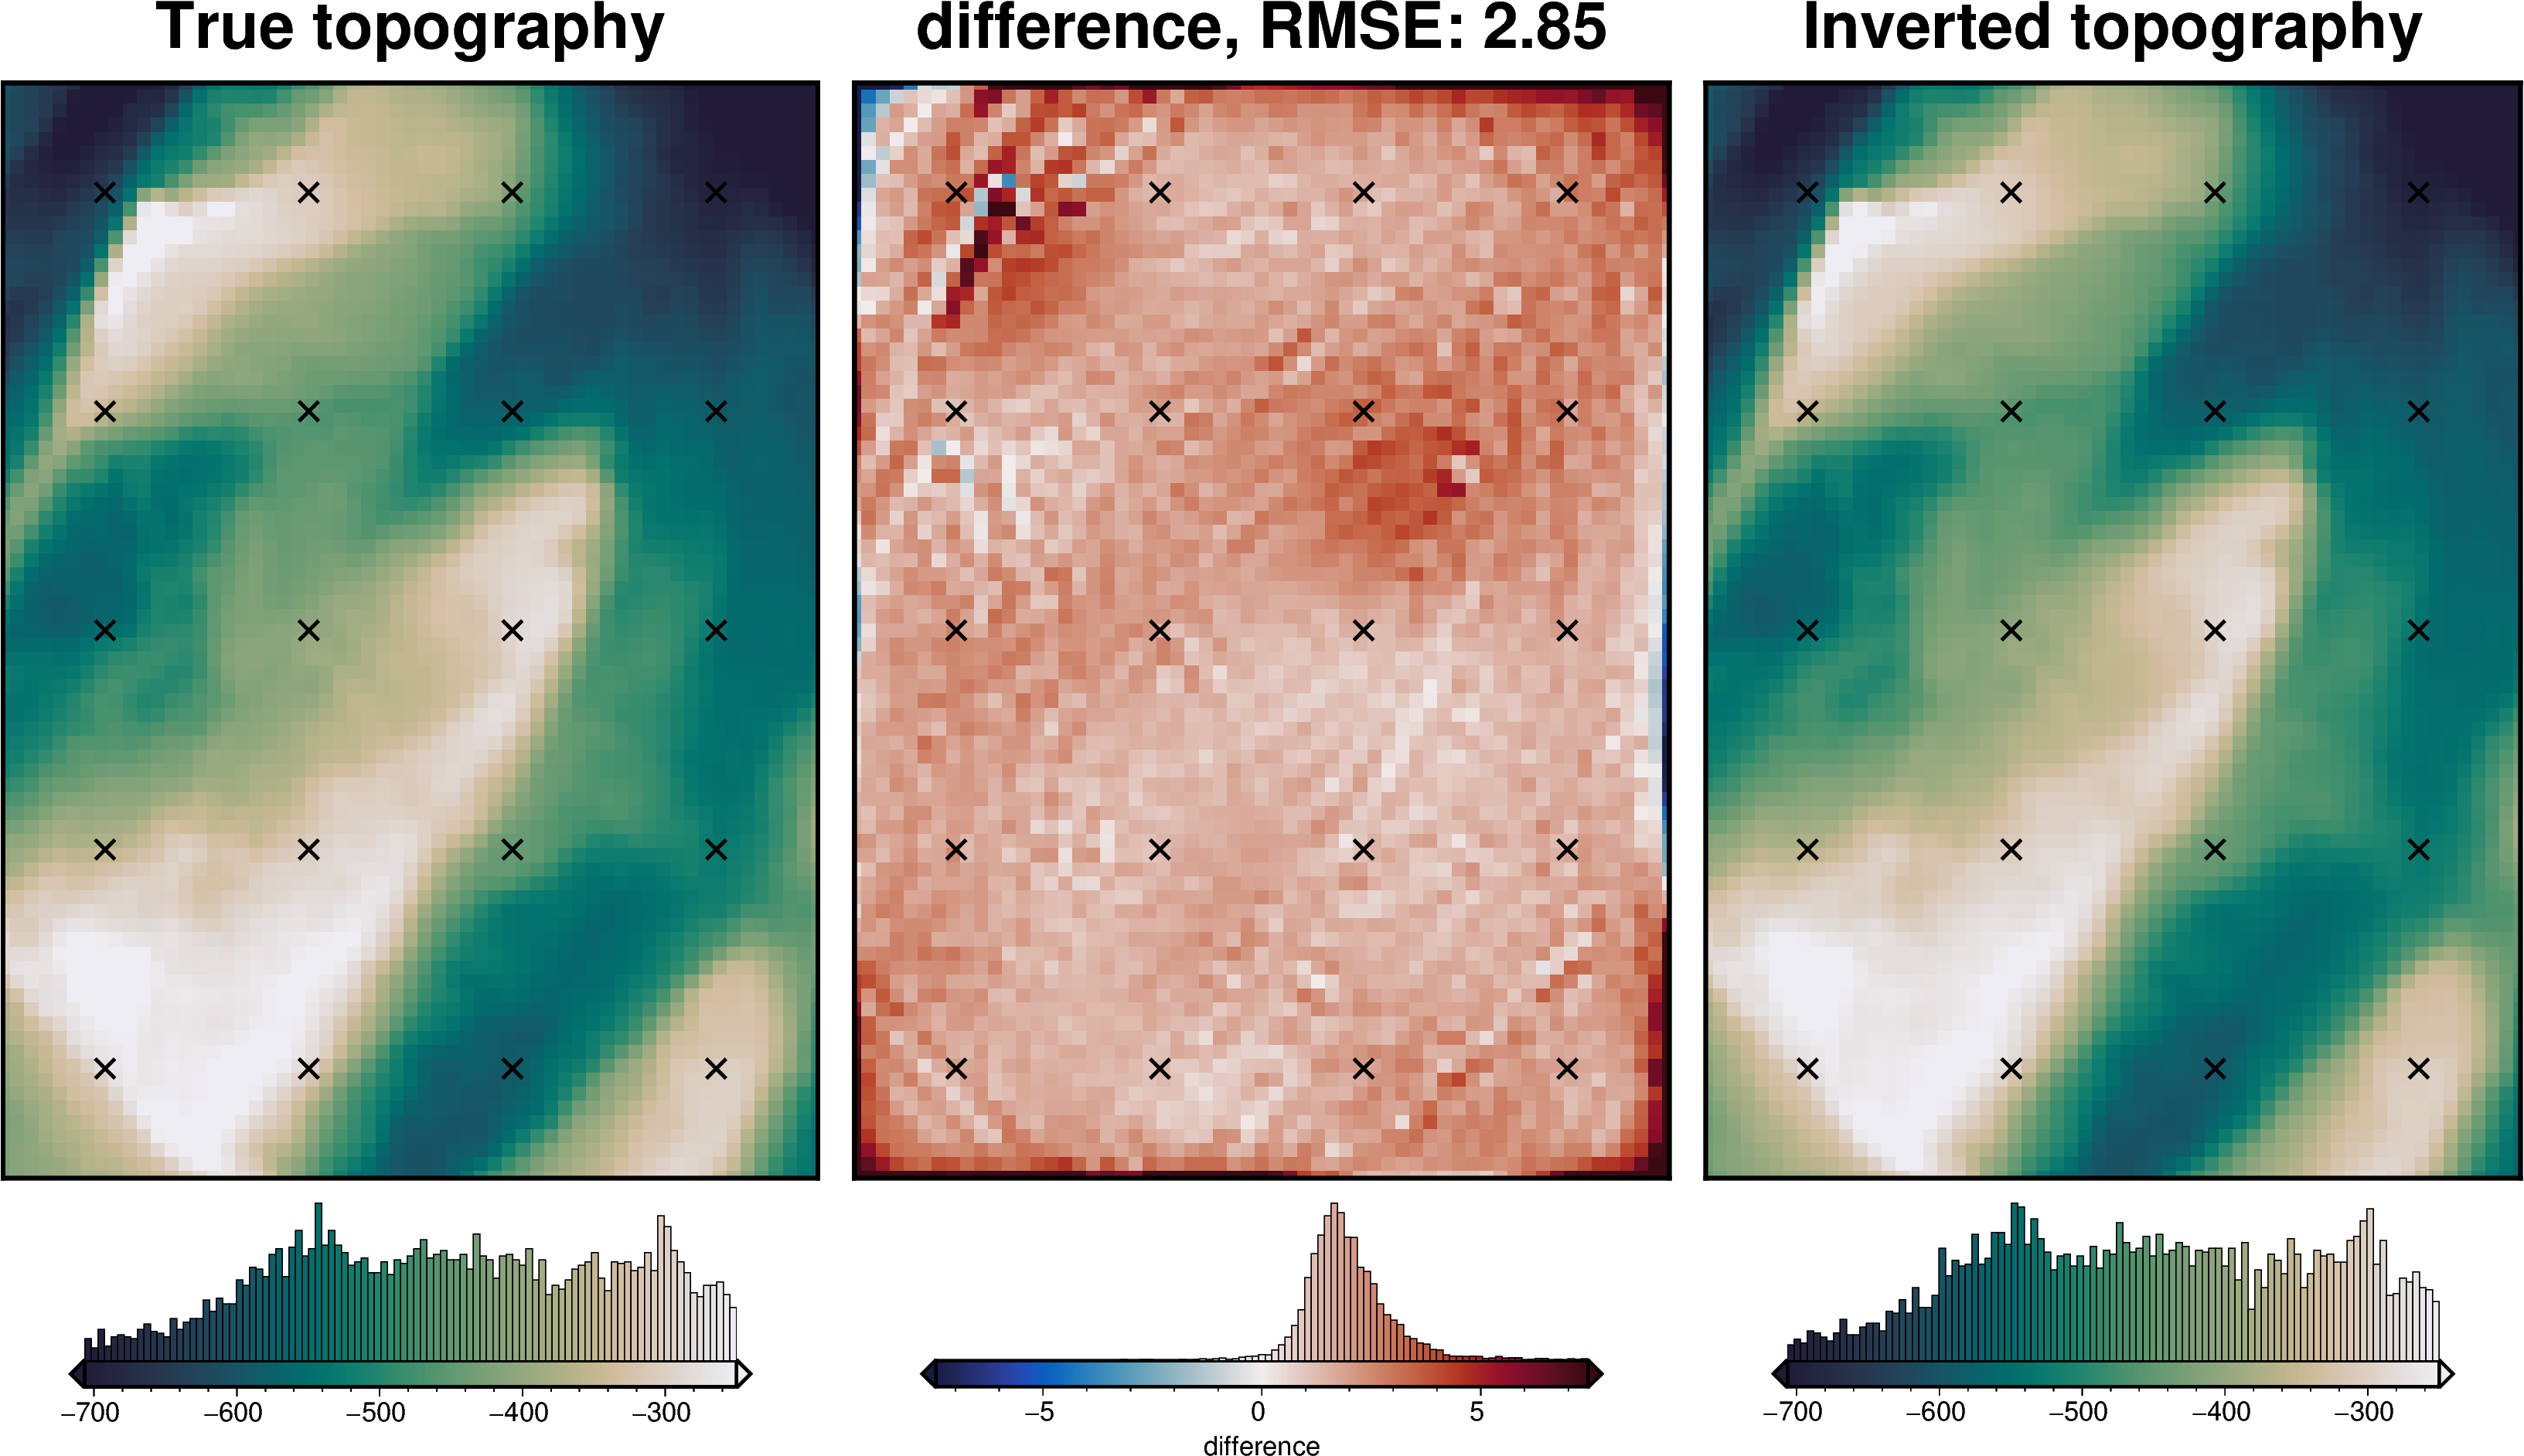

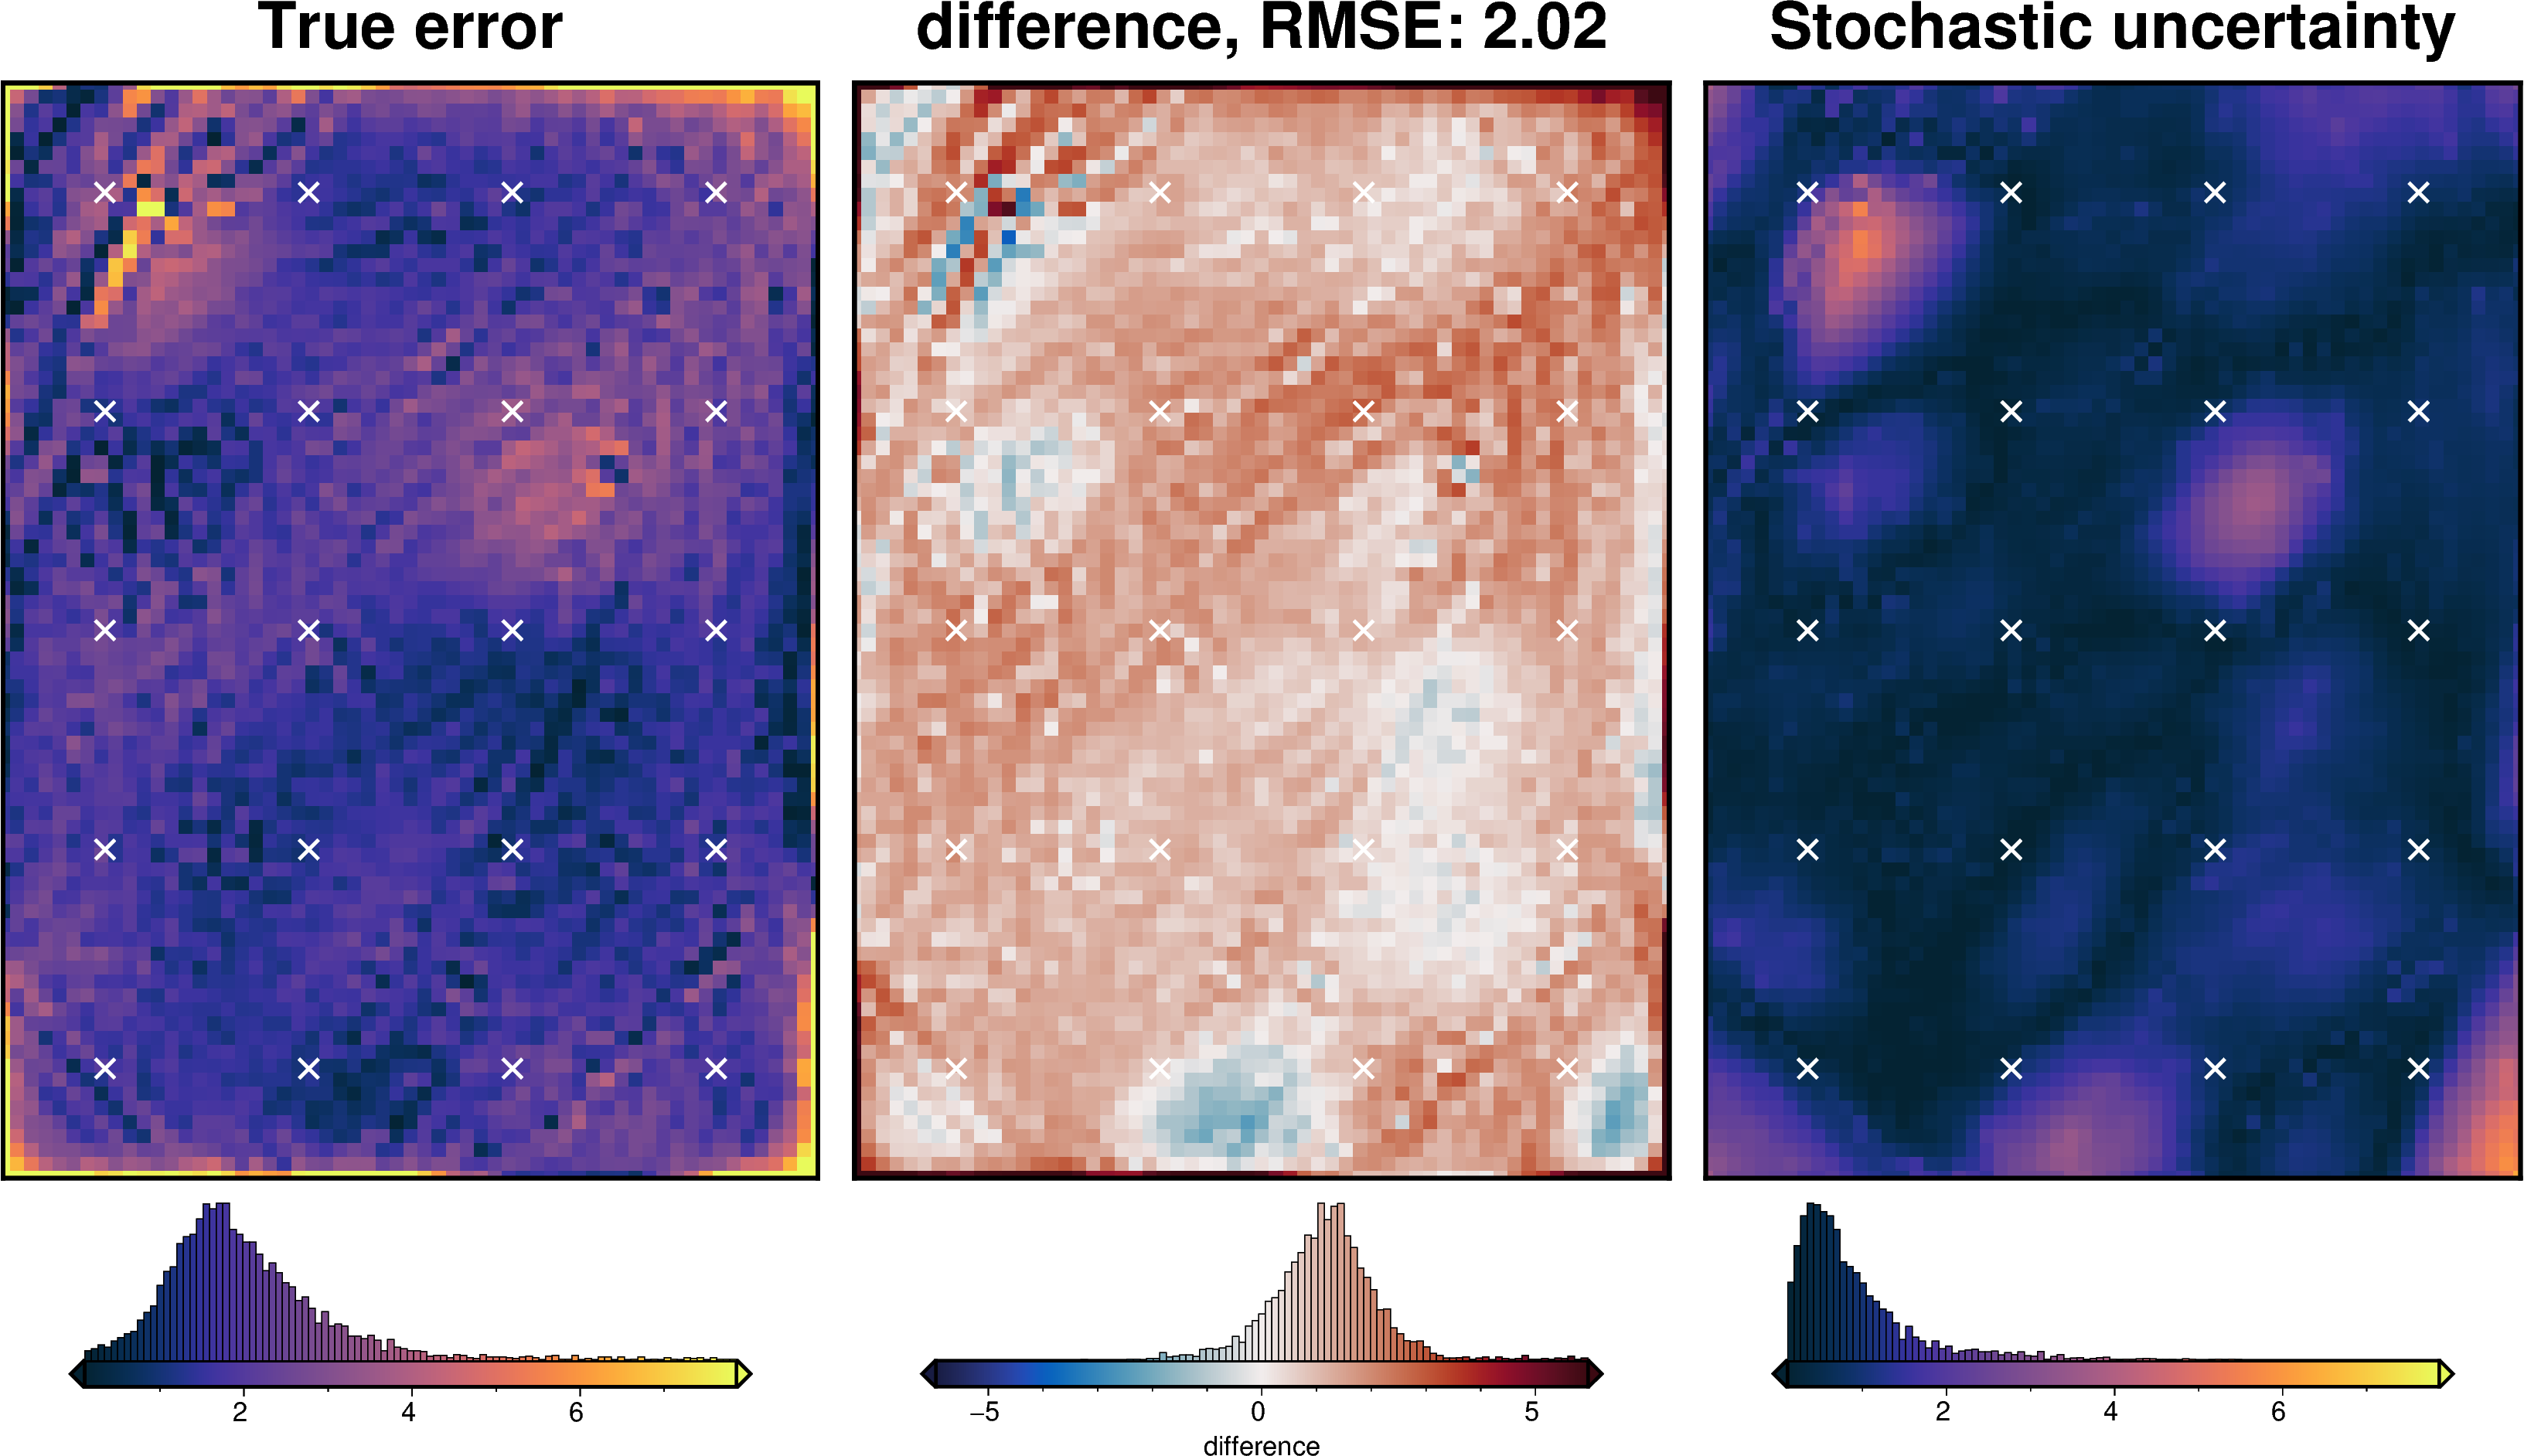

In [26]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}
fname = "../../results/Ross_Sea_03_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_damping_results,
    inversion_region,
    spacing,
    bathymetry,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Density component

In [27]:
true_density_contrast

1476

In [ ]:
# load study
with pathlib.Path(
    "../../results/Ross_Sea_03_density_cv_zref_density_cv_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = study_df2.params_density_contrast.std()
print(f"calculated stdev: {stdev}")

# manually pick a stdev
stdev = 5
print(f"using stdev: {stdev}")

calculated stdev: 59.279980681414806
using stdev: 5


best: 1470.1164840004974 
std: 5 
+1std: 1475.1164840004974 
-1std: 1465.1164840004974


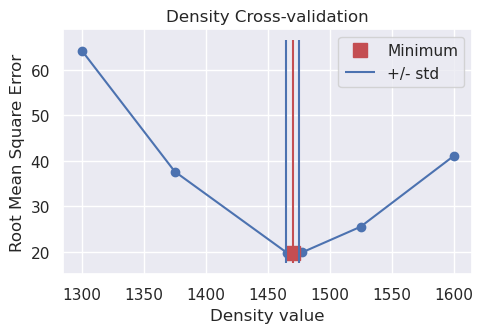

In [29]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_density_contrast.iloc[0]
upper = best + stdev
lower = best - stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1470.1164840004972, min: 1461.8922158657401, max: 1478.3407521352547
INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

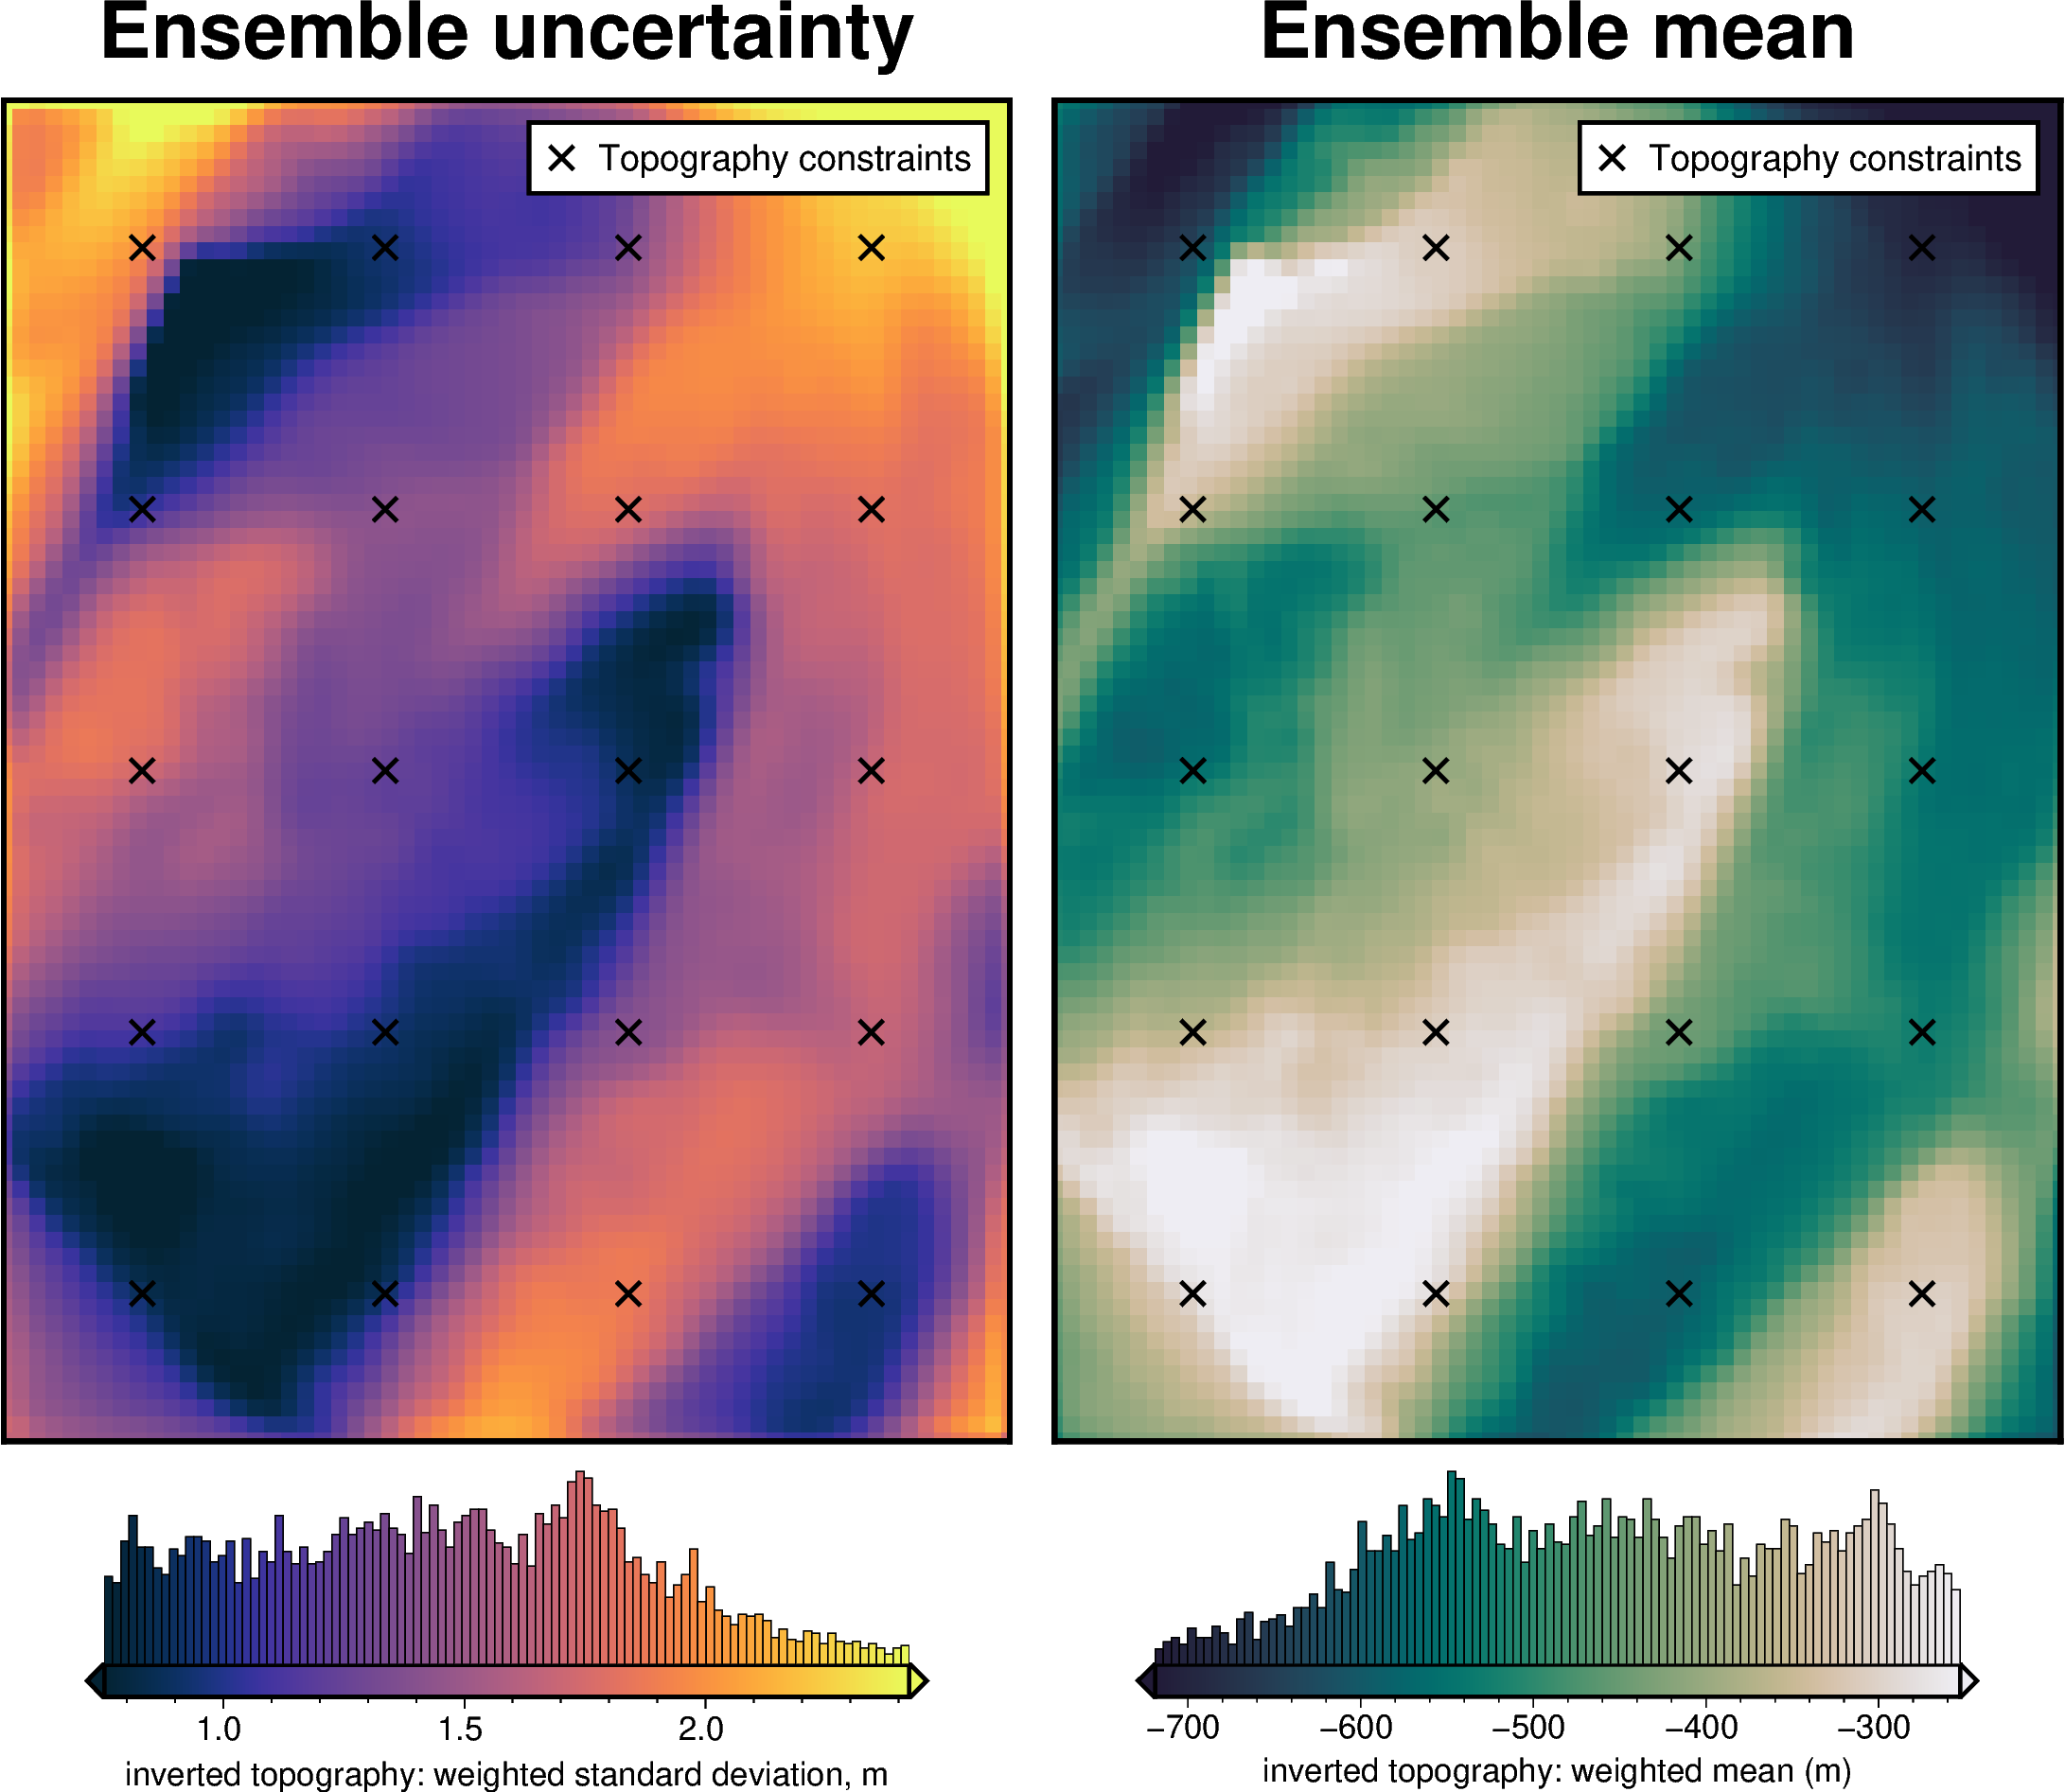

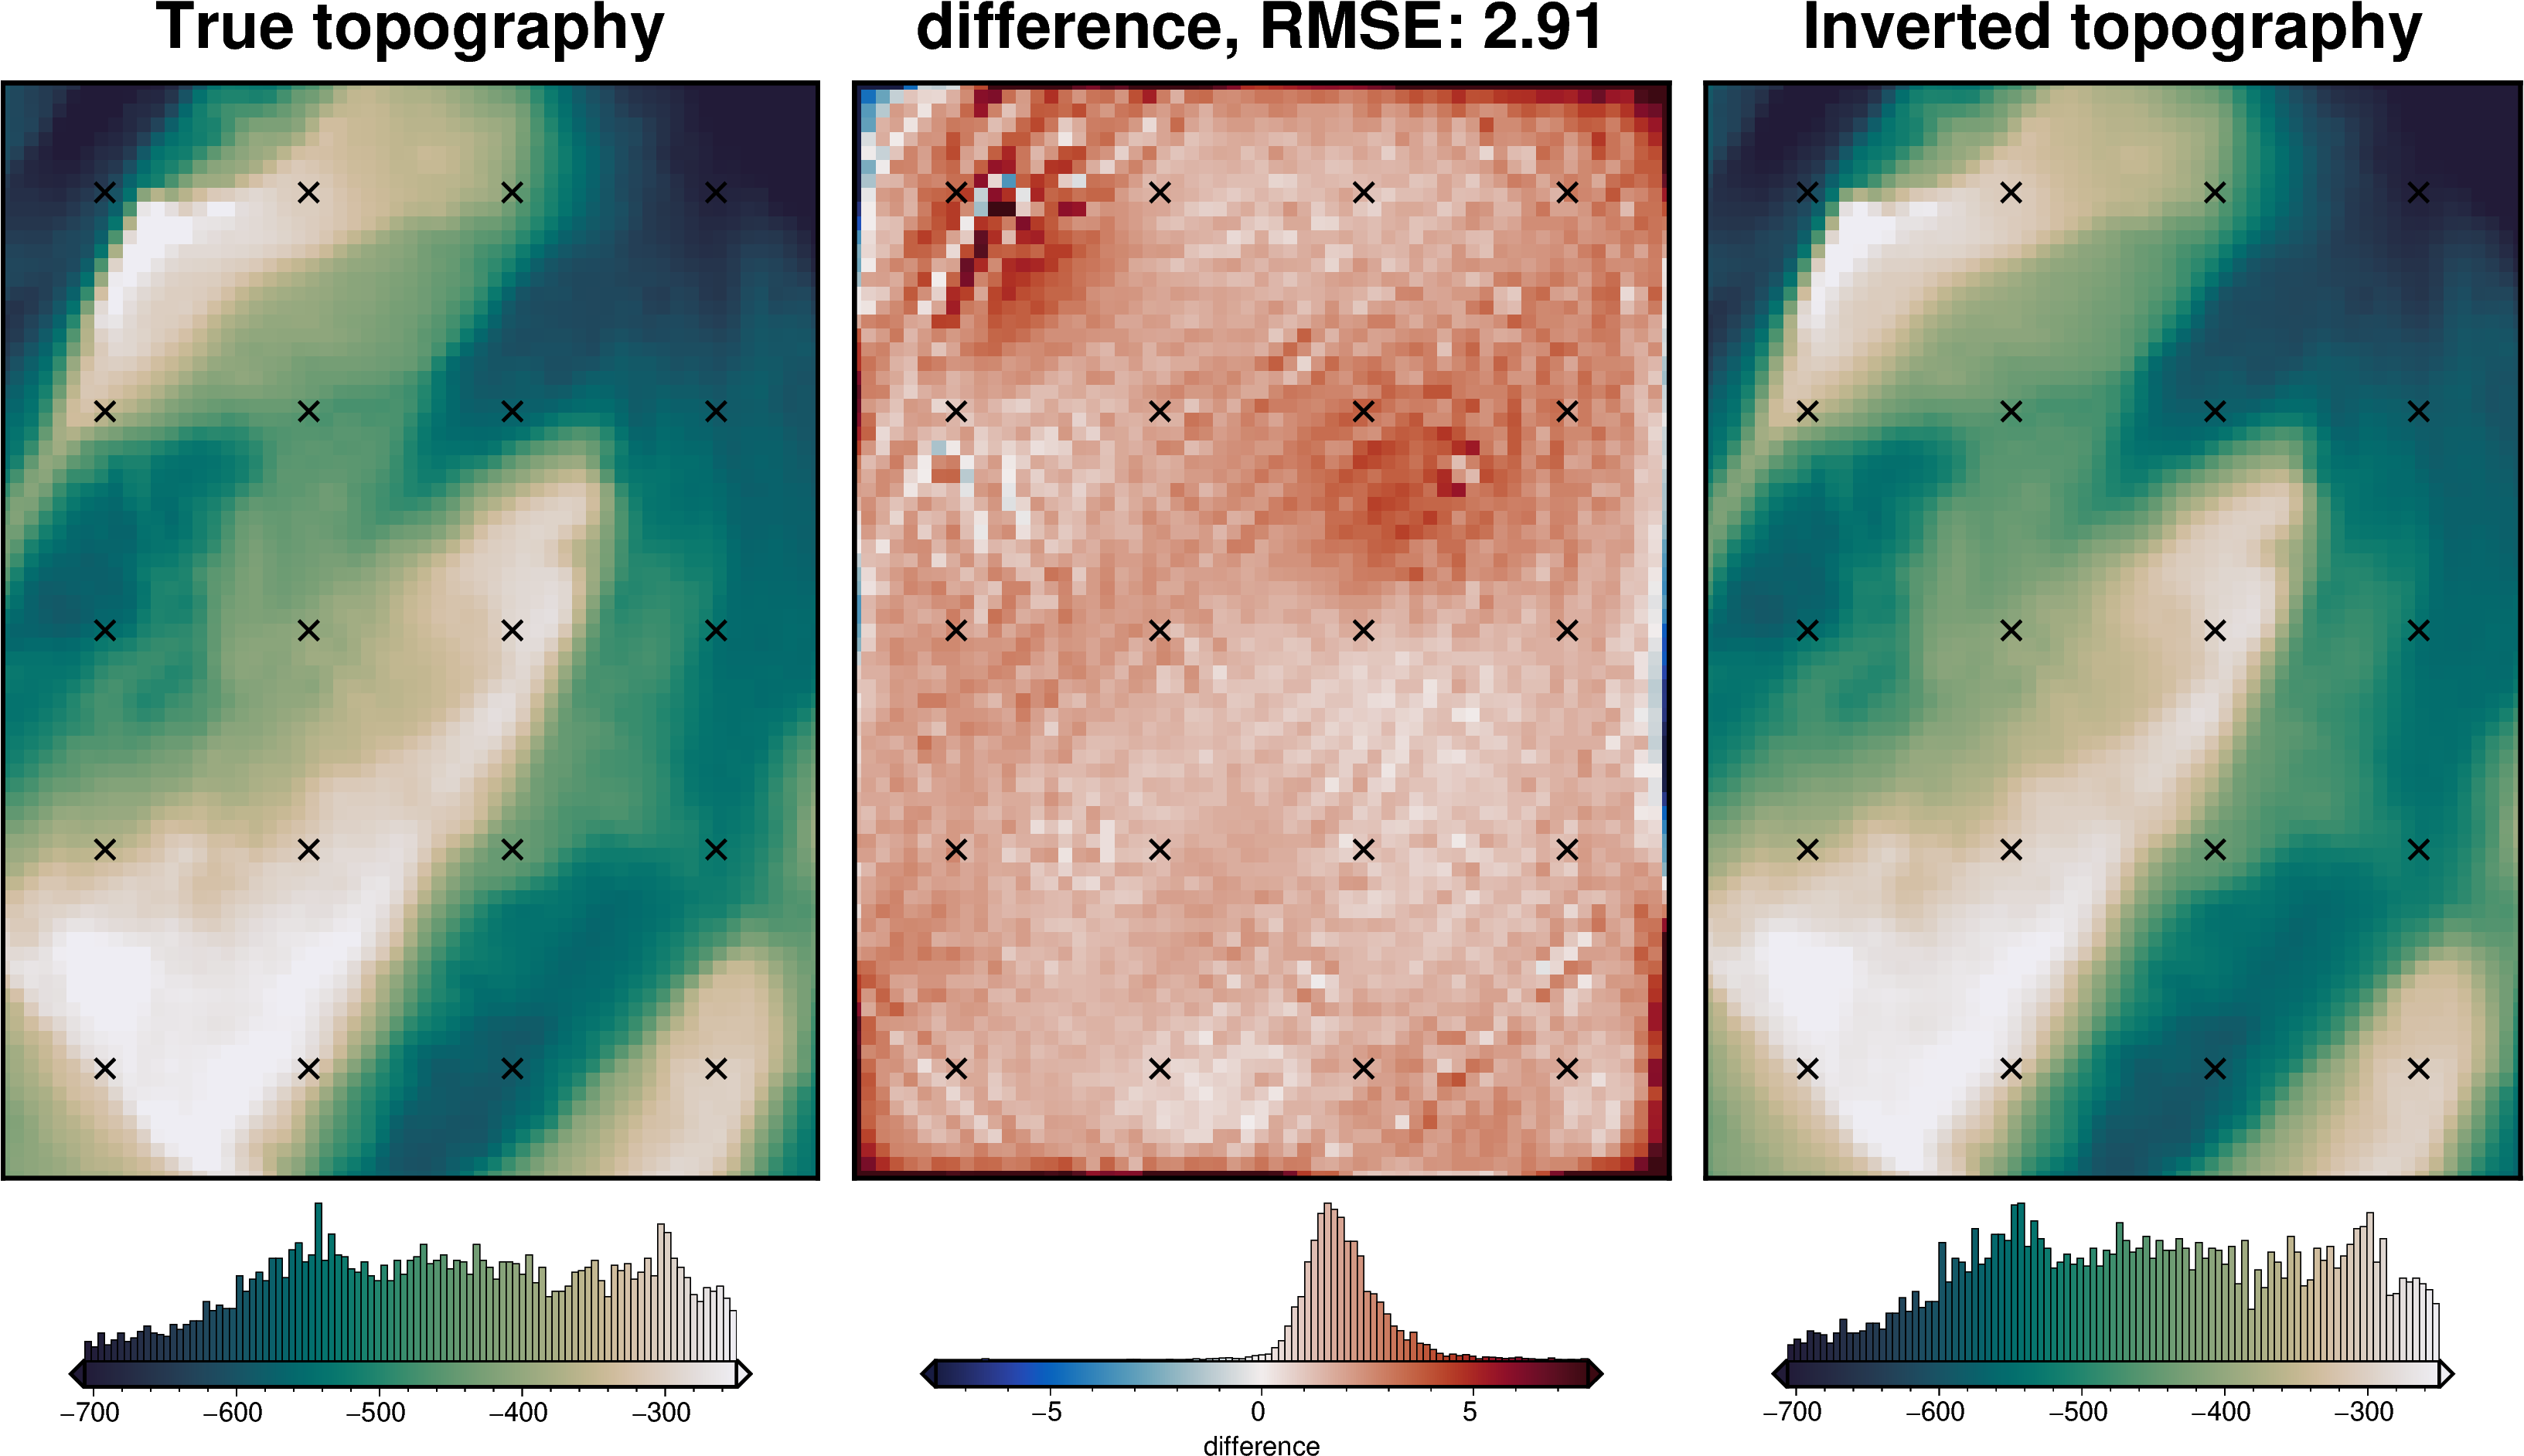

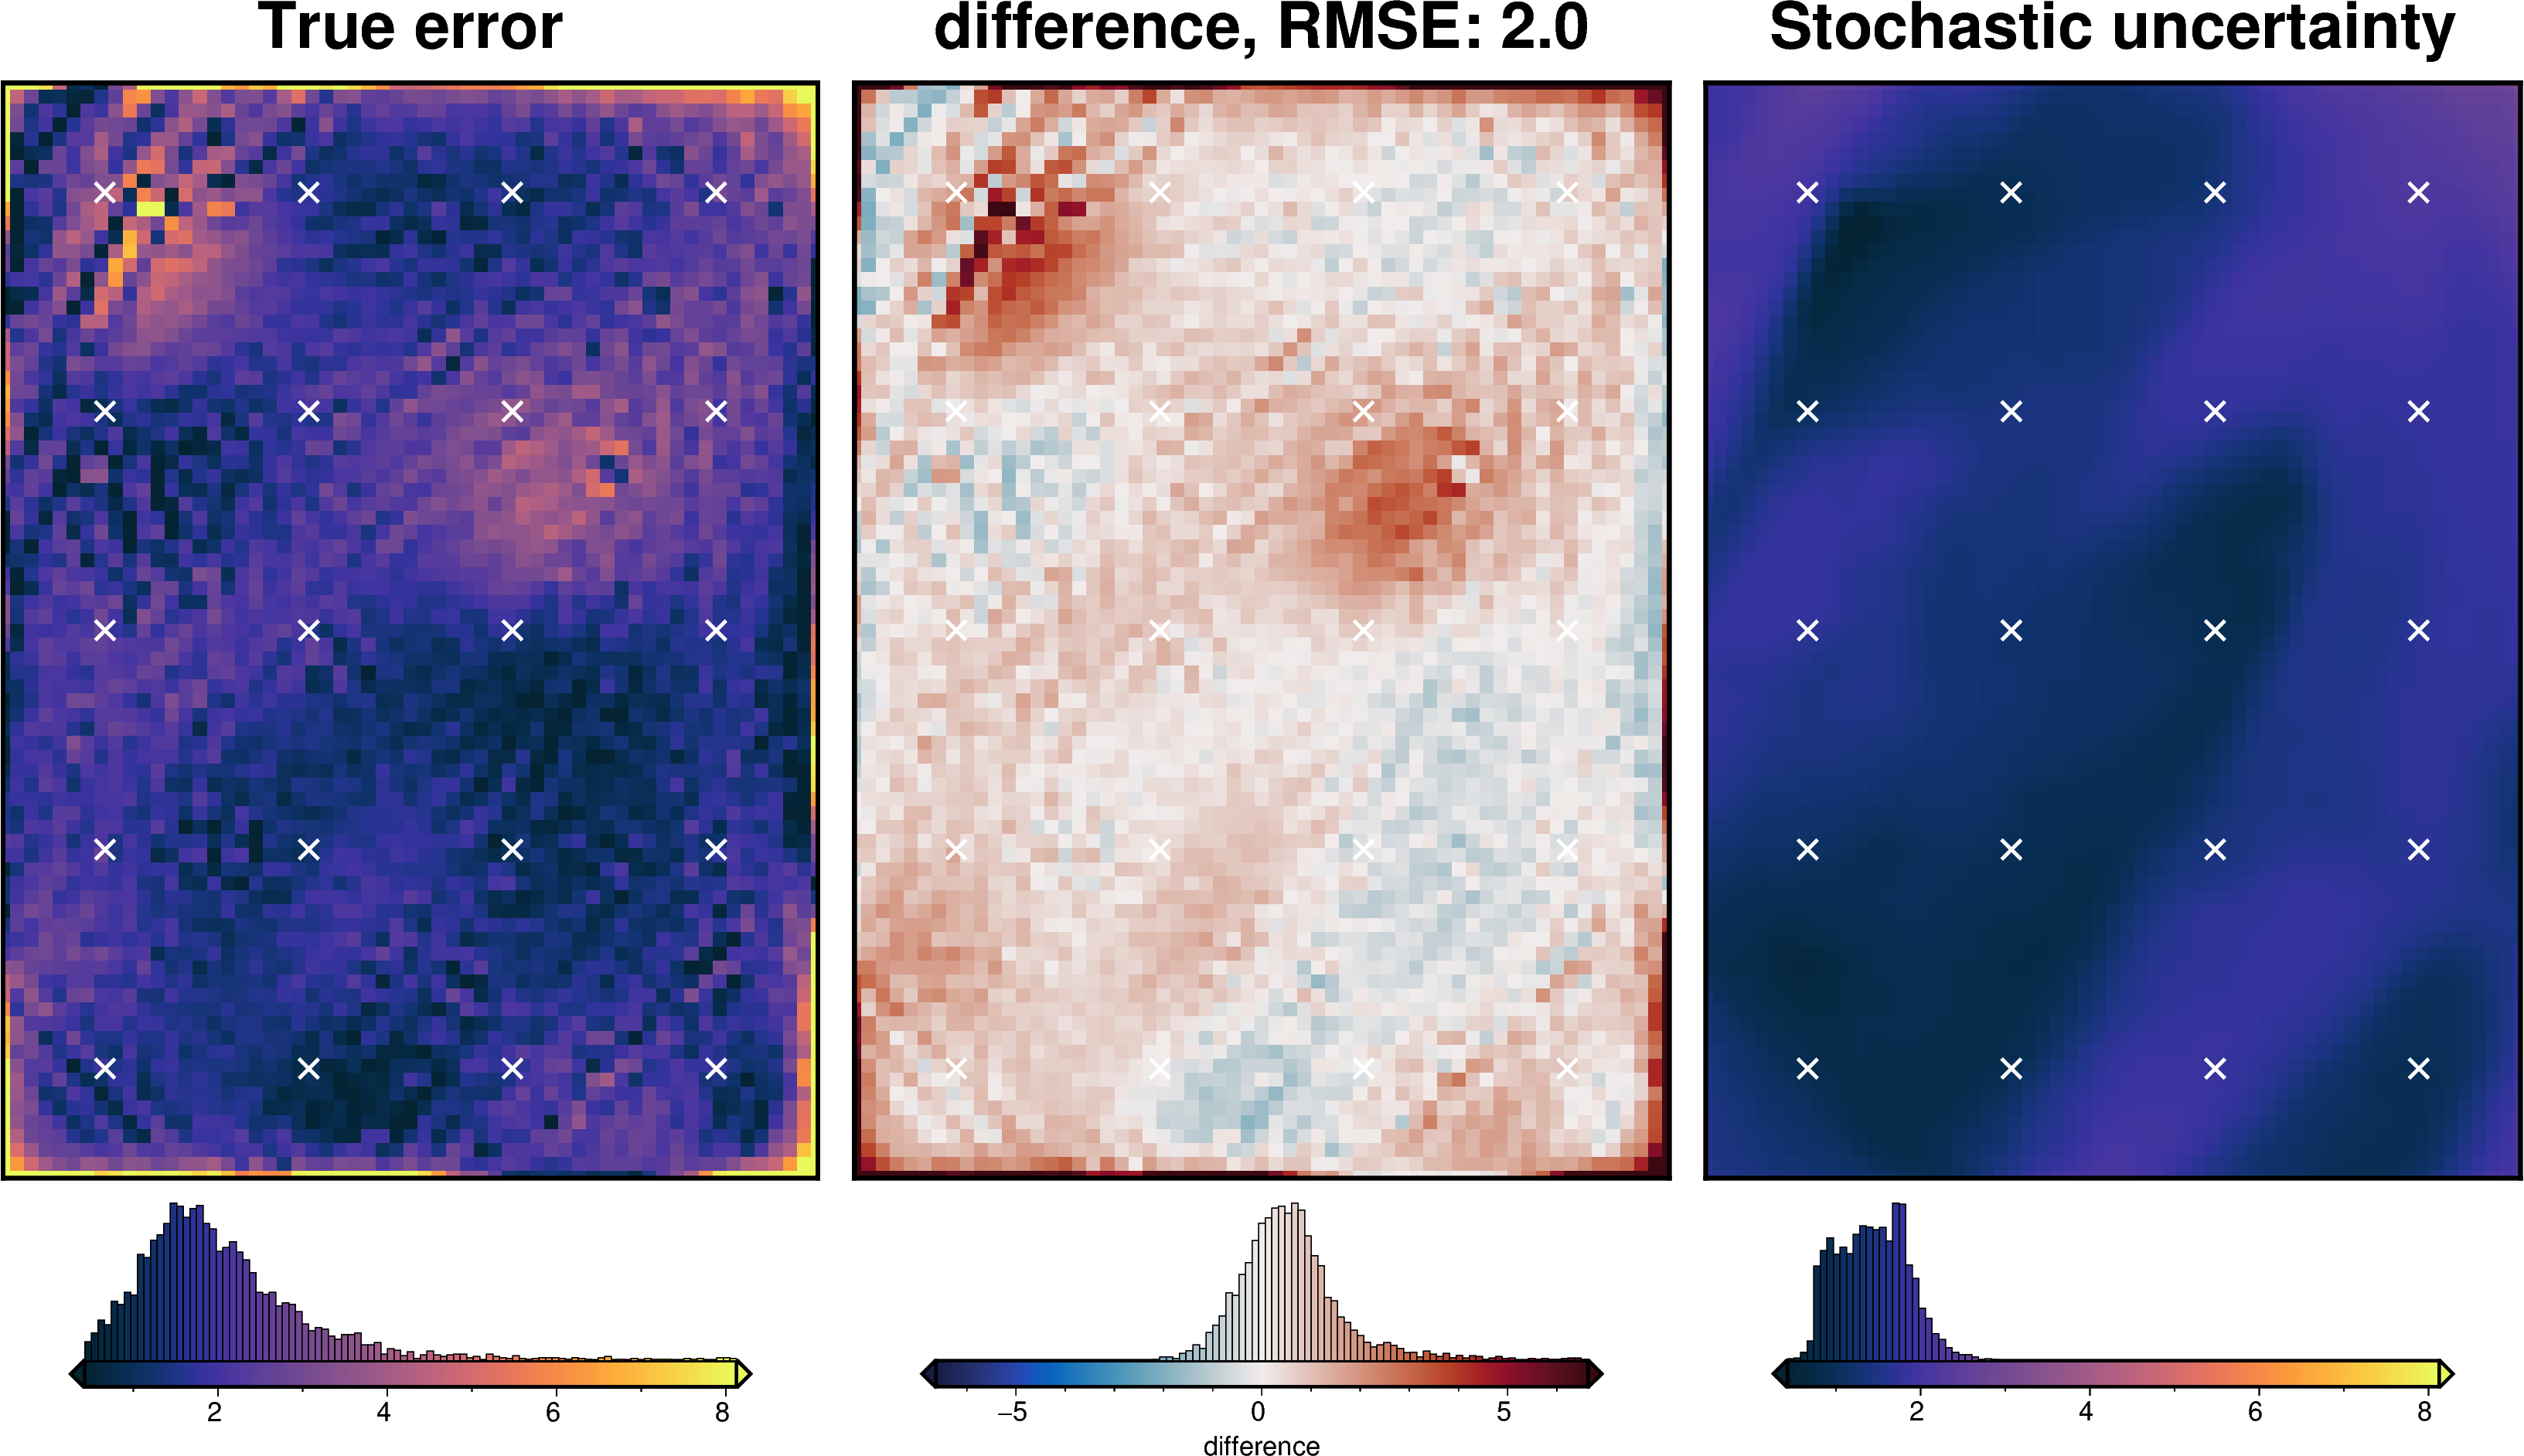

In [30]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": stdev,
    },
}
fname = "../../results/Ross_Sea_03_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_density_results,
    inversion_region,
    spacing,
    bathymetry,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Constraints component

In [31]:
# set uncertainty as 5% of each points depth
uncert = np.abs(0.05 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert
constraint_points

northing   easting  true_upward      upward  true_uncert    weight  \
0  -1756000.0    1250.0  -277.117397 -275.375295    13.855870  0.005209   
1  -1756000.0   73750.0  -292.754172 -294.687884    14.637709  0.004667   
2  -1756000.0  146250.0  -587.490438 -568.678329    29.374522  0.001159   
3  -1756000.0  218750.0  -303.910608 -302.316595    15.195530  0.004331   
4  -1678000.0    1250.0  -356.930926 -366.490774    17.846546  0.003140   
5  -1678000.0   73750.0  -305.091241 -299.575267    15.254562  0.004297   
6  -1678000.0  146250.0  -444.497296 -415.516071    22.224865  0.002025   
7  -1678000.0  218750.0  -528.725284 -503.688001    26.436264  0.001431   
8  -1600000.0    1250.0  -549.225696 -568.551170    27.461285  0.001326   
9  -1600000.0   73750.0  -404.192068 -429.765734    20.209603  0.002448   
10 -1600000.0  146250.0  -286.736516 -295.672293    14.336826  0.004865   
11 -1600000.0  218750.0  -538.819646 -537.706283    26.940982  0.001378   
12 -1522000.0    1250.0  -350.376429 -391.108228    17.518821  0.003258   
13 -1522000.0   73750.0  -457.259969 -462.262202    22.862998  0.001913   
14 -1522000.0  146250.0  -572.989645 -608.684349    28.649482  0.001218   
15 -1522000.0  218750.0  -587.550512 -609.062715    29.377526  0.001159   
16 -1444000.0    1250.0  -630.501452 -647.659256    31.525073  0.001006   
17 -1444000.0   73750.0  -306.423601 -311.269693    15.321180  0.004260   
18 -1444000.0  146250.0  -425.052722 -416.304488    21.252636  0.002214   
19 -1444000.0  218750.0  -692.387842 -656.296662    34.619392  0.000834   

    starting_bathymetry  inverted_topography     uncert  
0           -275.357134          -278.921286  13.768765  
1           -294.818837          -293.734788  14.734394  
2           -568.378302          -589.258058  28.433916  
3           -302.509859          -305.651220  15.115830  
4           -366.557202          -359.232805  18.324539  
5           -299.685539          -306.322757  14.978763  
6           -415.491586          -445.551397  20.775804  
7           -503.551367          -530.220165  25.184400  
8           -568.425920          -551.752593  28.427558  
9           -429.722012          -405.876658  21.488287  
10          -295.871081          -288.395053  14.783615  
11          -537.662302          -540.666094  26.885314  
12          -391.484116          -351.451422  19.555411  
13          -462.144845          -459.192144  23.113110  
14          -608.300432          -576.760266  30.434217  
15          -609.157319          -589.691184  30.453136  
16          -647.444767          -634.382260  32.382963  
17          -311.481762          -308.087000  15.563485  
18          -416.399878          -426.475728  20.815224  
19          -656.229904          -695.198080  32.814833

INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

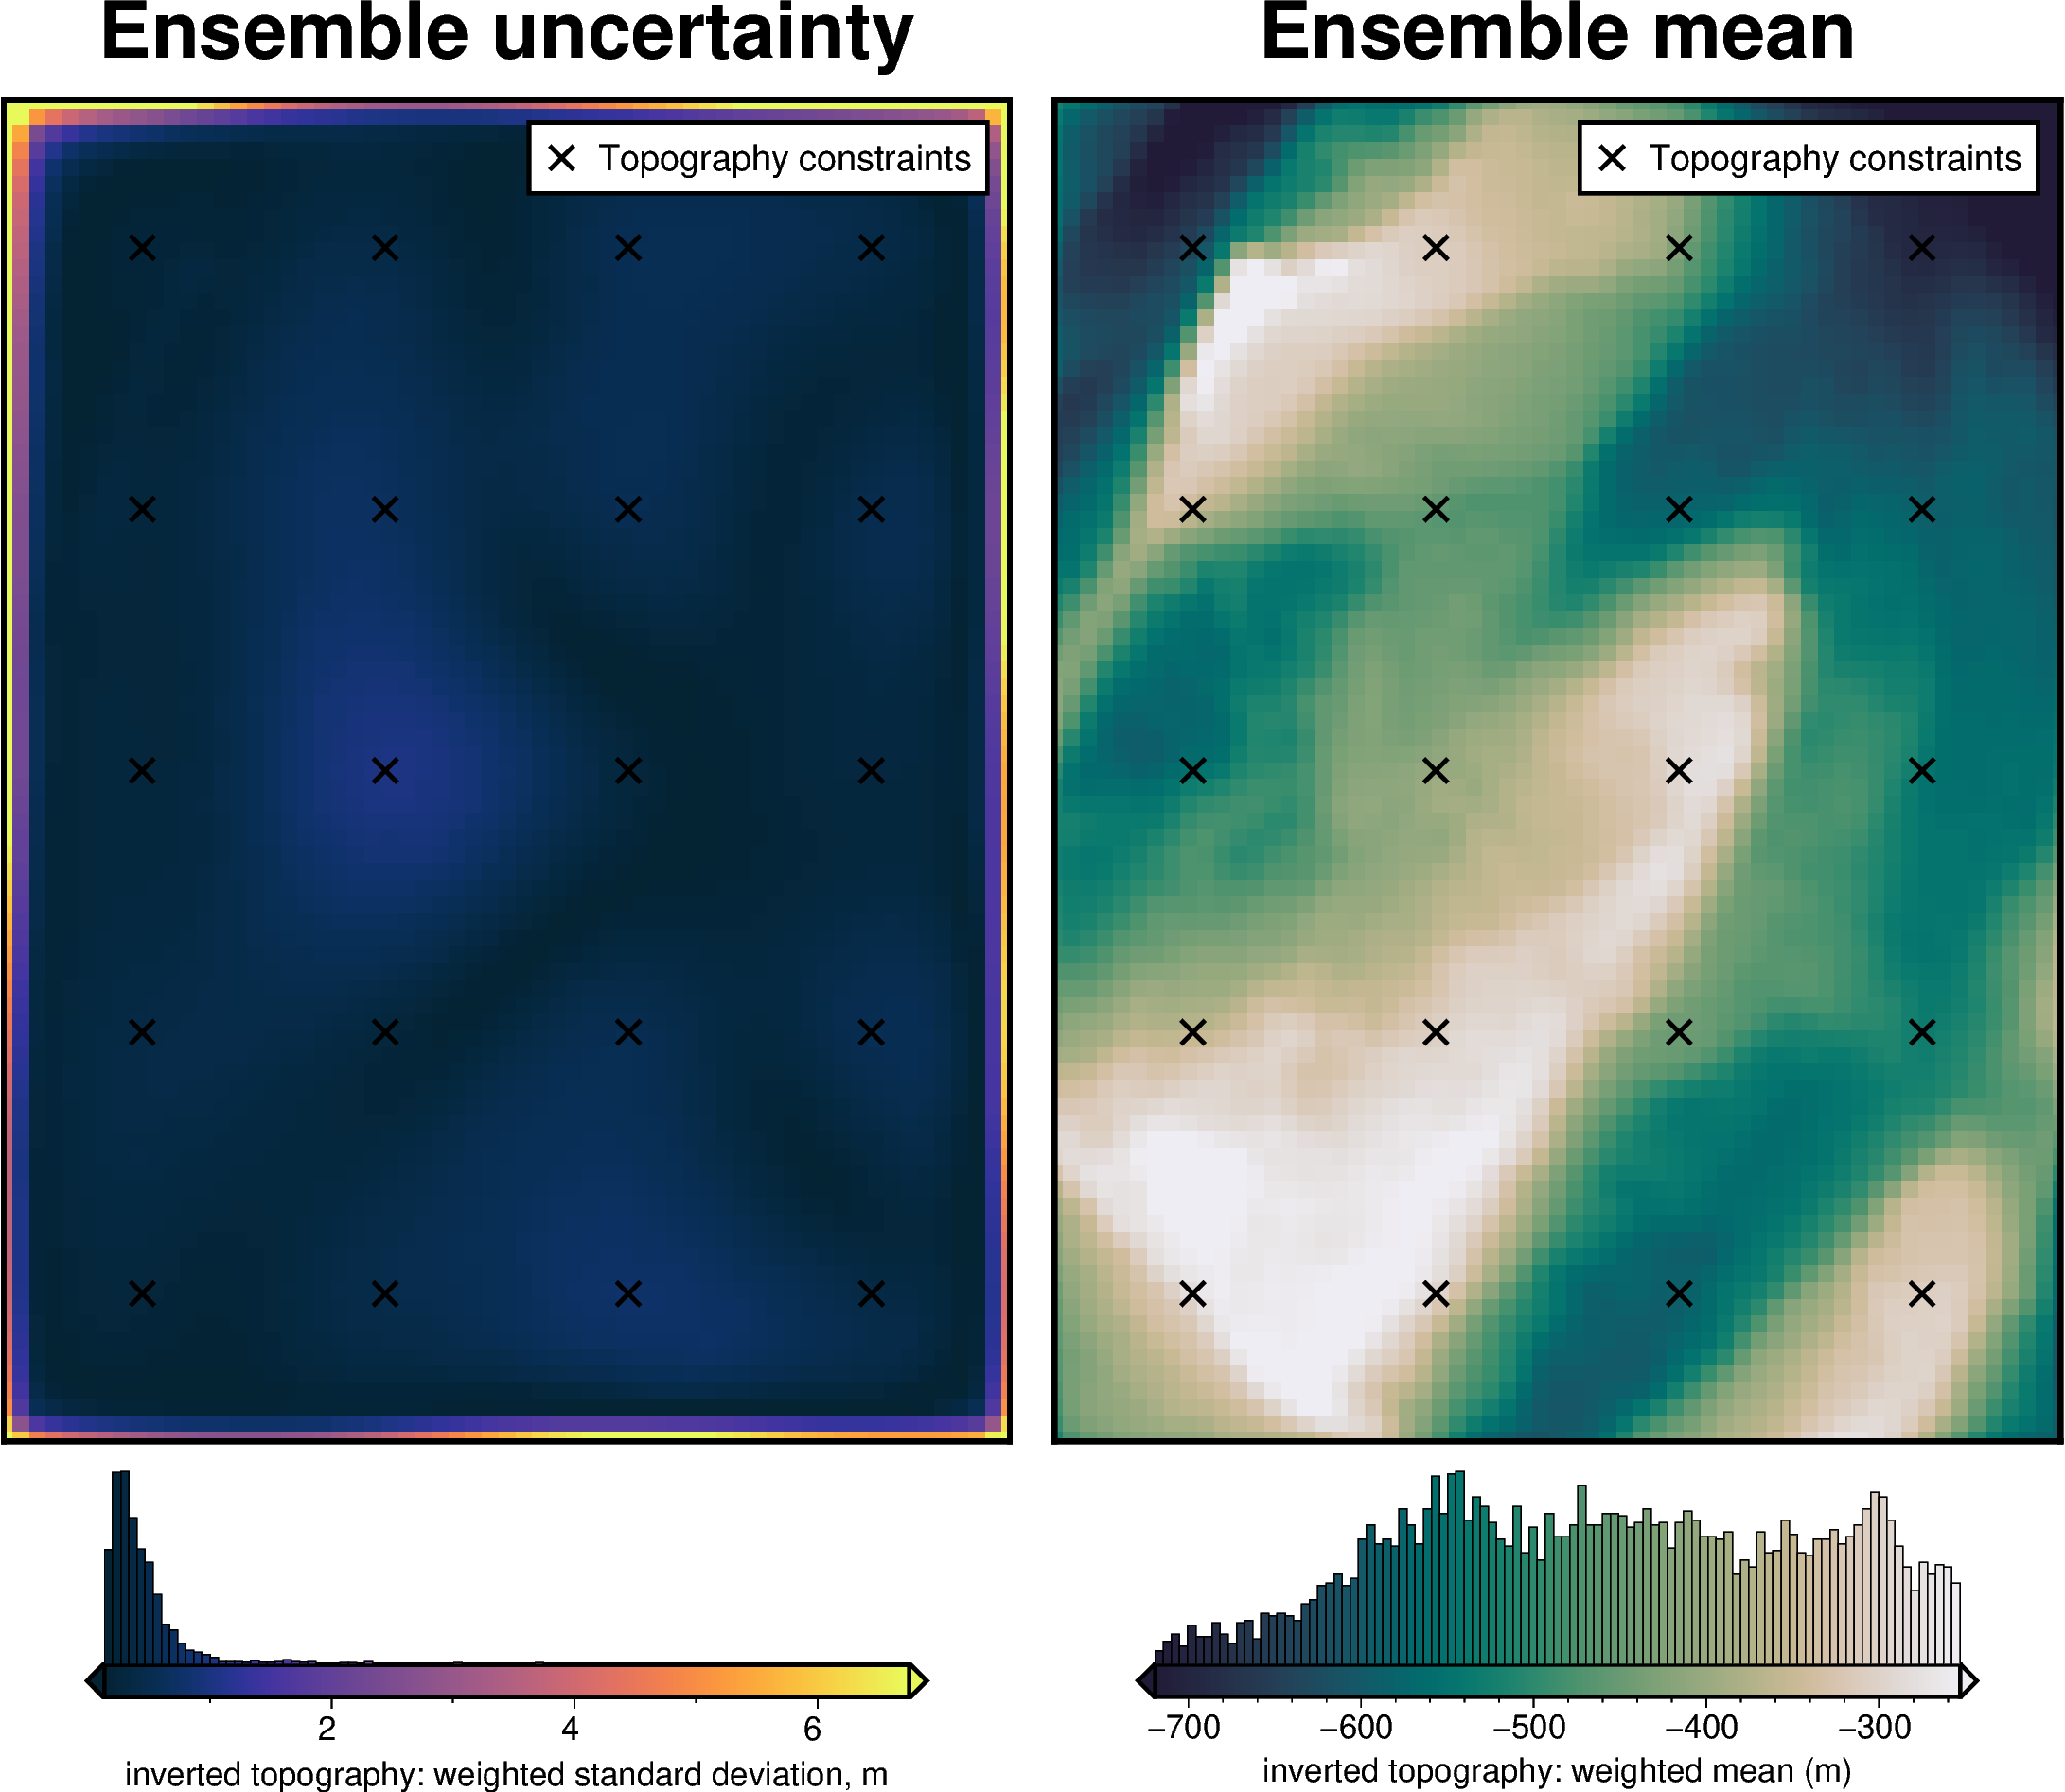

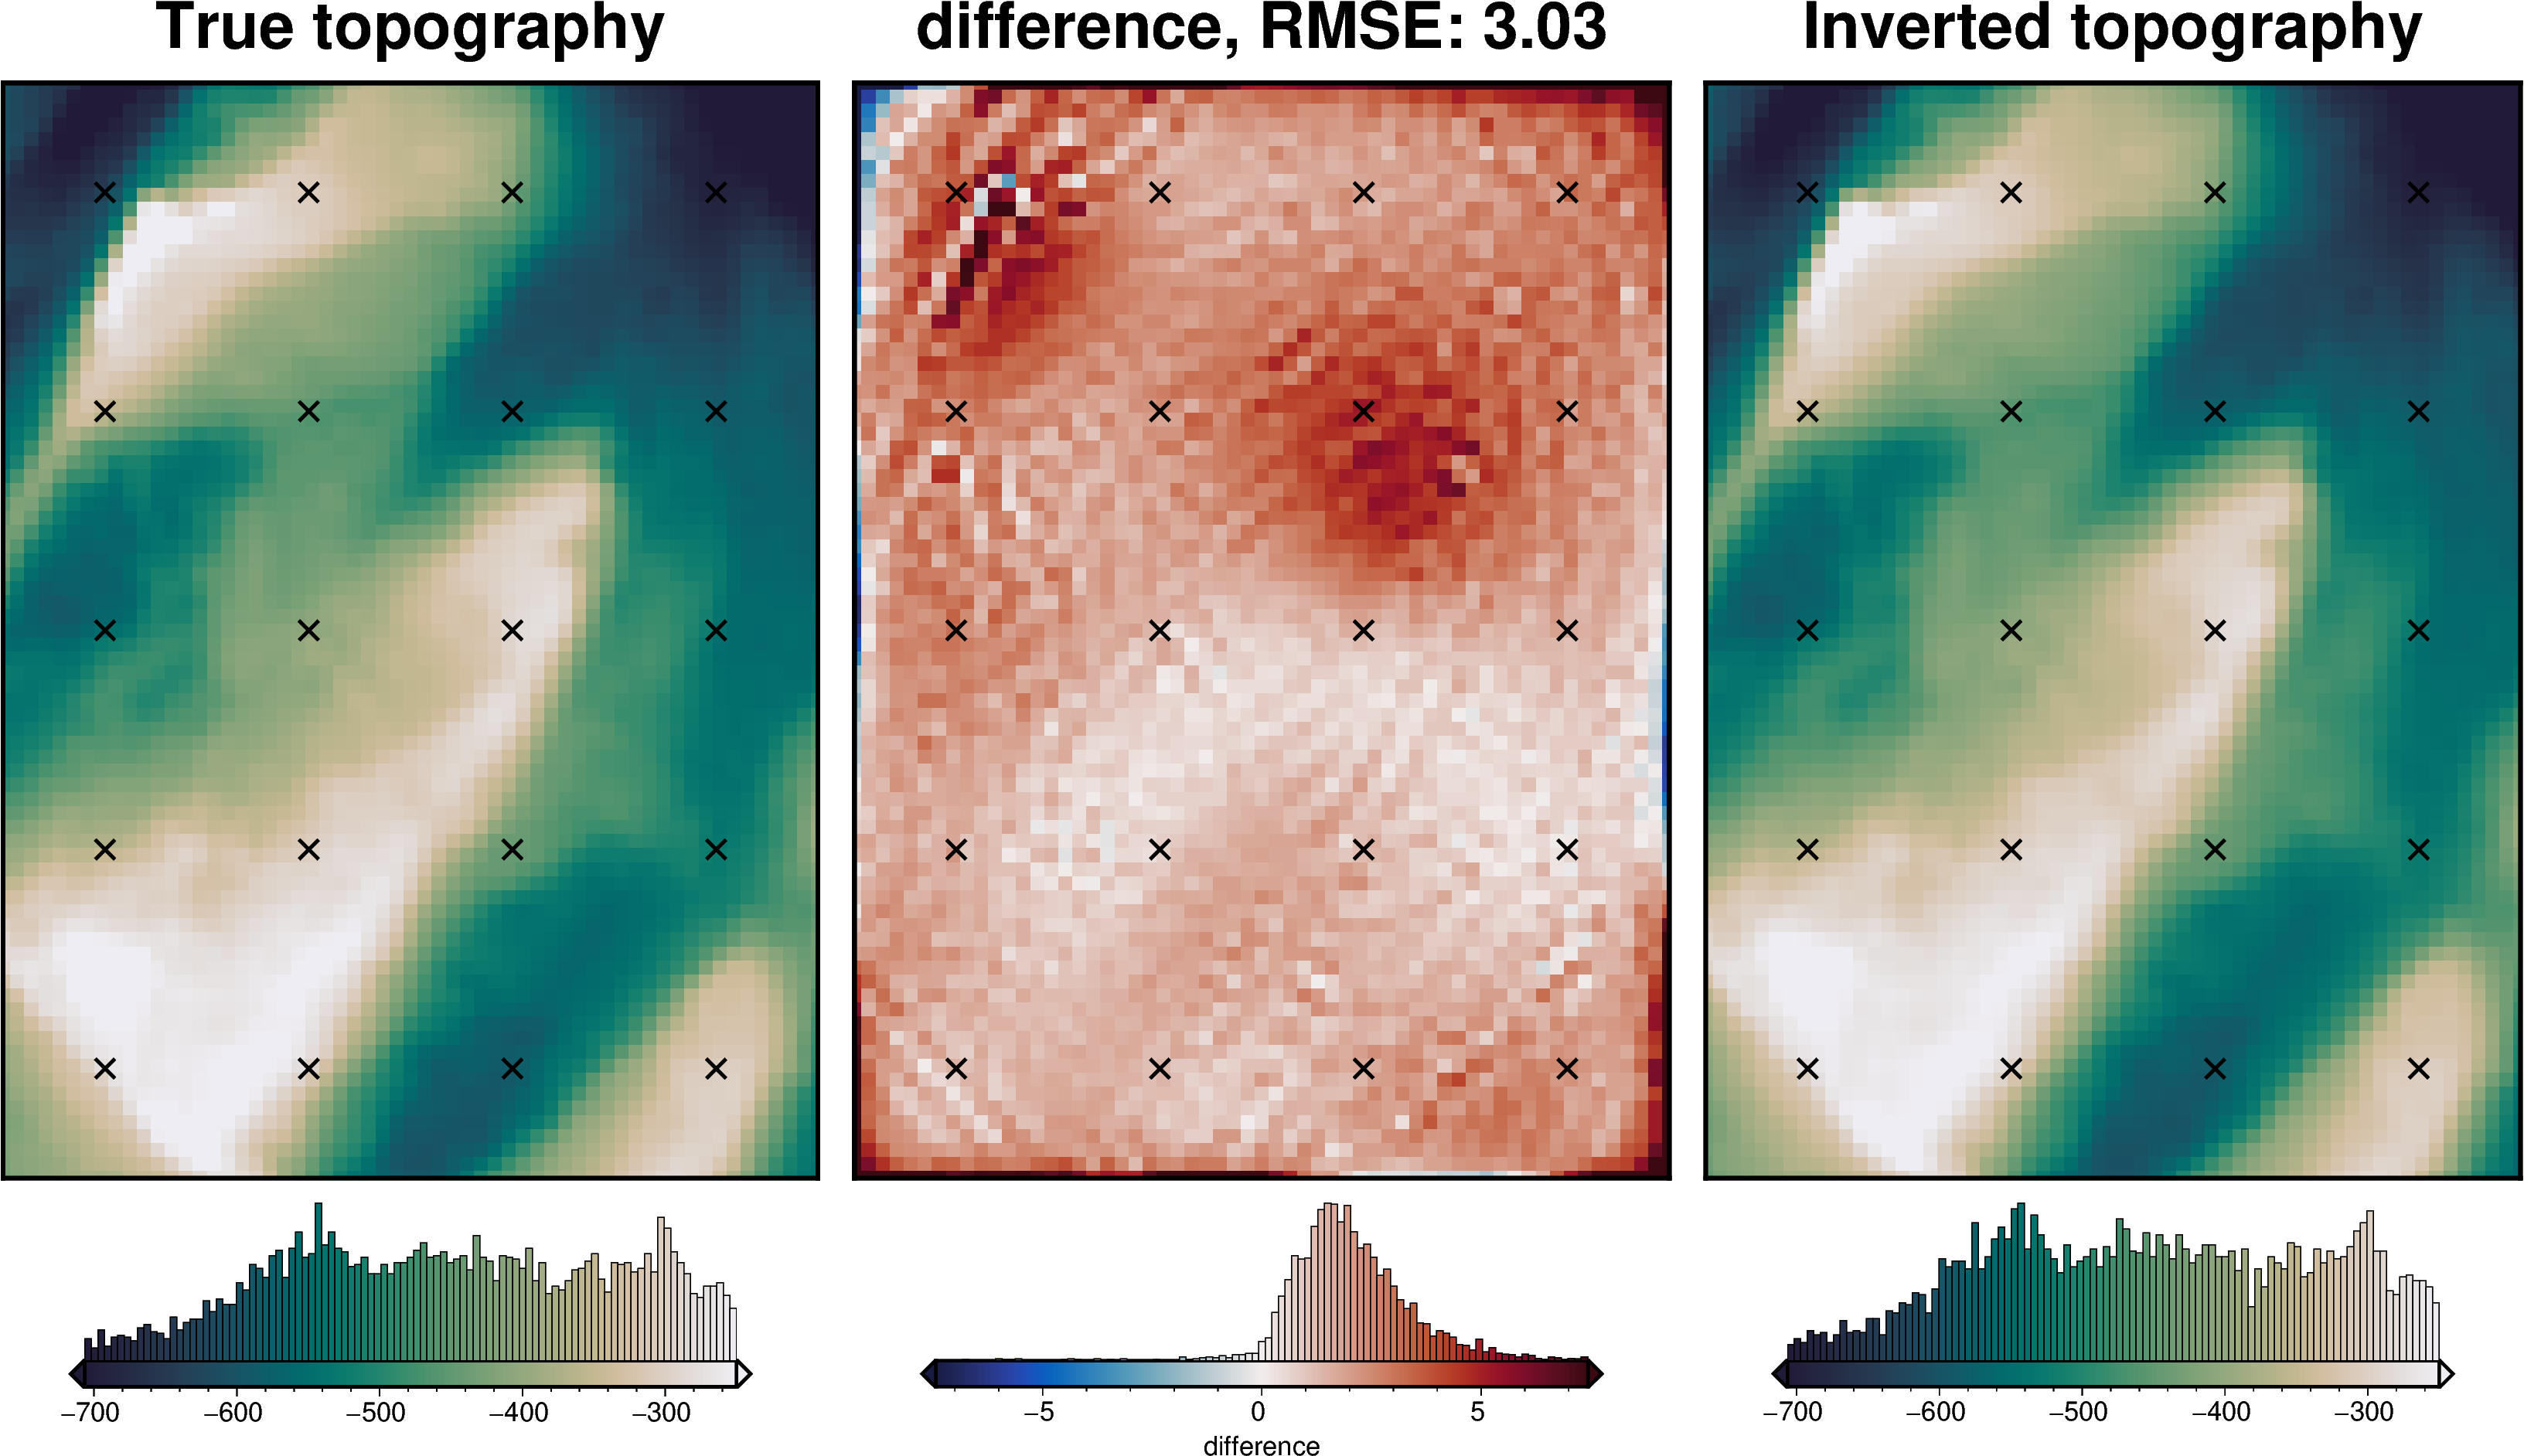

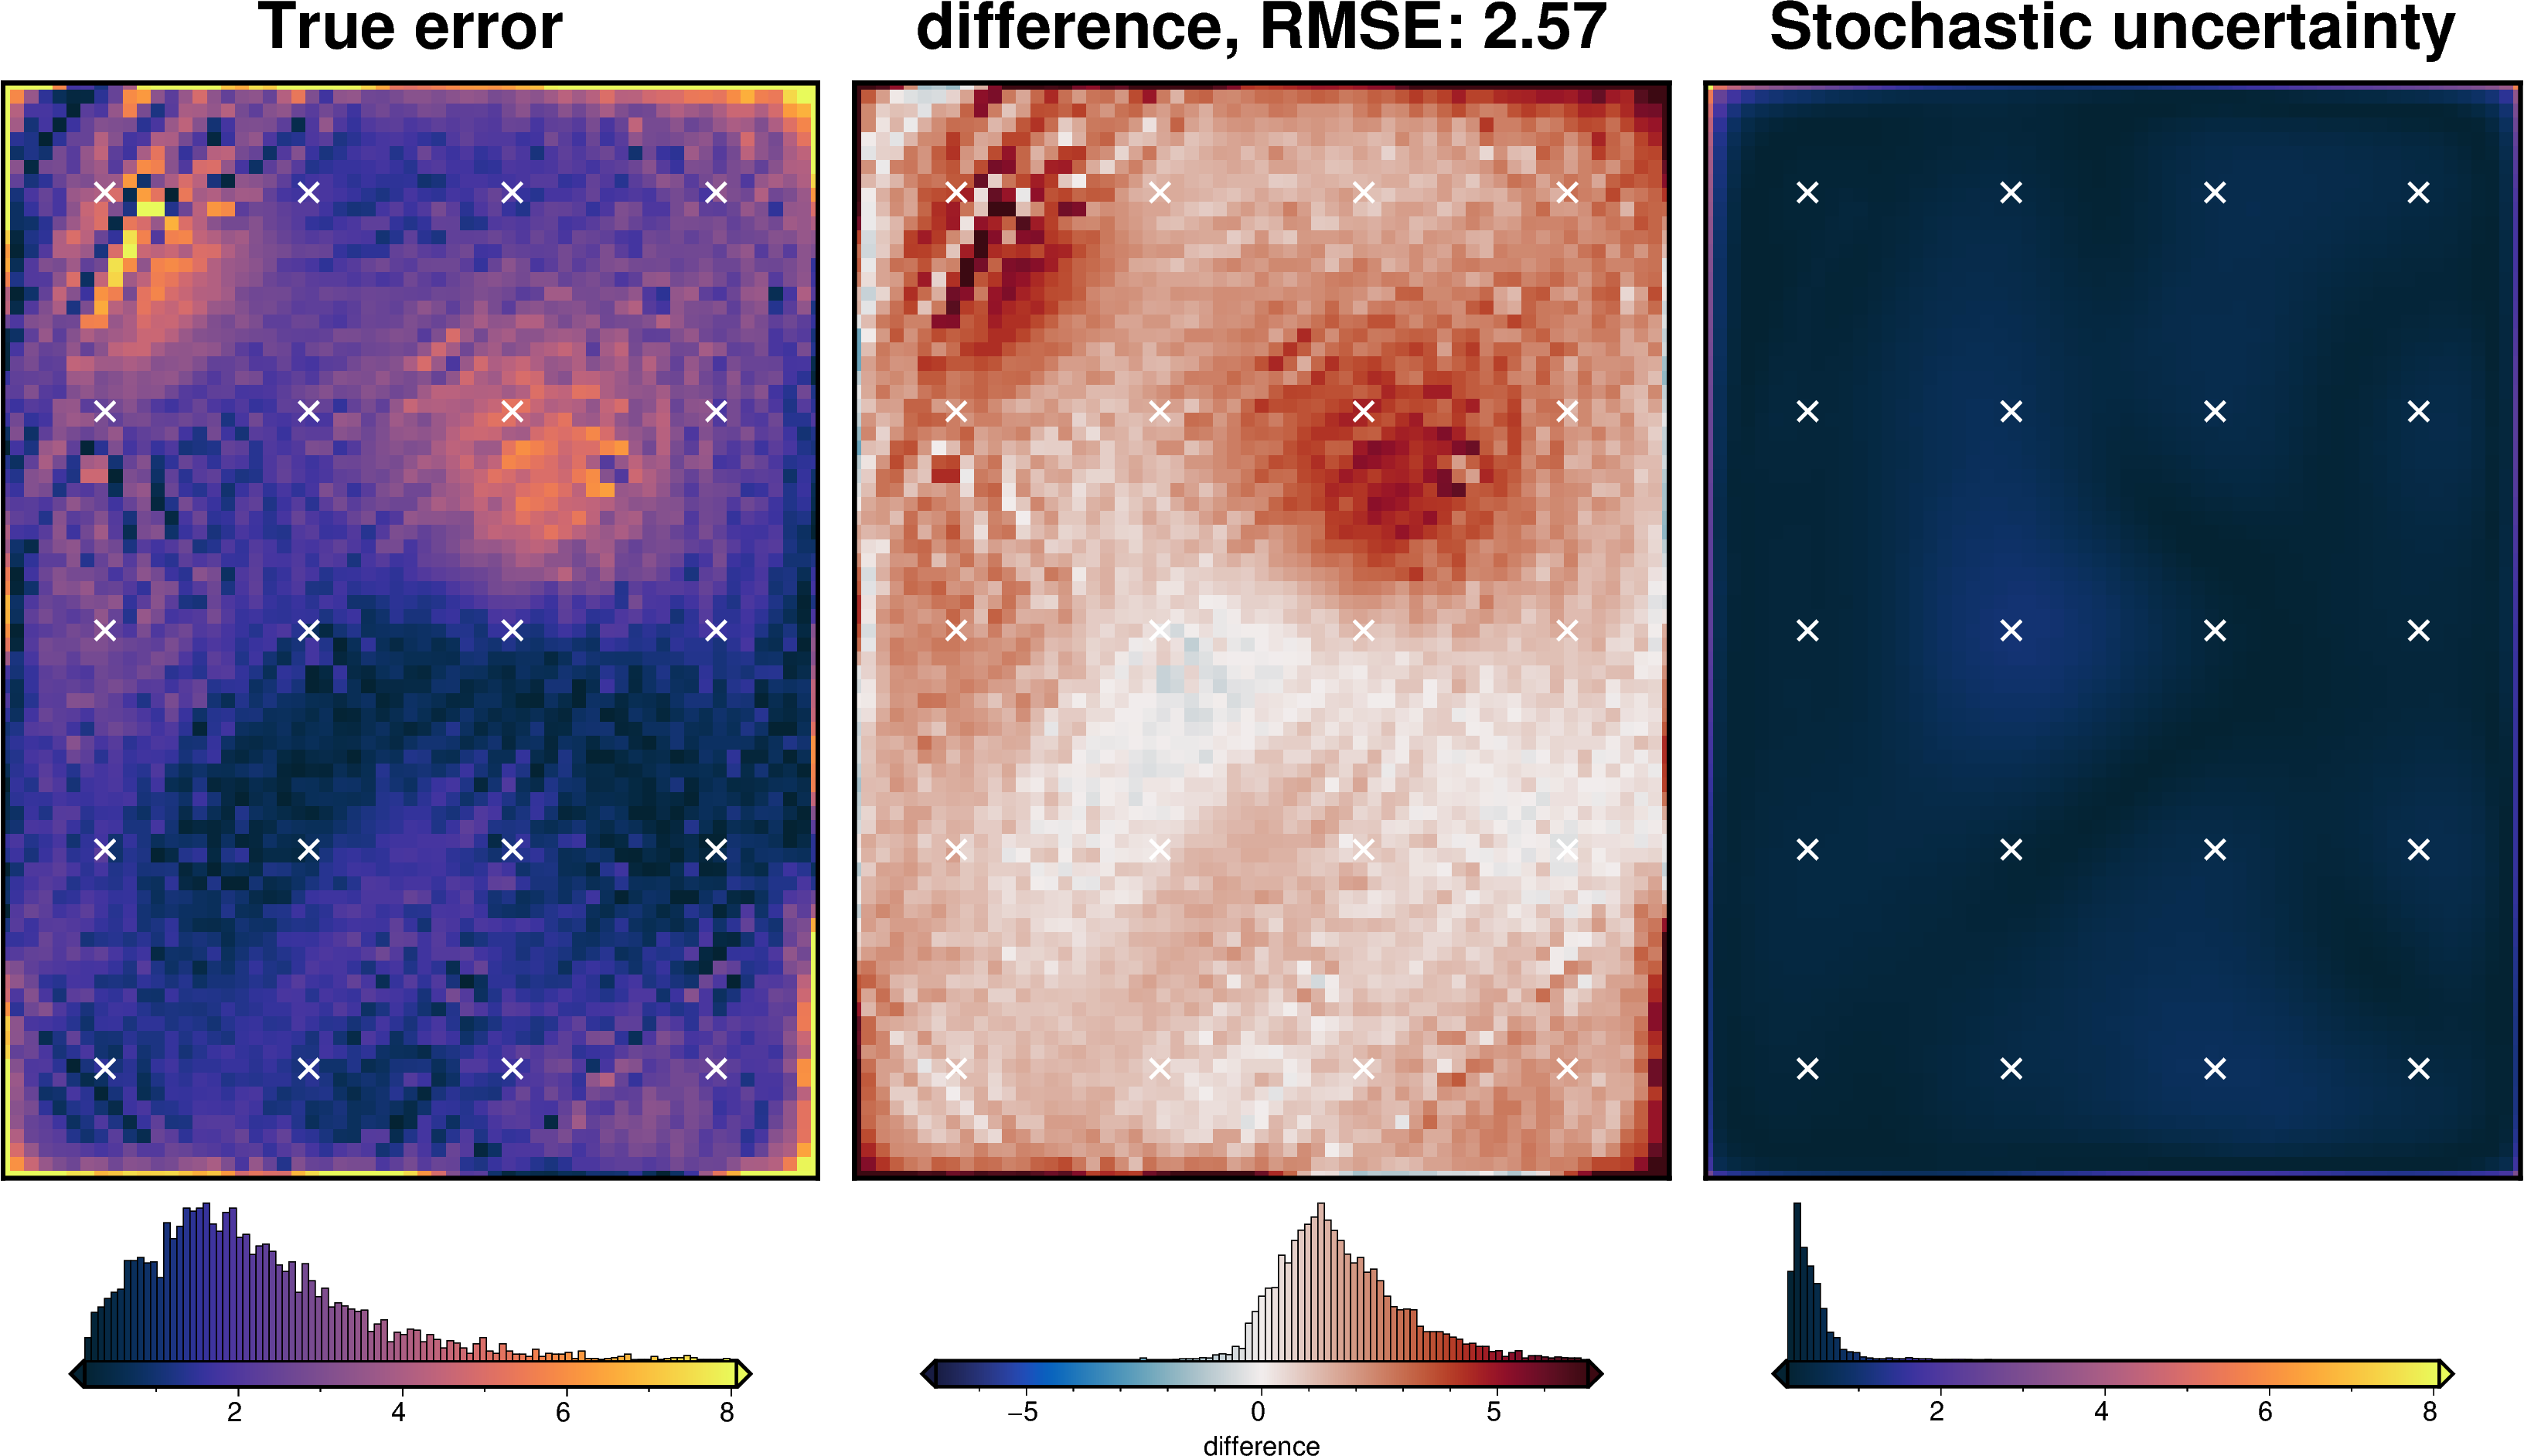

In [43]:
fname = "../../results/Ross_Sea_03_uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    runs=10,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_constraints_results,
    inversion_region,
    spacing,
    bathymetry,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Total uncertainty

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.024731236384837173, min: 0.019613162605945644, max: 0.030799525614321272
INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1470.1164840004974, min: 1460.3166640777972, max: 1479.9163039231976
INFO:invert4geom:all 20 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

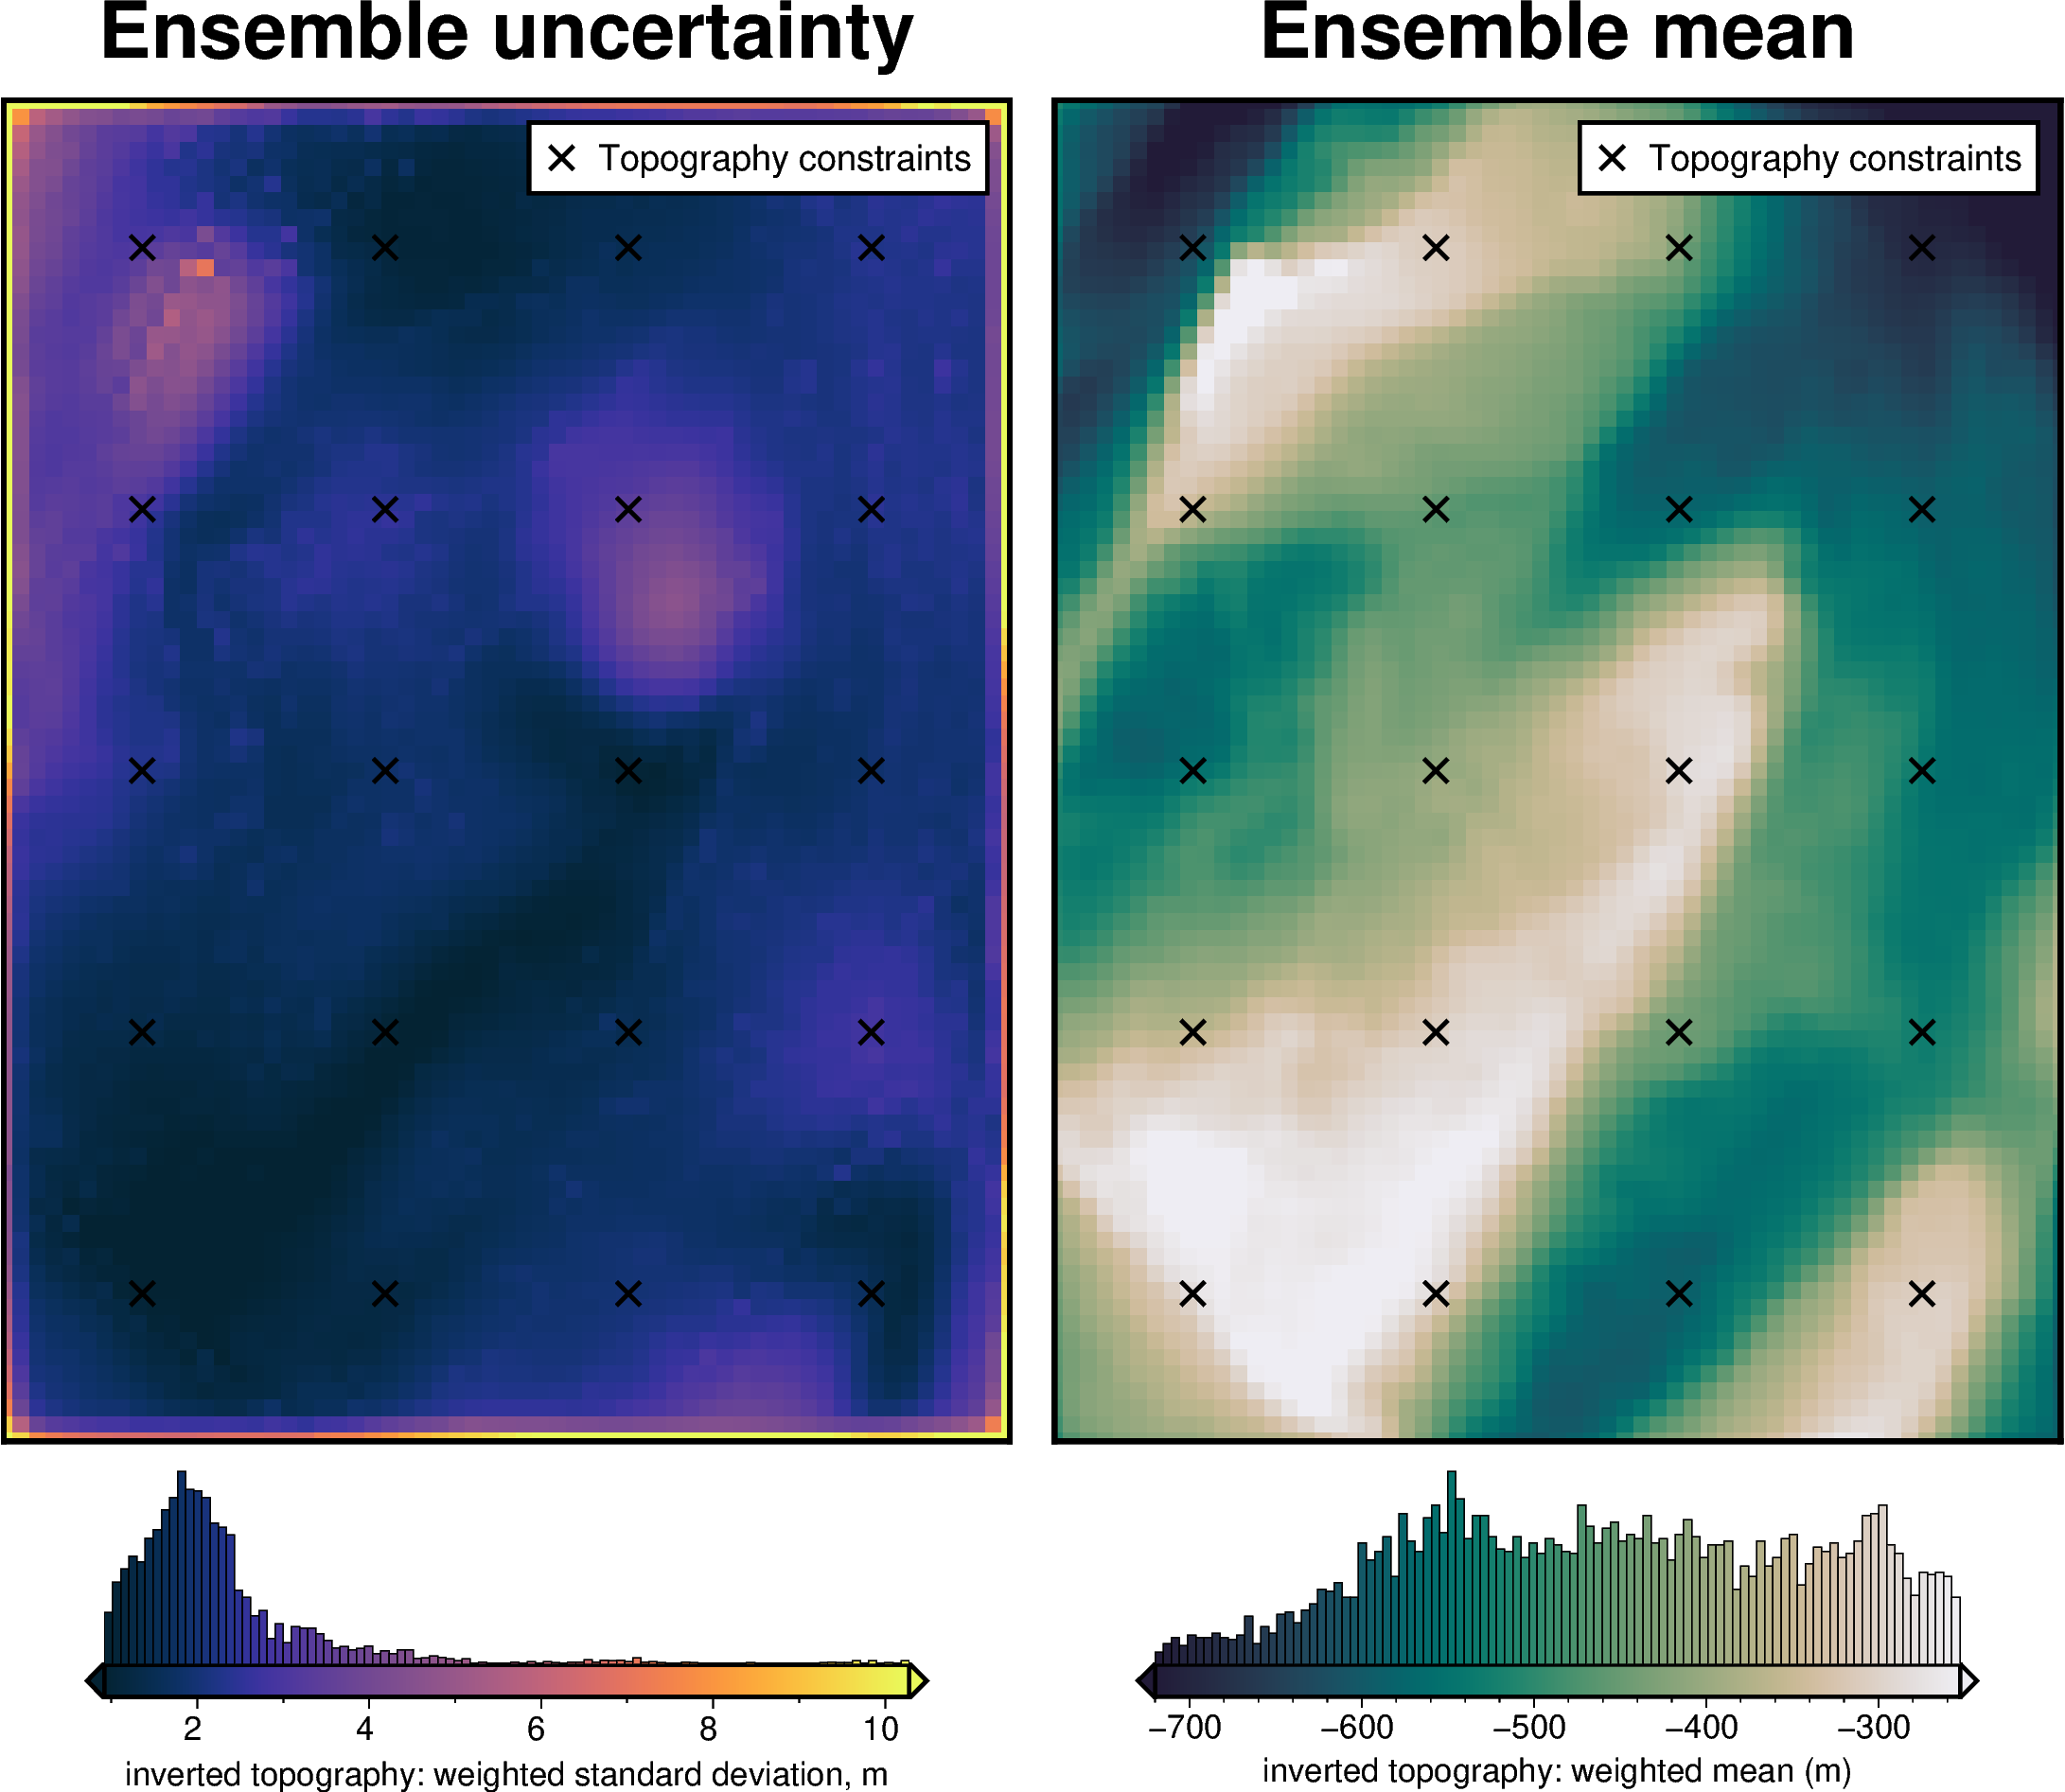

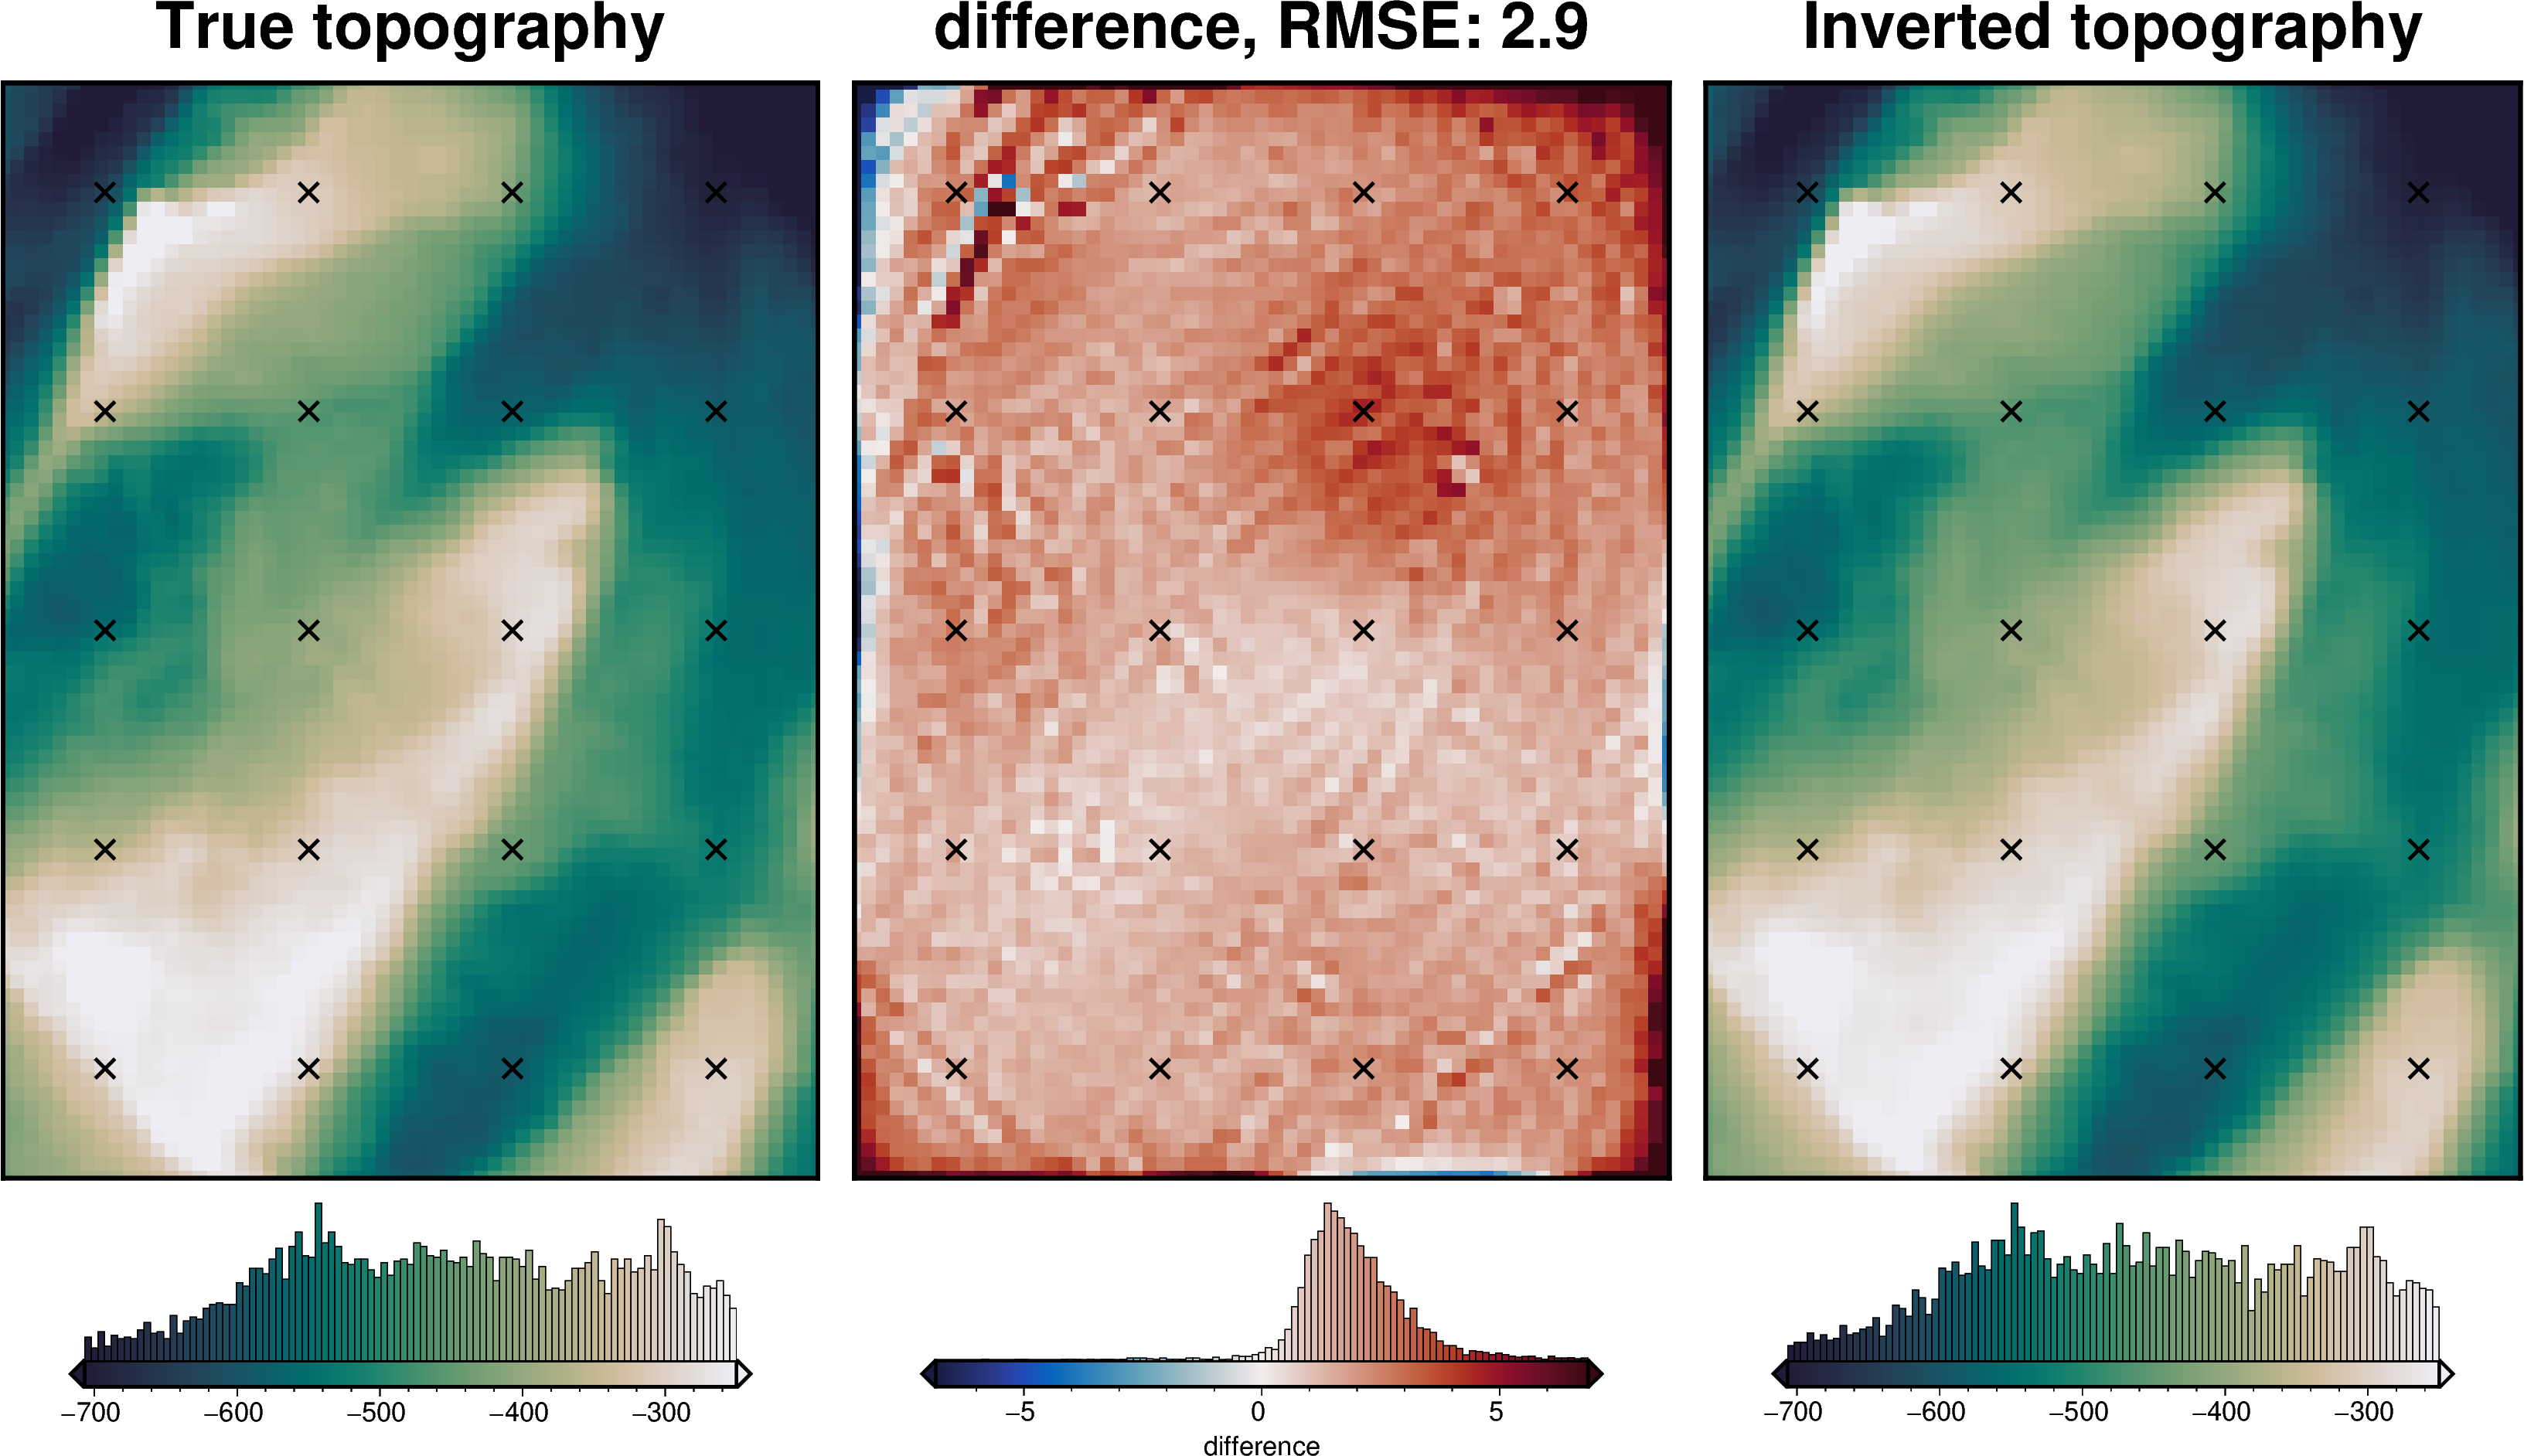

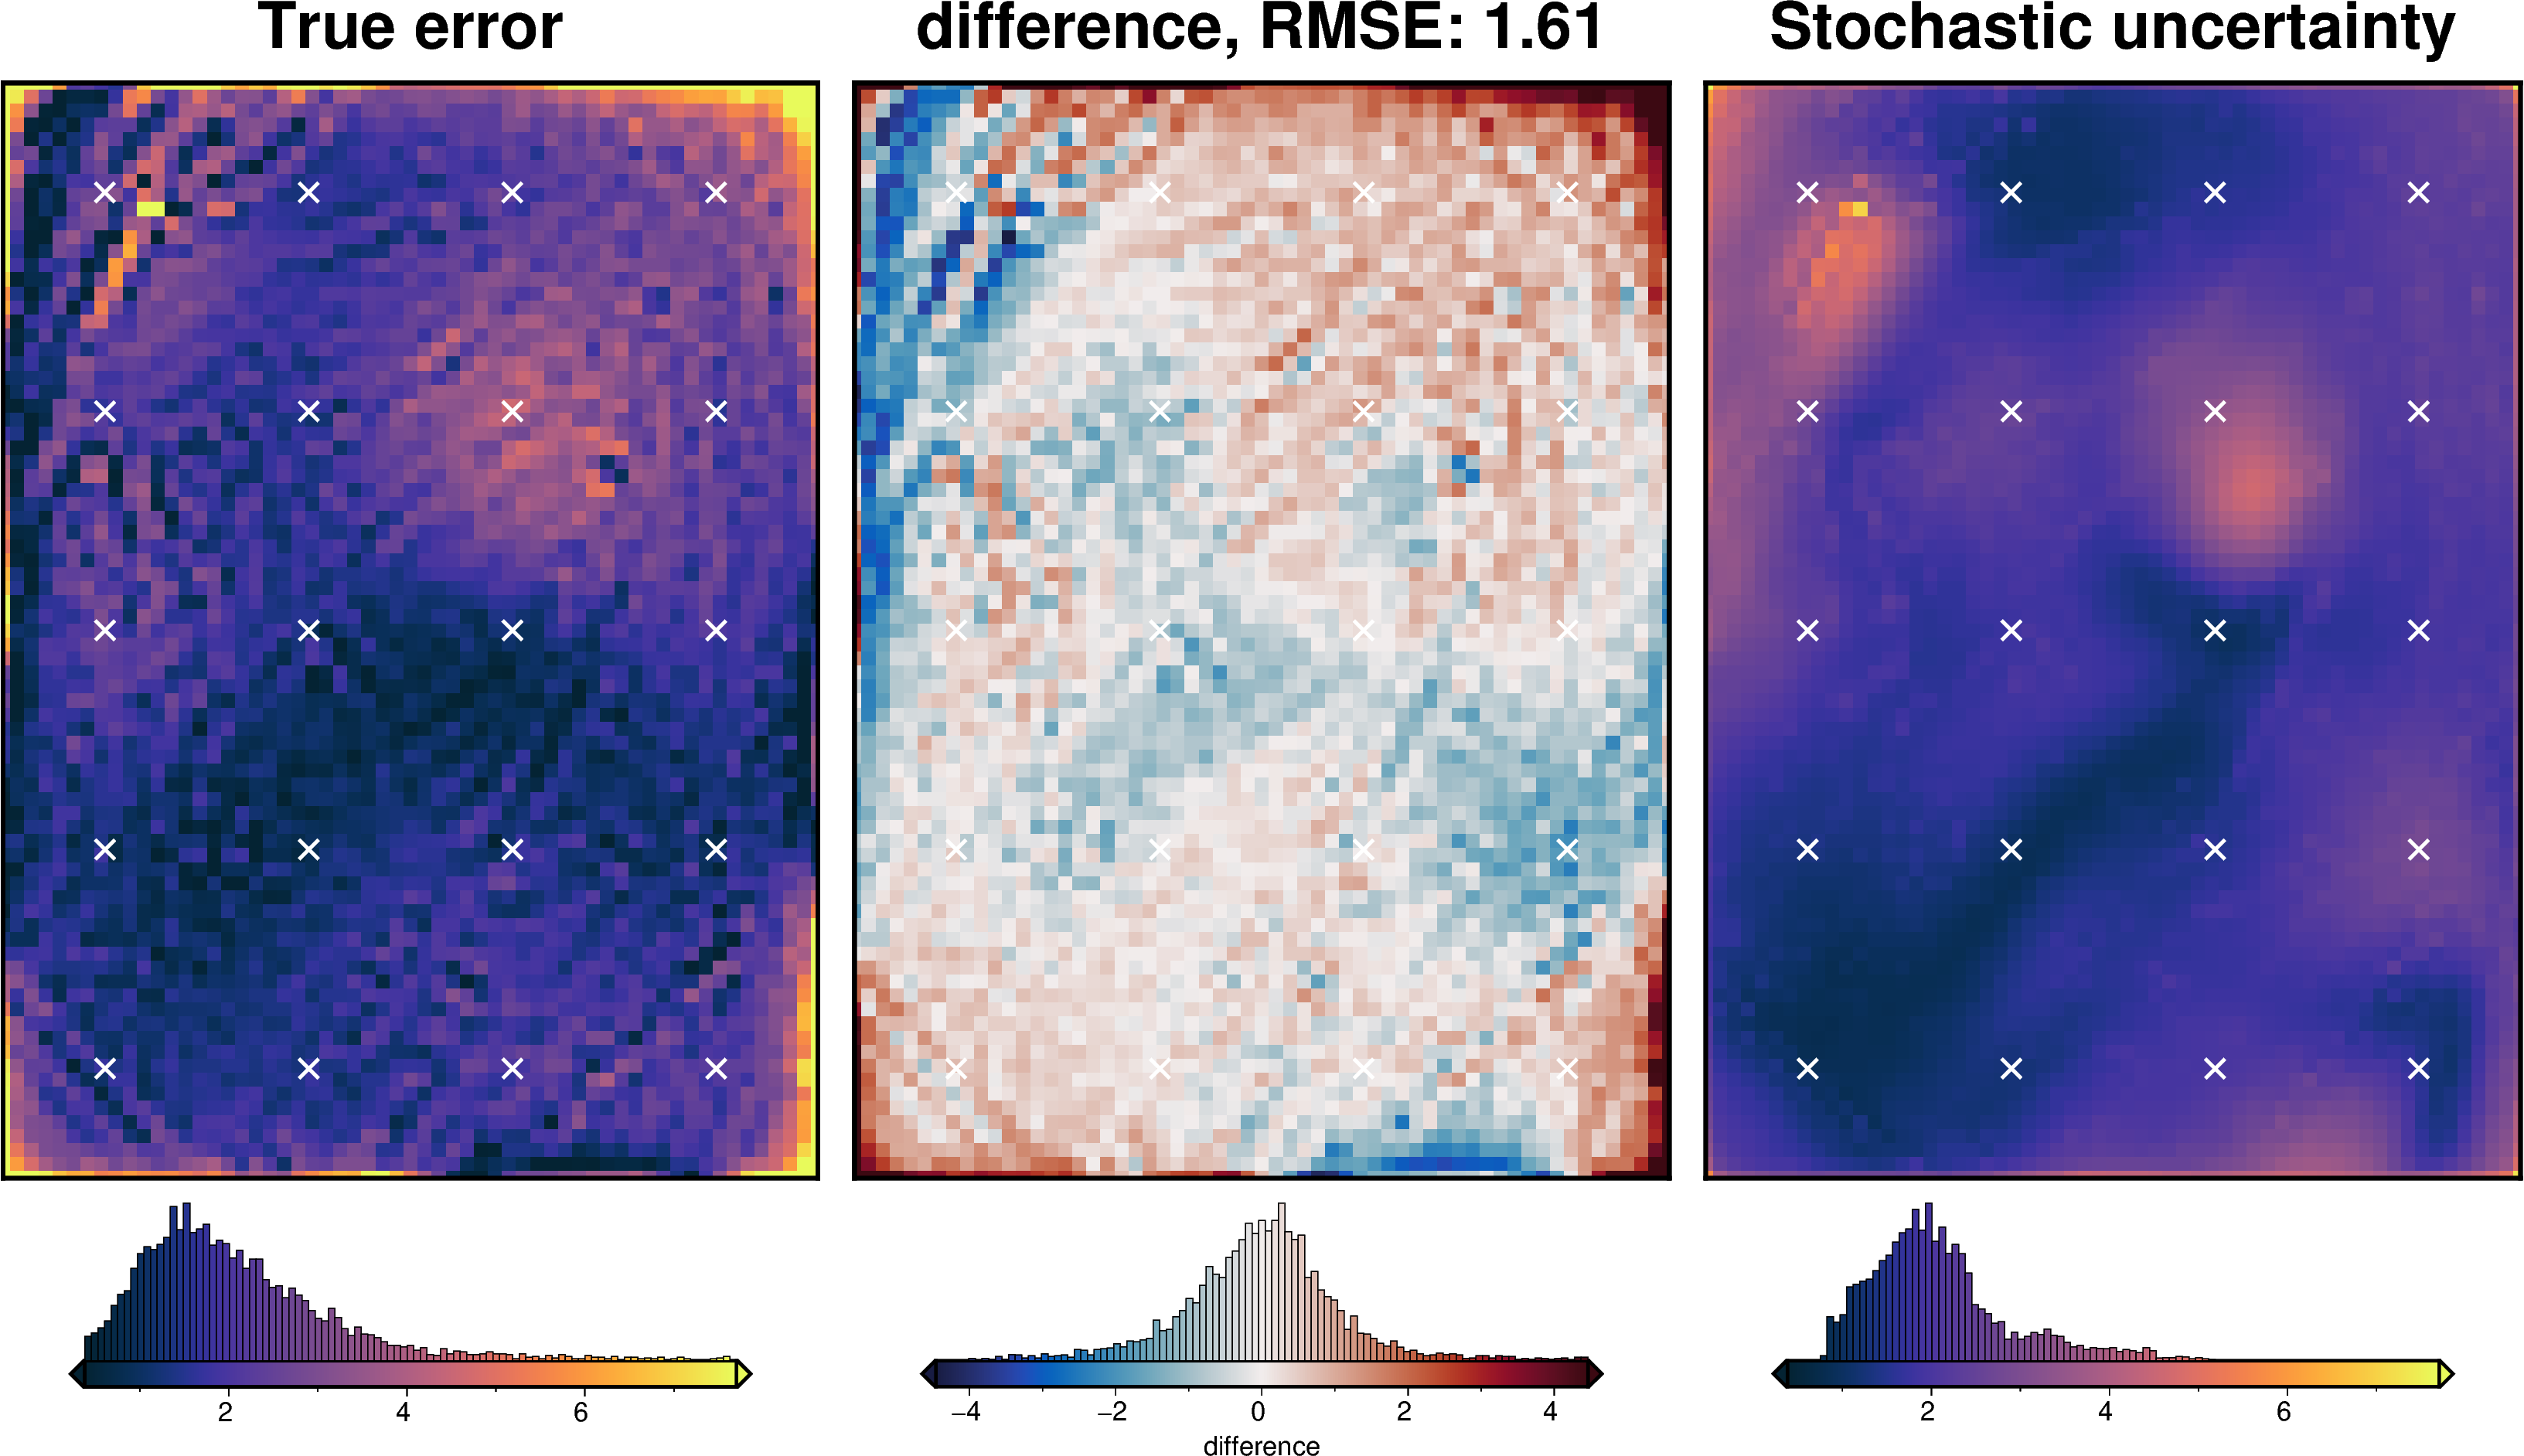

In [33]:
fname = "../../results/Ross_Sea_03_uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    parameter_dict=solver_dict | density_dict,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_results,
    inversion_region,
    spacing,
    bathymetry,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

### Comparing results

In [34]:
results = [
    uncert_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_damping_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        region=vd.pad_region(inversion_region, -spacing),
    )
    stats.append(ds)

In [35]:
names = [
    "full",
    "constraints",
    "density",
    "damping",
]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 150kB
Dimensions:            (northing: 79, easting: 59)
Coordinates:
  * northing           (northing) float64 632B -1.795e+06 ... -1.405e+06
  * easting            (easting) float64 472B -3.5e+04 -3e+04 ... 2.55e+05
Data variables:
    full_stdev         (northing, easting) float64 37kB 5.724 3.716 ... 7.783
    constraints_stdev  (northing, easting) float64 37kB 2.913 1.686 ... 5.74
    density_stdev      (northing, easting) float64 37kB 1.663 1.545 ... 3.02
    damping_stdev      (northing, easting) float64 37kB 3.613 2.927 ... 2.706

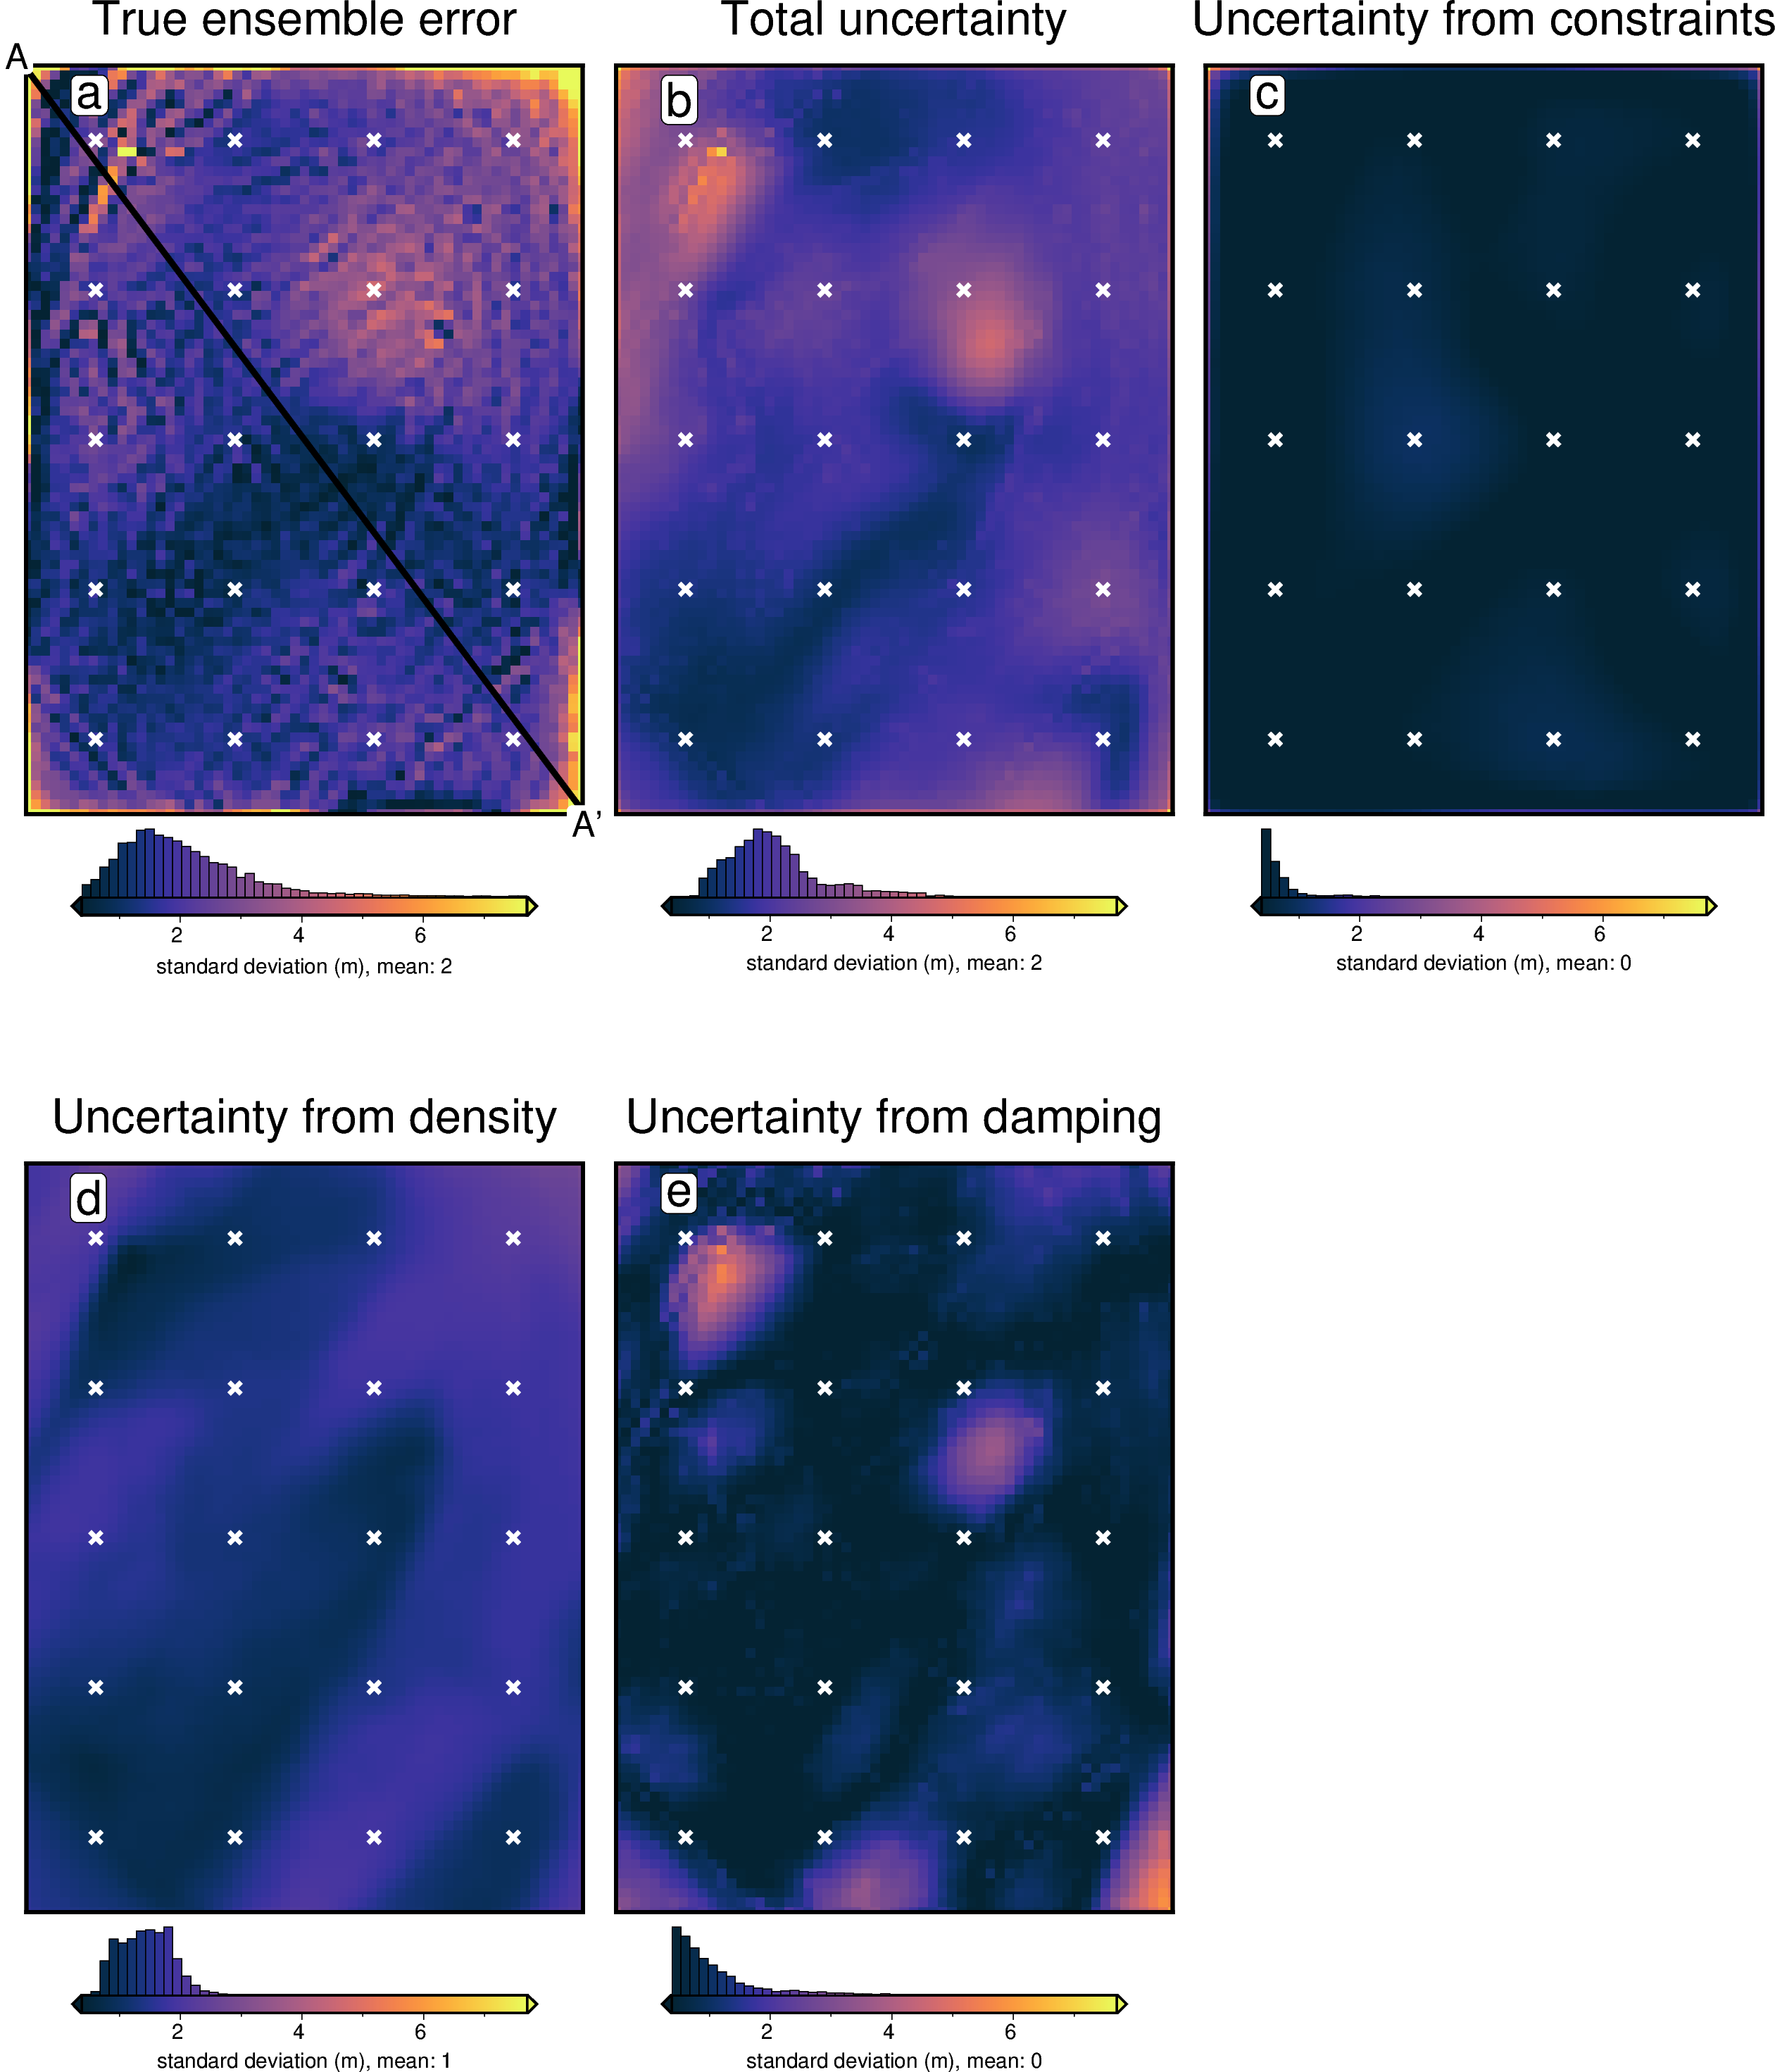

In [36]:
titles = [
    "True ensemble error",
    # "True indiv error",
    "Total uncertainty",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - bathymetry))

cpt_lims = polar_utils.get_min_max(
    grids[0],
    robust=True,
)
# cpt_lims = polar_utils.get_combined_min_max(grids, robust=True)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 3:
        origin_shift = "both_shift"
        xshift_amount = -2
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        # region=vd.pad_region(inversion_region, -3*spacing),
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        fill="white",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profiles location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


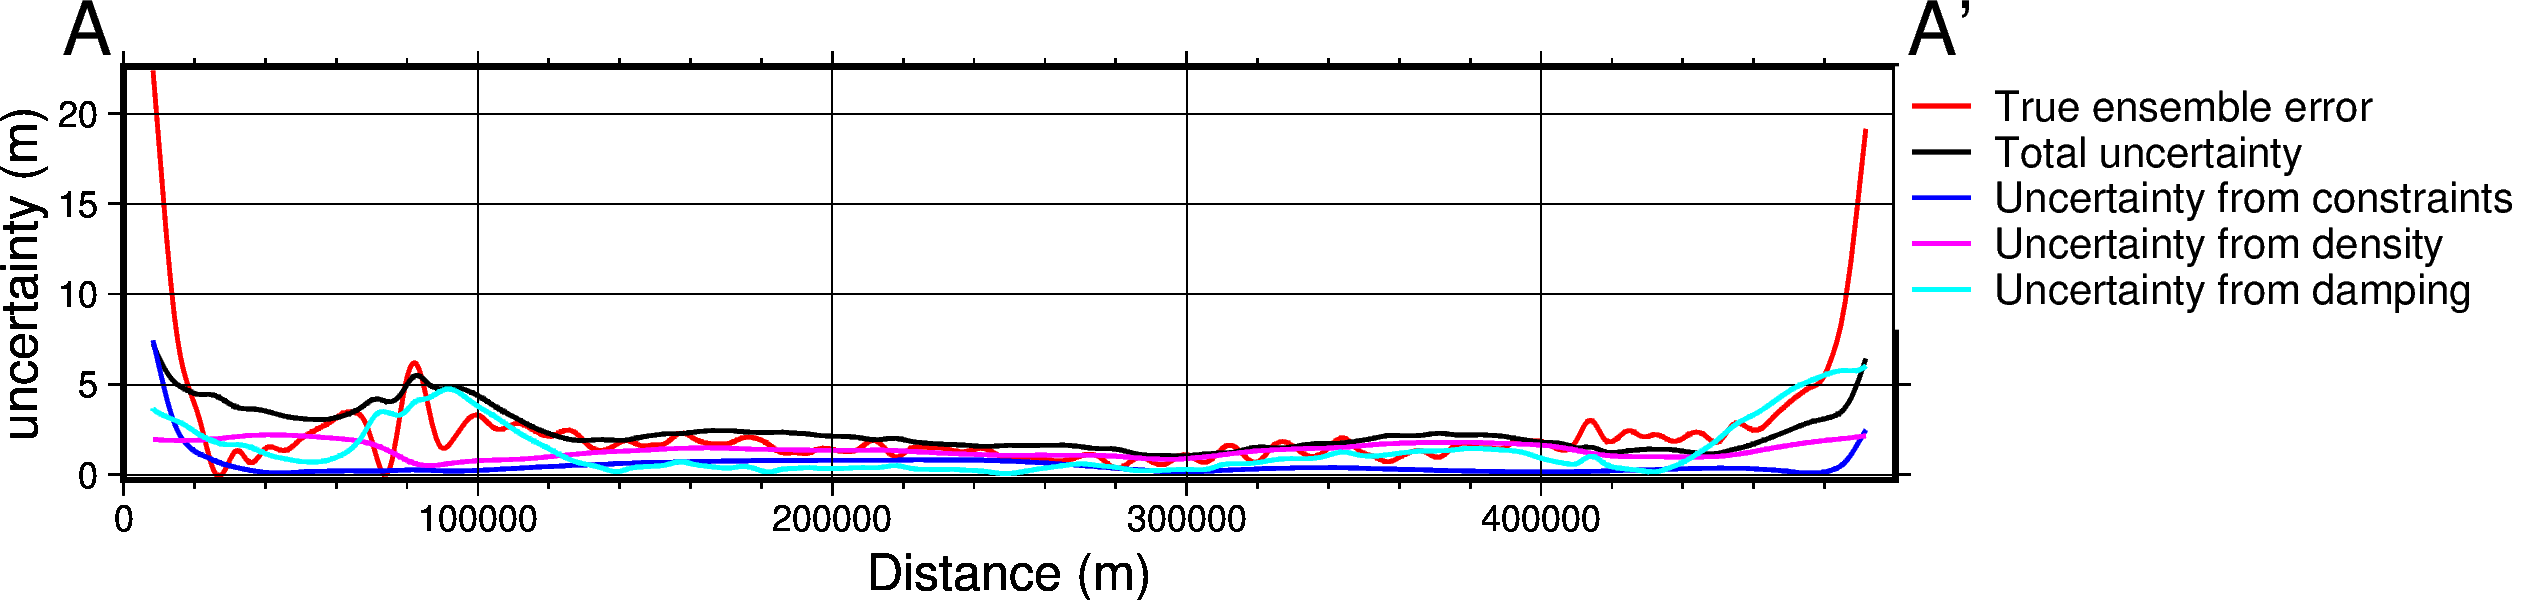

In [37]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inversion_region[0], inversion_region[3]],
    stop=[inversion_region[1], inversion_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()

INFO:root:grid regions dont match, using inner region (-35000.0, 255000.0, -1795000.0, -1405000.0)
INFO:root:returning original grid


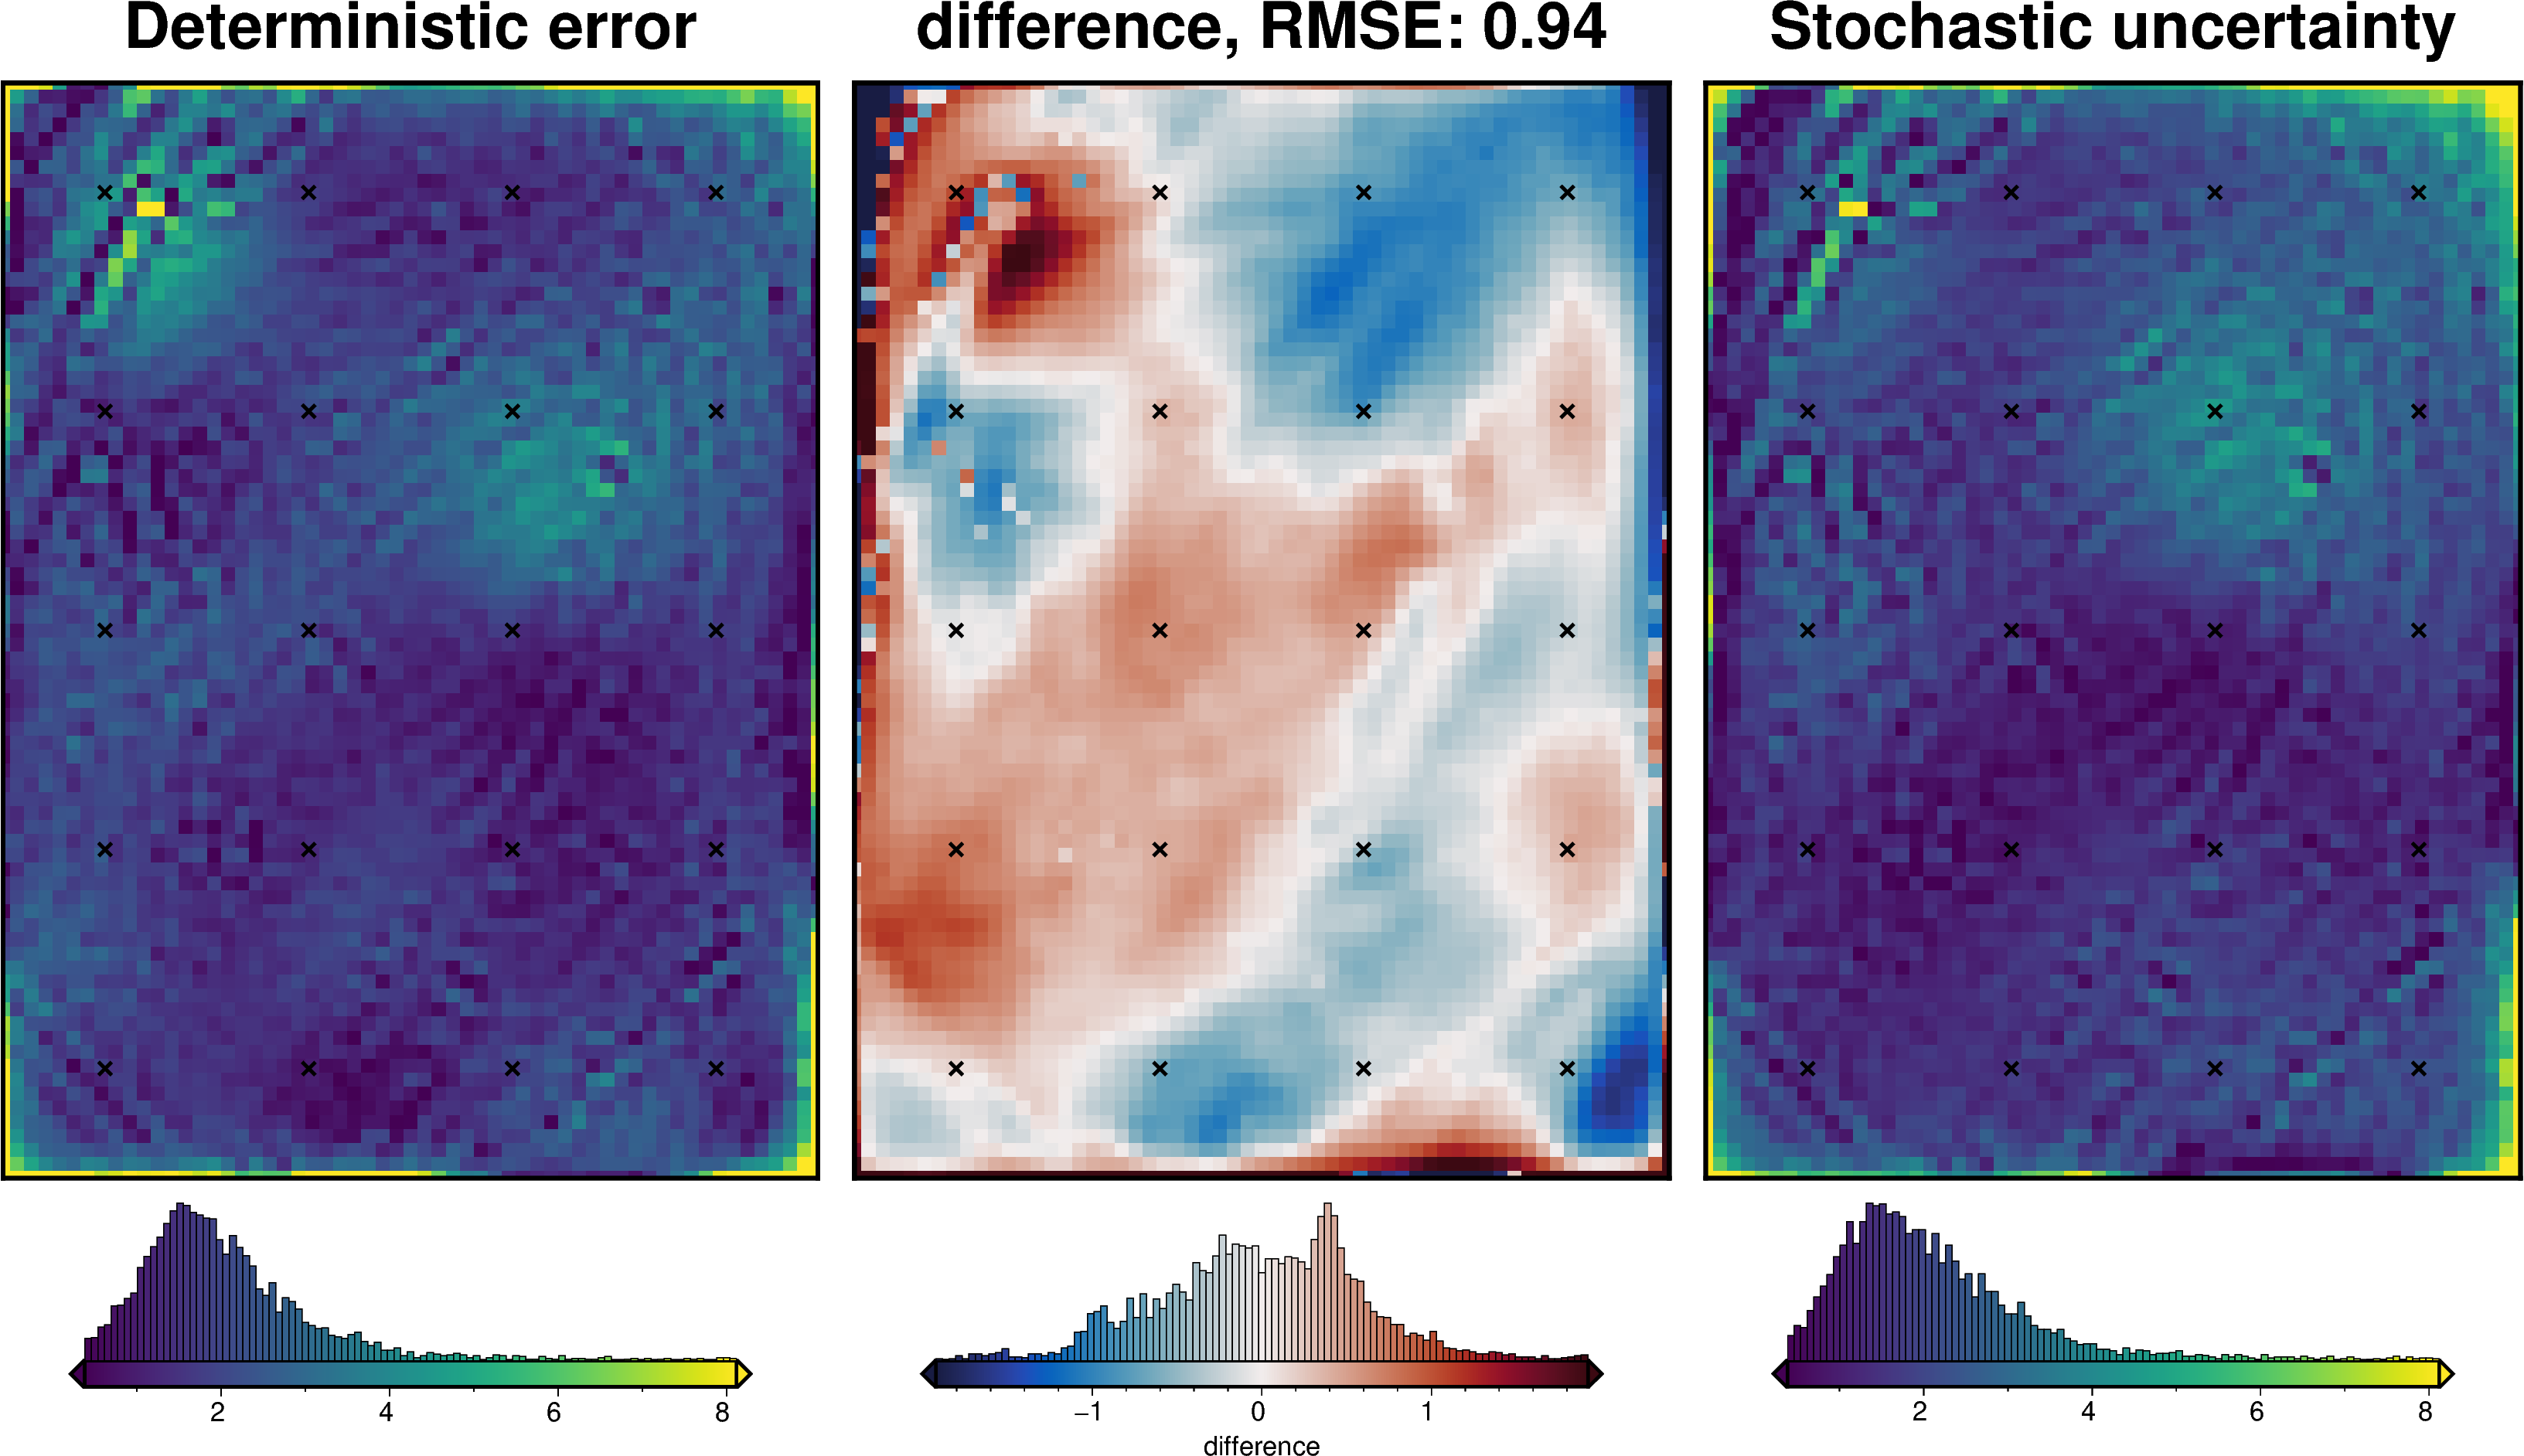

In [38]:
_ = polar_utils.grd_compare(
    inversion_error,
    np.abs(stats[0].weighted_mean - bathymetry),
    region=inversion_region,
    plot=True,
    grid1_name="Deterministic error",
    grid2_name="Stochastic uncertainty",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [39]:
# save results
merged.to_netcdf("../../results/Ross_Sea_03_sensitivity.nc")

In [40]:
stats_ds.to_netcdf("../../results/Ross_Sea_03_uncertainty.nc")